In [1]:
import numpy as np
import os
import pandas as pd
import datetime
import sys
from os.path import isfile, join
import glob

from random import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdat
%matplotlib inline

import time_hist2

from geospacepy import omnireader



In [2]:
def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

In [3]:
# Function to produce plot of the DMSP observational coverage

def get_dmsp_coverage(df,latres=2.0,ltres=1.0,verbose=1,var_for_stats='ELE_AVG_ENERGY'):
    "This function gets the coverage of DMSP data in df."
    
    if verbose == 1:
        print('latitude resolution = {}'.format(latres))
        print('local time resolution = {}'.format(ltres))

    if not 'SC_AACGM_LAT' in df.columns:
        raise ValueError('df needs to contain SC_AACGM_LAT')
    if not 'SC_AACGM_LTIME' in df.columns:
        raise ValueError('df needs to contain SC_AACGM_LTIME')
            
    mlats = np.arange(45,90,latres)
    mlts = np.arange(0,24,ltres)
    # mlts = np.append(mlts,[0])

    xgrid, ygrid = np.meshgrid(mlts,mlats)

    # print(xgrid)

    # print(ygrid)

    grid_density = np.zeros_like(xgrid)
    grid_average = np.zeros_like(xgrid,dtype=float)
    grid_max = np.zeros_like(xgrid,dtype=float)
    for i in range(len(mlats)):
        for j in range(len(mlts)):
            if (j == 0):
    #             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
    #                                                                            mlats[i]+(latres/2.),
    #                                                                            0,
    #                                                                            mlts[j]+(ltres/2.)))
                grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                          (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                          (df['SC_AACGM_LTIME']>(0.)) &
                                          (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                        ].count()[0] )
        
                if (grid_density[i,j] > 0):
                    grid_average[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>(0.)) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].mean() )
                    grid_max[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>(0.)) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].max() )
                else: 
                    grid_average[i,j] = -1000
                    grid_max[i,j] = -1000
                    
            elif (j == len(mlts)-1):
    #             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
    #                                                                            mlats[i]+(latres/2.),
    #                                                                            23.5,
    #                                                                            24))
                grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                          (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                          (df['SC_AACGM_LTIME']>=(23.5)) 
                                        ].count()[0] )
                if (grid_density[i,j] > 0):
                    grid_average[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(23.5)) 
                                            ][var_for_stats].mean() )
                    grid_max[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(23.5)) 
                                            ][var_for_stats].max() )
                else: 
                    grid_average[i,j] = -1000
                    grid_max[i,j] = -1000

            else: 
        #             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
        #                                                                            mlats[i]+(latres/2.),
        #                                                                            mlts[j]-(ltres/2.),
        #                                                                            mlts[j]+(ltres/2.)))
                grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                          (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                          (df['SC_AACGM_LTIME']>=(mlts[j]-(ltres/2.))) &
                                          (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                        ].count()[0] )

                if (grid_density[i,j] > 0):
                    grid_average[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(mlts[j]-(ltres/2.))) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].mean() )  
                    grid_max[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(mlts[j]-(ltres/2.))) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].max() )  
                else:
                    grid_average[i,j] = -1000
                    grid_max[i,j] = -1000

    # Redefine zero grid points to NaN so that they do not show up on the plot
    grid_density = grid_density.astype('float')
    grid_density[grid_density == 0.] = np.nan

    grid_average = grid_average.astype('float')
    grid_average[ (grid_average == 0.) | (grid_average == -1000) ] = np.nan
    
    grid_max = grid_max.astype('float')
    grid_max[ (grid_max == 0.) | (grid_max == -1000) ] = np.nan
    
    # Create the appropriate arrays for plotting - adding a column to remove gap in visualization pre-midnight
    mlts = np.append(mlts,[0])
    if verbose == 1:
        print( 'first shape of grid_density = {}'.format(np.shape(grid_density)) )
        
    grid_density = np.column_stack( (grid_density,grid_density[:,0]) )
    grid_average = np.column_stack( (grid_average,grid_average[:,0]) )
    grid_max = np.column_stack( (grid_max,grid_max[:,0]) )
    
    if verbose == 1:
        print( 'final shape of grid_density = {}'.format(np.shape(grid_density)) )

    # This simply transforms the mlt, mlat, x- and y-grid values into form needed for polar plot 
    #     (i.e., colatitude and theta radians)
    mlats_plot = (mlats - 90.)*-1.
    mlts_plot = mlts * 15. * (np.pi/180.)
    ygrid_plot = (ygrid - 90.)*-1. 
    xgrid_plot = (xgrid*15.) * (np.pi/180.)


    return(grid_density,grid_average,grid_max,mlats_plot,mlts_plot)

In [ ]:
# Experimenting with one year of data
dmsp_only_file_2014 = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_2014.csv'
df_dmsp_2014 = pd.read_csv(dmsp_only_file_2014)

# # Remove southern hemisphere data
# print(len(df_dmsp_2014))
# df_dmsp_2014 = df_dmsp_2014[df_dmsp_2014['SC_AACGM_LAT']>=45.]
# print(len(df_dmsp_2014))


df_dmsp_2014.index = pd.DatetimeIndex( df_dmsp_2014['Time'] )
df_dmsp_2014.index.names = ['datetime']
df_dmsp_2014 = df_dmsp_2014.drop(columns=['Time'])

In [113]:
os.path.isfile(file_to_read)

True

In [90]:
year_test = 1987
file_to_read = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_subsamp_'+str(year_test)+'.csv'
if not os.path.isfile(file_to_read):
    print('file {} does not exist, continuing'.format(file_to_read))

df_dmsp = pd.read_csv(file_to_read)
df_dmsp

Time  SC_AACGM_LAT  SC_AACGM_LTIME  \
0       01-Jan-1987 00:14:00     81.133466        2.155261   
1       01-Jan-1987 00:15:00     82.420244        0.896004   
2       01-Jan-1987 00:16:00     82.647390       23.361652   
3       01-Jan-1987 00:17:00     81.720226       21.959873   
4       01-Jan-1987 00:18:00     79.947048       20.941218   
5       01-Jan-1987 00:19:00     77.680073       20.255323   
6       01-Jan-1987 00:20:00     75.132468       19.785574   
7       01-Jan-1987 00:21:00     72.411410       19.448831   
8       01-Jan-1987 00:22:00     69.570160       19.194789   
9       01-Jan-1987 00:23:00     66.637265       18.994623   
10      01-Jan-1987 00:24:00     63.631197       18.831075   
11      01-Jan-1987 00:25:00     60.567276       18.693581   
12      01-Jan-1987 00:26:00     57.460499       18.575487   
13      01-Jan-1987 00:27:00     54.325968       18.472506   
14      01-Jan-1987 00:28:00     51.178253       18.381845   
15      01-Jan-1987 00:29:00     48.030410       18.301700   
16      01-Jan-1987 00:30:00     44.893694       18.230942   
17      01-Jan-1987 00:31:00     41.778730       18.169210   
18      01-Jan-1987 00:32:00     38.697946       18.115563   
19      01-Jan-1987 00:33:00     35.669418       18.069848   
20      01-Jan-1987 00:34:00     32.721464       18.031687   
21      01-Jan-1987 00:35:00     29.897056       18.000577   
22      01-Jan-1987 00:36:00     27.257168       17.975857   
23      01-Jan-1987 00:37:00     24.881704       17.956757   
24      01-Jan-1987 00:38:00     22.866406       17.942459   
25      01-Jan-1987 00:39:00     21.313382       17.932219   
26      01-Jan-1987 00:40:00     20.313653       17.925450   
27      01-Jan-1987 00:41:00     19.924208       17.922098   
28      01-Jan-1987 00:42:00    -20.150404       17.921524   
29      01-Jan-1987 00:43:00    -20.946042       17.923920   
...                      ...           ...             ...   
502900  27-Dec-1987 23:30:00    -58.572215       17.524948   
502901  27-Dec-1987 23:31:00    -61.820755       17.502544   
502902  27-Dec-1987 23:32:00    -65.096420       17.471134   
502903  27-Dec-1987 23:33:00    -68.389842       17.426104   
502904  27-Dec-1987 23:34:00    -71.692081       17.360772   
502905  27-Dec-1987 23:35:00    -74.994046       17.263326   
502906  27-Dec-1987 23:36:00    -78.284176       17.109764   
502907  27-Dec-1987 23:37:00    -81.542085       16.840282   
502908  27-Dec-1987 23:38:00    -84.709210       16.253968   
502909  27-Dec-1987 23:39:00    -87.443540       14.268632   
502910  27-Dec-1987 23:40:00    -87.342949        8.995807   
502911  27-Dec-1987 23:41:00    -84.564152        7.149877   
502912  27-Dec-1987 23:42:00    -81.388474        6.592740   
502913  27-Dec-1987 23:43:00    -78.114902        6.335782   
502914  27-Dec-1987 23:44:00    -74.789307        6.190940   
502915  27-Dec-1987 23:45:00    -71.425156        6.100931   
502916  27-Dec-1987 23:46:00    -68.032380        6.042339   
502917  27-Dec-1987 23:47:00    -64.623158        6.003458   
502918  27-Dec-1987 23:48:00    -61.211937        5.977496   
502919  27-Dec-1987 23:49:00    -57.812896        5.960065   
502920  27-Dec-1987 23:50:00    -54.437016        5.948121   
502921  27-Dec-1987 23:51:00    -51.090346        5.939456   
502922  27-Dec-1987 23:52:00    -47.774849        5.932611   
502923  27-Dec-1987 23:53:00    -44.491426        5.926043   
502924  27-Dec-1987 23:54:00    -41.244952        5.918826   
502925  27-Dec-1987 23:55:00    -38.049445        5.910173   
502926  27-Dec-1987 23:56:00    -34.931940        5.899489   
502927  27-Dec-1987 23:57:00    -31.934057        5.886362   
502928  27-Dec-1987 23:58:00    -29.111120        5.870587   
502929  27-Dec-1987 23:59:00    -26.529996        5.852161   

        ELE_TOTAL_ENERGY_FLUX  ELE_TOTAL_ENERGY_FLUX_STD  ELE_AVG_ENERGY  \
0                8.342326e+10                   0.136801       151.41860   
1                8.964084e+

In [116]:

for yr in range(1988,2015):#:1987,2015):
    print('working on year = {}'.format(yr))
    minutes_date_range = pd.date_range('1/1/'+str(yr)[2:4], '1/1/'+str(yr+1)[2:4], closed='left', freq='min')
    minutes_date_range_30secs = pd.date_range('1/1/'+str(yr)[2:4]+' 00:00:30', '1/1/'+str(yr+1)[2:4]+' 00:00:30', closed='left', freq='min')

    #----------------------------------------------------
    # Read DMSP yearly file
#     file_to_read = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_'+str(yr)+'.csv'
    file_to_read = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_subsamp_'+str(yr)+'.csv'
    if not os.path.isfile(file_to_read):
        print('file {} does not exist, continuing'.format(file_to_read))
        continue
    df_dmsp = pd.read_csv(file_to_read)
    df_dmsp.index = pd.DatetimeIndex( df_dmsp['Time'] )
    df_dmsp.index.names = ['datetime']
    df_dmsp = df_dmsp.drop(columns=['Time'])
    #----------------------------------------------------


    #----------------------------------------------------
    # Get solar wind data for current year
    datetime_start = datetime.datetime(yr,1,1)

    t_start = datetime_start - datetime.timedelta(1)
    t_end = datetime_start + datetime.timedelta(365) + datetime.timedelta(minutes = 10)
    omniInt = omnireader.omni_interval(t_start,t_end,'5min', cdf_or_txt = 'txt')
    omniInt_1hr = omnireader.omni_interval(t_start,t_end,'hourly', cdf_or_txt = 'txt')

    # Get solar wind 5-minute data
    epochs = omniInt['Epoch'] #time array for omni 5min data
    Bx,By,Bz,AE,AL,AU,SymH = omniInt['BX_GSE'],omniInt['BY_GSM'],omniInt['BZ_GSM'],omniInt['AE_INDEX'],omniInt['AL_INDEX'],omniInt['AU_INDEX'], omniInt['SYM_H']
    vsw,psw = omniInt['flow_speed'], omniInt['Pressure']
    vx = omniInt['Vx']
    PC = omniInt['PC_N_INDEX']
    borovsky_reader = omnireader.borovsky(omniInt)
    borovsky = borovsky_reader()

    newell = NewellCF_calc(vsw, Bz, By)

    epochs_1hr = omniInt_1hr['Epoch'] #datetime timestamps
    F107,Kp = omniInt_1hr['F10_INDEX'],omniInt_1hr['KP']
    f107_1hr_df = pd.DataFrame(F107,index=pd.to_datetime(epochs_1hr))
    f107_5min_df = f107_1hr_df.copy().resample('5T').pad()
    f107_5min_df = f107_5min_df.append(f107_5min_df.iloc[-1])

    idx = [0,len(Bz)]
    df_SW = pd.DataFrame(data = np.column_stack([epochs[idx[0]:idx[1]],f107_5min_df.iloc[idx[0]:idx[1]].values,Bz[idx[0]:idx[1]],By[idx[0]:idx[1]],Bx[idx[0]:idx[1]],AE[idx[0]:idx[1]],AL[idx[0]:idx[1]],AU[idx[0]:idx[1]],SymH[idx[0]:idx[1]],PC[idx[0]:idx[1]],vsw[idx[0]:idx[1]],vx[idx[0]:idx[1]],psw[idx[0]:idx[1]],borovsky[idx[0]:idx[1]],newell[idx[0]:idx[1]]]),
                         columns=['epochs','F107','Bz','By','Bx','AE','AL','AU','SymH','PC','vsw','vx','psw','borovsky','newell'])

    df_SW.index = pd.DatetimeIndex( df_SW['epochs'] )
    df_SW.drop( ['epochs'], axis=1, inplace=True)

    df_SW = time_hist2.time_history(df_SW)
    df_SW_new = df_SW.reindex(minutes_date_range)
    df_SW_new_interpolated = df_SW_new.fillna(method='ffill')
    # To match the 30 second time stamps of the DMSP data created by Enrico Camporeale
#     df_SW_new_interpolated.index = df_SW_new_interpolated.index + pd.Timedelta(seconds=30)
    print('........finished SW data processing for year = {}'.format(yr))
    #----------------------------------------------------



    #----------------------------------------------------
    # Add periodic features
    # Calculate doy and UT from datetime
    ut = []
    for d in range(len(df_dmsp)):
        dt_now = (pd.to_datetime( df_dmsp.index[d] ))
        ut.append( (dt_now - dt_now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds() )


    day_of_year = [pd.to_datetime(df_dmsp.index[d]).timetuple().tm_yday for d in range(len(df_dmsp))]

    df_dmsp['sin_ut'] = [np.sin(2*np.pi*x/86400.) for x in ut]
    df_dmsp['cos_ut'] = [np.cos(2*np.pi*x/86400.) for x in ut]

    df_dmsp['sin_doy'] = [np.sin(2*np.pi*x/365.) for x in day_of_year]
    df_dmsp['cos_doy'] = [np.cos(2*np.pi*x/365.) for x in day_of_year]

    df_dmsp['sin_SC_AACGM_LTIME'] = [np.sin(2*np.pi*x/24.) for x in df_dmsp.SC_AACGM_LTIME]
    df_dmsp['cos_SC_AACGM_LTIME'] = [np.cos(2*np.pi*x/24.) for x in df_dmsp.SC_AACGM_LTIME]
    print('........finished periodic variables data processing for year = {}'.format(yr))
    #----------------------------------------------------



    #----------------------------------------------------
    # Separate by satellite
    uniq_ID_SC = np.unique(df_dmsp['ID_SC'])

    df_dmsp_new = pd.DataFrame(columns=df_dmsp.columns)
    for u in uniq_ID_SC:
        print('working on satellite {}'.format(u))
        df_dmsp_ID_SC = df_dmsp[df_dmsp['ID_SC'] == u].copy(deep=True)
        df_dmsp_ID_SC_new = df_dmsp_ID_SC.reindex(minutes_date_range)
#         df_dmsp_ID_SC_new = df_dmsp_ID_SC.reindex(minutes_date_range_30secs)
        
        df_ID_SC_final = pd.merge(df_dmsp_ID_SC_new, df_SW_new_interpolated, how='outer', left_index=True, right_on=df_SW_new_interpolated.index)#, validate='one_to_one')
#         save_file = '/Users/ryanmcgranaghan/Documents/DMSPdata/ML_DB_'+str(yr)+'_sat_f'+str(u).zfill(2)+'.csv'
        save_file = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/ML_DB_subsamp_ext_'+str(yr)+'_sat_f'+str(u).zfill(2)+'.csv'
        df_ID_SC_final.to_csv(save_file)
    #----------------------------------------------------


working on year = 1988
Created interval between 1987-12-31 and 1988-12-31, cadence 5min, start index 104832, end index 105122
Created interval between 1987-12-31 and 1988-12-31, cadence hourly, start index 8736, end index 8761
Applying transform Hourly Kp*10 -> Kp to omni hourly variable KP
........finished SW data processing for year = 1988
........finished periodic variables data processing for year = 1988
working on satellite 9
working on year = 1989
file /Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_subsamp_1989.csv does not exist, continuing
working on year = 1990
file /Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_subsamp_1990.csv does not exist, continuing
working on year = 1991
file /Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_subsamp_1991.csv does not exist, continuing
working on year = 1992
file /Users/ryanmcgranaghan/Documents/DMSPdata/data/dmsp_subsamp_1992.csv does not exist, continuing
working on year = 1993
file /Users/ryanmcgranaghan/Documents/DMSPdata

........finished SW data processing for year = 2013
........finished periodic variables data processing for year = 2013
working on satellite 16
working on satellite 17
working on satellite 18
working on year = 2014
Created interval between 2013-12-31 and 2015-01-01, cadence 5min, start index 104832, end index 2
Created interval between 2013-12-31 and 2015-01-01, cadence hourly, start index 8736, end index 1
Applying transform Hourly Kp*10 -> Kp to omni hourly variable KP
........finished SW data processing for year = 2014
........finished periodic variables data processing for year = 2014
working on satellite 16
working on satellite 17
working on satellite 18


In [67]:
df_chc = pd.read_csv('/Users/ryanmcgranaghan/Documents/DMSPdata/data/ML_DB_1987_sat_f06.csv')


print( np.max(df_chc['Unnamed: 0']) )
print( np.min(df_chc['Unnamed: 0']) )

print(df_chc.shape)


1987-12-31 23:59:30
1987-01-01 00:00:30
(525600, 105)


In [70]:
df_chc.head(100)

Unnamed: 0                key_0  SC_AACGM_LAT  SC_AACGM_LTIME  \
0   1987-01-01 00:00:30  1987-01-01 00:00:30           NaN             NaN   
1   1987-01-01 00:01:30  1987-01-01 00:01:30           NaN             NaN   
2   1987-01-01 00:02:30  1987-01-01 00:02:30           NaN             NaN   
3   1987-01-01 00:03:30  1987-01-01 00:03:30           NaN             NaN   
4   1987-01-01 00:04:30  1987-01-01 00:04:30           NaN             NaN   
5   1987-01-01 00:05:30  1987-01-01 00:05:30           NaN             NaN   
6   1987-01-01 00:06:30  1987-01-01 00:06:30           NaN             NaN   
7   1987-01-01 00:07:30  1987-01-01 00:07:30           NaN             NaN   
8   1987-01-01 00:08:30  1987-01-01 00:08:30           NaN             NaN   
9   1987-01-01 00:09:30  1987-01-01 00:09:30           NaN             NaN   
10  1987-01-01 00:10:30  1987-01-01 00:10:30           NaN             NaN   
11  1987-01-01 00:11:30  1987-01-01 00:11:30           NaN             NaN   
12  1987-01-01 00:12:30  1987-01-01 00:12:30           NaN             NaN   
13  1987-01-01 00:13:30  1987-01-01 00:13:30           NaN             NaN   
14  1987-01-01 00:14:30  1987-01-01 00:14:30           NaN             NaN   
15  1987-01-01 00:15:30  1987-01-01 00:15:30     82.631871        9.972838   
16  1987-01-01 00:16:30  1987-01-01 00:16:30     82.269494       22.633724   
17  1987-01-01 00:17:30  1987-01-01 00:17:30     80.886686       21.418599   
18  1987-01-01 00:18:30  1987-01-01 00:18:30     78.843224       20.576065   
19  1987-01-01 00:19:30  1987-01-01 00:19:30     76.423753       20.006763   
20  1987-01-01 00:20:30  1987-01-01 00:20:30     73.783443       19.608836   
21  1987-01-01 00:21:30  1987-01-01 00:21:30     70.999239       19.316435   
22  1987-01-01 00:22:30  1987-01-01 00:22:30     68.110380       19.091128   
23  1987-01-01 00:23:30  1987-01-01 00:23:30     65.139581       18.910356   
24  1987-01-01 00:24:30  1987-01-01 00:24:30     62.103367       18.760510   
25  1987-01-01 00:25:30  1987-01-01 00:25:30     59.016777       18.633147   
26  1987-01-01 00:26:30  1987-01-01 00:26:30     55.894898       18.522891   
27  1987-01-01 00:27:30  1987-01-01 00:27:30     52.752643       18.426252   
28  1987-01-01 00:28:30  1987-01-01 00:28:30     49.603856       18.340965   
29  1987-01-01 00:29:30  1987-01-01 00:29:30     46.460696       18.265585   
..                  ...                  ...           ...             ...   
70  1987-01-01 01:10:30  1987-01-01 01:10:30    -77.819766        5.303722   
71  1987-01-01 01:11:30  1987-01-01 01:11:30    -74.580659        5.454070   
72  1987-01-01 01:12:30  1987-01-01 01:12:30    -71.323812        5.561002   
73  1987-01-01 01:13:30  1987-01-01 01:13:30    -68.054641        5.644825   
74  1987-01-01 01:14:30  1987-01-01 01:14:30    -64.778976        5.714621   
75  1987-01-01 01:15:30  1987-01-01 01:15:30    -61.503440        5.774823   
76  1987-01-01 01:16:30  1987-01-01 01:16:30    -58.234109        5.827750   
77  1987-01-01 01:17:30  1987-01-01 01:17:30    -54.975048        5.874697   
78  1987-01-01 01:18:30  1987-01-01 01:18:30    -51.727827        5.916413   
79  1987-01-01 01:19:30  1987-01-01 01:19:30    -48.492657        5.953296   
80  1987-01-01 01:20:30  1987-01-01 01:20:30    -45.270955        5.985666   
81  1987-01-01 01:21:30  1987-01-01 01:21:30    -42.068640        6.013229   
82  1987-01-01 01:22:30  1987-01-01 01:22:30    -38.899288        6.035770   
83  1987-01-01 01:23:30  1987-01-01 01:23:30    -35.786372        6.053064   
84  1987-01-01 01:24:30  1987-01-01 01:24:30           NaN             NaN   
85  1987-01-01 01:25:30  1987-01-01 01:25:30    -29.879801        6.071220   
86  1987-01-01 01:26:30  1987-01-01 01:26:30    -27.191270        6.072138   
87  1987-01-01 01:27:30  1987-01-01 01:27:30    -24.772379        6.067971   
88  1987-01-01 01:28:30  1987-01-01 01:28:30    -22.713811        6.059169   
89  1987-01-01 01:29:30  1987-01-01

In [73]:
# checking
from spacepy import pycdf

cdf = pycdf.CDF('/Users/ryanmcgranaghan/Downloads/dmsp-f06_ssj_precipitating-electrons-ions_19870101_v1.1.0.cdf')


In [99]:
idx = np.argwhere( (cdf['Epoch'][:] > datetime.datetime(1987,1,1)) & (cdf['Epoch'][:] < datetime.datetime(1987,1,2)) )
idx

array([[    1],
       [    2],
       [    3],
       ...,
       [86397],
       [86398],
       [86399]])

In [109]:
idx = np.argwhere( (cdf['Epoch'][:] > datetime.datetime(1987,1,1)) & (cdf['Epoch'][:] < datetime.datetime(1987,1,2)) )

for i in idx:
    print('datetime = {}; MLAT = {}'.format(cdf['Epoch'][i[0]],cdf['ELE_AVG_ENERGY'][i[0]]))
    

datetime = 1987-01-01 00:00:01; MLAT = nan
datetime = 1987-01-01 00:00:02; MLAT = nan
datetime = 1987-01-01 00:00:03; MLAT = nan
datetime = 1987-01-01 00:00:04; MLAT = nan
datetime = 1987-01-01 00:00:05; MLAT = nan
datetime = 1987-01-01 00:00:06; MLAT = nan
datetime = 1987-01-01 00:00:07; MLAT = nan
datetime = 1987-01-01 00:00:08; MLAT = nan
datetime = 1987-01-01 00:00:09; MLAT = nan
datetime = 1987-01-01 00:00:10; MLAT = nan
datetime = 1987-01-01 00:00:11; MLAT = nan
datetime = 1987-01-01 00:00:12; MLAT = nan
datetime = 1987-01-01 00:00:13; MLAT = nan
datetime = 1987-01-01 00:00:14; MLAT = nan
datetime = 1987-01-01 00:00:15; MLAT = nan
datetime = 1987-01-01 00:00:16; MLAT = nan
datetime = 1987-01-01 00:00:17; MLAT = nan
datetime = 1987-01-01 00:00:18; MLAT = nan
datetime = 1987-01-01 00:00:19; MLAT = nan
datetime = 1987-01-01 00:00:20; MLAT = nan
datetime = 1987-01-01 00:00:21; MLAT = nan
datetime = 1987-01-01 00:00:22; MLAT = nan
datetime = 1987-01-01 00:00:23; MLAT = nan
datetime = 

datetime = 1987-01-01 00:06:26; MLAT = nan
datetime = 1987-01-01 00:06:27; MLAT = nan
datetime = 1987-01-01 00:06:28; MLAT = nan
datetime = 1987-01-01 00:06:29; MLAT = nan
datetime = 1987-01-01 00:06:30; MLAT = nan
datetime = 1987-01-01 00:06:31; MLAT = nan
datetime = 1987-01-01 00:06:32; MLAT = nan
datetime = 1987-01-01 00:06:33; MLAT = nan
datetime = 1987-01-01 00:06:34; MLAT = nan
datetime = 1987-01-01 00:06:35; MLAT = nan
datetime = 1987-01-01 00:06:36; MLAT = nan
datetime = 1987-01-01 00:06:37; MLAT = nan
datetime = 1987-01-01 00:06:38; MLAT = nan
datetime = 1987-01-01 00:06:39; MLAT = nan
datetime = 1987-01-01 00:06:40; MLAT = nan
datetime = 1987-01-01 00:06:41; MLAT = nan
datetime = 1987-01-01 00:06:42; MLAT = nan
datetime = 1987-01-01 00:06:43; MLAT = nan
datetime = 1987-01-01 00:06:44; MLAT = nan
datetime = 1987-01-01 00:06:45; MLAT = nan
datetime = 1987-01-01 00:06:46; MLAT = nan
datetime = 1987-01-01 00:06:47; MLAT = nan
datetime = 1987-01-01 00:06:48; MLAT = nan
datetime = 

datetime = 1987-01-01 00:11:43; MLAT = nan
datetime = 1987-01-01 00:11:44; MLAT = nan
datetime = 1987-01-01 00:11:45; MLAT = nan
datetime = 1987-01-01 00:11:46; MLAT = nan
datetime = 1987-01-01 00:11:47; MLAT = nan
datetime = 1987-01-01 00:11:48; MLAT = nan
datetime = 1987-01-01 00:11:49; MLAT = nan
datetime = 1987-01-01 00:11:50; MLAT = nan
datetime = 1987-01-01 00:11:51; MLAT = nan
datetime = 1987-01-01 00:11:52; MLAT = nan
datetime = 1987-01-01 00:11:53; MLAT = nan
datetime = 1987-01-01 00:11:54; MLAT = nan
datetime = 1987-01-01 00:11:55; MLAT = nan
datetime = 1987-01-01 00:11:56; MLAT = nan
datetime = 1987-01-01 00:11:57; MLAT = nan
datetime = 1987-01-01 00:11:58; MLAT = nan
datetime = 1987-01-01 00:11:59; MLAT = nan
datetime = 1987-01-01 00:12:00; MLAT = nan
datetime = 1987-01-01 00:12:01; MLAT = nan
datetime = 1987-01-01 00:12:02; MLAT = nan
datetime = 1987-01-01 00:12:03; MLAT = nan
datetime = 1987-01-01 00:12:04; MLAT = nan
datetime = 1987-01-01 00:12:05; MLAT = nan
datetime = 

datetime = 1987-01-01 00:17:07; MLAT = 251.44712829589844
datetime = 1987-01-01 00:17:08; MLAT = 113.666259765625
datetime = 1987-01-01 00:17:09; MLAT = 190.9514923095703
datetime = 1987-01-01 00:17:10; MLAT = nan
datetime = 1987-01-01 00:17:11; MLAT = 699.6767578125
datetime = 1987-01-01 00:17:12; MLAT = nan
datetime = 1987-01-01 00:17:13; MLAT = 151.99517822265625
datetime = 1987-01-01 00:17:14; MLAT = 180.2540740966797
datetime = 1987-01-01 00:17:15; MLAT = 170.94772338867188
datetime = 1987-01-01 00:17:16; MLAT = 241.87046813964844
datetime = 1987-01-01 00:17:17; MLAT = 197.9797821044922
datetime = 1987-01-01 00:17:18; MLAT = 181.38449096679688
datetime = 1987-01-01 00:17:19; MLAT = 251.44712829589844
datetime = 1987-01-01 00:17:20; MLAT = 137.5381622314453
datetime = 1987-01-01 00:17:21; MLAT = 113.666259765625
datetime = 1987-01-01 00:17:22; MLAT = 169.2156524658203
datetime = 1987-01-01 00:17:23; MLAT = 235.5104217529297
datetime = 1987-01-01 00:17:24; MLAT = nan
datetime = 1987

datetime = 1987-01-01 00:22:21; MLAT = 90.92845153808594
datetime = 1987-01-01 00:22:22; MLAT = 4963.7041015625
datetime = 1987-01-01 00:22:23; MLAT = 33.95577621459961
datetime = 1987-01-01 00:22:24; MLAT = 5495.21728515625
datetime = 1987-01-01 00:22:25; MLAT = nan
datetime = 1987-01-01 00:22:26; MLAT = nan
datetime = 1987-01-01 00:22:27; MLAT = 141.02232360839844
datetime = 1987-01-01 00:22:28; MLAT = nan
datetime = 1987-01-01 00:22:29; MLAT = nan
datetime = 1987-01-01 00:22:30; MLAT = 1186.697021484375
datetime = 1987-01-01 00:22:31; MLAT = nan
datetime = 1987-01-01 00:22:32; MLAT = 949.0000610351562
datetime = 1987-01-01 00:22:33; MLAT = 133.8572235107422
datetime = 1987-01-01 00:22:34; MLAT = 48.342140197753906
datetime = 1987-01-01 00:22:35; MLAT = 44.0
datetime = 1987-01-01 00:22:36; MLAT = 33.95577621459961
datetime = 1987-01-01 00:22:37; MLAT = 40.62706756591797
datetime = 1987-01-01 00:22:38; MLAT = nan
datetime = 1987-01-01 00:22:39; MLAT = 35.19914627075195
datetime = 1987

datetime = 1987-01-01 00:27:39; MLAT = 28039.07421875
datetime = 1987-01-01 00:27:40; MLAT = nan
datetime = 1987-01-01 00:27:41; MLAT = 13900.0
datetime = 1987-01-01 00:27:42; MLAT = 1666.1697998046875
datetime = 1987-01-01 00:27:43; MLAT = 33.95577621459961
datetime = 1987-01-01 00:27:44; MLAT = nan
datetime = 1987-01-01 00:27:45; MLAT = nan
datetime = 1987-01-01 00:27:46; MLAT = nan
datetime = 1987-01-01 00:27:47; MLAT = nan
datetime = 1987-01-01 00:27:48; MLAT = 24604.10546875
datetime = 1987-01-01 00:27:49; MLAT = nan
datetime = 1987-01-01 00:27:50; MLAT = nan
datetime = 1987-01-01 00:27:51; MLAT = nan
datetime = 1987-01-01 00:27:52; MLAT = nan
datetime = 1987-01-01 00:27:53; MLAT = nan
datetime = 1987-01-01 00:27:54; MLAT = nan
datetime = 1987-01-01 00:27:55; MLAT = 7316.94384765625
datetime = 1987-01-01 00:27:56; MLAT = nan
datetime = 1987-01-01 00:27:57; MLAT = 24604.10546875
datetime = 1987-01-01 00:27:58; MLAT = nan
datetime = 1987-01-01 00:27:59; MLAT = nan
datetime = 1987-01

datetime = 1987-01-01 00:32:59; MLAT = nan
datetime = 1987-01-01 00:33:00; MLAT = nan
datetime = 1987-01-01 00:33:01; MLAT = 1729.7147216796875
datetime = 1987-01-01 00:33:02; MLAT = 1469.6026611328125
datetime = 1987-01-01 00:33:03; MLAT = 1729.7147216796875
datetime = 1987-01-01 00:33:04; MLAT = nan
datetime = 1987-01-01 00:33:05; MLAT = nan
datetime = 1987-01-01 00:33:06; MLAT = nan
datetime = 1987-01-01 00:33:07; MLAT = 24086.138671875
datetime = 1987-01-01 00:33:08; MLAT = nan
datetime = 1987-01-01 00:33:09; MLAT = 21432.52734375
datetime = 1987-01-01 00:33:10; MLAT = 22871.517578125
datetime = 1987-01-01 00:33:11; MLAT = 11222.615234375
datetime = 1987-01-01 00:33:12; MLAT = 6779.47412109375
datetime = 1987-01-01 00:33:13; MLAT = 11344.4501953125
datetime = 1987-01-01 00:33:14; MLAT = 21539.517578125
datetime = 1987-01-01 00:33:15; MLAT = 7093.93505859375
datetime = 1987-01-01 00:33:16; MLAT = 8216.060546875
datetime = 1987-01-01 00:33:17; MLAT = 3910.21630859375
datetime = 1987-

datetime = 1987-01-01 00:40:02; MLAT = 21132.923828125
datetime = 1987-01-01 00:40:03; MLAT = 18430.12109375
datetime = 1987-01-01 00:40:04; MLAT = 21506.548828125
datetime = 1987-01-01 00:40:05; MLAT = 22803.130859375
datetime = 1987-01-01 00:40:06; MLAT = 30000.001953125
datetime = 1987-01-01 00:40:07; MLAT = 21227.58203125
datetime = 1987-01-01 00:40:08; MLAT = 21774.85546875
datetime = 1987-01-01 00:40:09; MLAT = nan
datetime = 1987-01-01 00:40:10; MLAT = 23300.06640625
datetime = 1987-01-01 00:40:11; MLAT = 20915.716796875
datetime = 1987-01-01 00:40:12; MLAT = 24244.001953125
datetime = 1987-01-01 00:40:13; MLAT = 22801.46875
datetime = 1987-01-01 00:40:14; MLAT = 20400.0
datetime = 1987-01-01 00:40:15; MLAT = 24244.001953125
datetime = 1987-01-01 00:40:16; MLAT = 20220.86328125
datetime = 1987-01-01 00:40:17; MLAT = 22040.203125
datetime = 1987-01-01 00:40:18; MLAT = 23787.978515625
datetime = 1987-01-01 00:40:19; MLAT = 16939.865234375
datetime = 1987-01-01 00:40:20; MLAT = 196

datetime = 1987-01-01 00:47:14; MLAT = 19983.0859375
datetime = 1987-01-01 00:47:15; MLAT = 21520.984375
datetime = 1987-01-01 00:47:16; MLAT = 9170.6884765625
datetime = 1987-01-01 00:47:17; MLAT = 13506.013671875
datetime = 1987-01-01 00:47:18; MLAT = 18849.611328125
datetime = 1987-01-01 00:47:19; MLAT = 20558.578125
datetime = 1987-01-01 00:47:20; MLAT = 17787.640625
datetime = 1987-01-01 00:47:21; MLAT = 13608.21875
datetime = 1987-01-01 00:47:22; MLAT = 24783.16796875
datetime = 1987-01-01 00:47:23; MLAT = 22191.884765625
datetime = 1987-01-01 00:47:24; MLAT = 23469.802734375
datetime = 1987-01-01 00:47:25; MLAT = 30000.001953125
datetime = 1987-01-01 00:47:26; MLAT = 21811.955078125
datetime = 1987-01-01 00:47:27; MLAT = 21613.55078125
datetime = 1987-01-01 00:47:28; MLAT = 19850.798828125
datetime = 1987-01-01 00:47:29; MLAT = 20719.33203125
datetime = 1987-01-01 00:47:30; MLAT = 19574.14453125
datetime = 1987-01-01 00:47:31; MLAT = 24087.765625
datetime = 1987-01-01 00:47:32; 

datetime = 1987-01-01 00:54:39; MLAT = 20349.087890625
datetime = 1987-01-01 00:54:40; MLAT = nan
datetime = 1987-01-01 00:54:41; MLAT = 21503.3359375
datetime = 1987-01-01 00:54:42; MLAT = nan
datetime = 1987-01-01 00:54:43; MLAT = nan
datetime = 1987-01-01 00:54:44; MLAT = nan
datetime = 1987-01-01 00:54:45; MLAT = nan
datetime = 1987-01-01 00:54:46; MLAT = 20399.998046875
datetime = 1987-01-01 00:54:47; MLAT = 22201.478515625
datetime = 1987-01-01 00:54:48; MLAT = 23955.197265625
datetime = 1987-01-01 00:54:49; MLAT = nan
datetime = 1987-01-01 00:54:50; MLAT = 20399.998046875
datetime = 1987-01-01 00:54:51; MLAT = 20399.998046875
datetime = 1987-01-01 00:54:52; MLAT = nan
datetime = 1987-01-01 00:54:53; MLAT = 23091.36328125
datetime = 1987-01-01 00:54:54; MLAT = 22379.201171875
datetime = 1987-01-01 00:54:55; MLAT = 20399.998046875
datetime = 1987-01-01 00:54:56; MLAT = 24604.10546875
datetime = 1987-01-01 00:54:57; MLAT = 23189.41796875
datetime = 1987-01-01 00:54:58; MLAT = nan
d

datetime = 1987-01-01 01:01:55; MLAT = 56.83662033081055
datetime = 1987-01-01 01:01:56; MLAT = 4962.28173828125
datetime = 1987-01-01 01:01:57; MLAT = 70.05474090576172
datetime = 1987-01-01 01:01:58; MLAT = 49.08292770385742
datetime = 1987-01-01 01:01:59; MLAT = 103.25663757324219
datetime = 1987-01-01 01:02:00; MLAT = 15790.3623046875
datetime = 1987-01-01 01:02:01; MLAT = 25823.451171875
datetime = 1987-01-01 01:02:02; MLAT = 554.4264526367188
datetime = 1987-01-01 01:02:03; MLAT = 57.49365234375
datetime = 1987-01-01 01:02:04; MLAT = 118.3464584350586
datetime = 1987-01-01 01:02:05; MLAT = nan
datetime = 1987-01-01 01:02:06; MLAT = nan
datetime = 1987-01-01 01:02:07; MLAT = nan
datetime = 1987-01-01 01:02:08; MLAT = 23458.1640625
datetime = 1987-01-01 01:02:09; MLAT = nan
datetime = 1987-01-01 01:02:10; MLAT = nan
datetime = 1987-01-01 01:02:11; MLAT = 20400.0
datetime = 1987-01-01 01:02:12; MLAT = nan
datetime = 1987-01-01 01:02:13; MLAT = nan
datetime = 1987-01-01 01:02:14; MLA

datetime = 1987-01-01 01:08:22; MLAT = nan
datetime = 1987-01-01 01:08:23; MLAT = nan
datetime = 1987-01-01 01:08:24; MLAT = nan
datetime = 1987-01-01 01:08:25; MLAT = 20399.998046875
datetime = 1987-01-01 01:08:26; MLAT = nan
datetime = 1987-01-01 01:08:27; MLAT = nan
datetime = 1987-01-01 01:08:28; MLAT = nan
datetime = 1987-01-01 01:08:29; MLAT = 113.666259765625
datetime = 1987-01-01 01:08:30; MLAT = nan
datetime = 1987-01-01 01:08:31; MLAT = 17485.55078125
datetime = 1987-01-01 01:08:32; MLAT = 646.0
datetime = 1987-01-01 01:08:33; MLAT = 22379.201171875
datetime = 1987-01-01 01:08:34; MLAT = 18521.677734375
datetime = 1987-01-01 01:08:35; MLAT = nan
datetime = 1987-01-01 01:08:36; MLAT = nan
datetime = 1987-01-01 01:08:37; MLAT = nan
datetime = 1987-01-01 01:08:38; MLAT = nan
datetime = 1987-01-01 01:08:39; MLAT = nan
datetime = 1987-01-01 01:08:40; MLAT = 204.0
datetime = 1987-01-01 01:08:41; MLAT = 24604.10546875
datetime = 1987-01-01 01:08:42; MLAT = nan
datetime = 1987-01-01 

datetime = 1987-01-01 01:15:30; MLAT = nan
datetime = 1987-01-01 01:15:31; MLAT = nan
datetime = 1987-01-01 01:15:32; MLAT = nan
datetime = 1987-01-01 01:15:33; MLAT = 24604.10546875
datetime = 1987-01-01 01:15:34; MLAT = nan
datetime = 1987-01-01 01:15:35; MLAT = 17485.55078125
datetime = 1987-01-01 01:15:36; MLAT = nan
datetime = 1987-01-01 01:15:37; MLAT = 30000.001953125
datetime = 1987-01-01 01:15:38; MLAT = nan
datetime = 1987-01-01 01:15:39; MLAT = nan
datetime = 1987-01-01 01:15:40; MLAT = nan
datetime = 1987-01-01 01:15:41; MLAT = nan
datetime = 1987-01-01 01:15:42; MLAT = nan
datetime = 1987-01-01 01:15:43; MLAT = 20399.998046875
datetime = 1987-01-01 01:15:44; MLAT = nan
datetime = 1987-01-01 01:15:45; MLAT = nan
datetime = 1987-01-01 01:15:46; MLAT = nan
datetime = 1987-01-01 01:15:47; MLAT = nan
datetime = 1987-01-01 01:15:48; MLAT = nan
datetime = 1987-01-01 01:15:49; MLAT = nan
datetime = 1987-01-01 01:15:50; MLAT = nan
datetime = 1987-01-01 01:15:51; MLAT = nan
datetime

datetime = 1987-01-01 01:21:59; MLAT = nan
datetime = 1987-01-01 01:22:00; MLAT = nan
datetime = 1987-01-01 01:22:01; MLAT = nan
datetime = 1987-01-01 01:22:02; MLAT = nan
datetime = 1987-01-01 01:22:03; MLAT = nan
datetime = 1987-01-01 01:22:04; MLAT = nan
datetime = 1987-01-01 01:22:05; MLAT = nan
datetime = 1987-01-01 01:22:06; MLAT = nan
datetime = 1987-01-01 01:22:07; MLAT = nan
datetime = 1987-01-01 01:22:08; MLAT = 44.0
datetime = 1987-01-01 01:22:09; MLAT = nan
datetime = 1987-01-01 01:22:10; MLAT = nan
datetime = 1987-01-01 01:22:11; MLAT = nan
datetime = 1987-01-01 01:22:12; MLAT = 139.0
datetime = 1987-01-01 01:22:13; MLAT = nan
datetime = 1987-01-01 01:22:14; MLAT = 65.0
datetime = 1987-01-01 01:22:15; MLAT = nan
datetime = 1987-01-01 01:22:16; MLAT = nan
datetime = 1987-01-01 01:22:17; MLAT = nan
datetime = 1987-01-01 01:22:18; MLAT = nan
datetime = 1987-01-01 01:22:19; MLAT = nan
datetime = 1987-01-01 01:22:20; MLAT = nan
datetime = 1987-01-01 01:22:21; MLAT = nan
datetim

datetime = 1987-01-01 01:28:20; MLAT = 30.0
datetime = 1987-01-01 01:28:21; MLAT = 24604.10546875
datetime = 1987-01-01 01:28:22; MLAT = nan
datetime = 1987-01-01 01:28:23; MLAT = nan
datetime = 1987-01-01 01:28:24; MLAT = 44.0
datetime = 1987-01-01 01:28:25; MLAT = 21694.251953125
datetime = 1987-01-01 01:28:26; MLAT = nan
datetime = 1987-01-01 01:28:27; MLAT = nan
datetime = 1987-01-01 01:28:28; MLAT = nan
datetime = 1987-01-01 01:28:29; MLAT = nan
datetime = 1987-01-01 01:28:30; MLAT = nan
datetime = 1987-01-01 01:28:31; MLAT = nan
datetime = 1987-01-01 01:28:32; MLAT = nan
datetime = 1987-01-01 01:28:33; MLAT = nan
datetime = 1987-01-01 01:28:34; MLAT = 23189.41796875
datetime = 1987-01-01 01:28:35; MLAT = 24604.10546875
datetime = 1987-01-01 01:28:36; MLAT = nan
datetime = 1987-01-01 01:28:37; MLAT = nan
datetime = 1987-01-01 01:28:38; MLAT = 32.30329513549805
datetime = 1987-01-01 01:28:39; MLAT = nan
datetime = 1987-01-01 01:28:40; MLAT = nan
datetime = 1987-01-01 01:28:41; MLAT

datetime = 1987-01-01 01:35:54; MLAT = 35.19914627075195
datetime = 1987-01-01 01:35:55; MLAT = nan
datetime = 1987-01-01 01:35:56; MLAT = 32.91139602661133
datetime = 1987-01-01 01:35:57; MLAT = 33.95577621459961
datetime = 1987-01-01 01:35:58; MLAT = 30.0
datetime = 1987-01-01 01:35:59; MLAT = 31.254873275756836
datetime = 1987-01-01 01:36:00; MLAT = nan
datetime = 1987-01-01 01:36:01; MLAT = 33.95577621459961
datetime = 1987-01-01 01:36:02; MLAT = 37.582420349121094
datetime = 1987-01-01 01:36:03; MLAT = 46.67020034790039
datetime = 1987-01-01 01:36:04; MLAT = nan
datetime = 1987-01-01 01:36:05; MLAT = nan
datetime = 1987-01-01 01:36:06; MLAT = 646.0
datetime = 1987-01-01 01:36:07; MLAT = nan
datetime = 1987-01-01 01:36:08; MLAT = nan
datetime = 1987-01-01 01:36:09; MLAT = 44.0
datetime = 1987-01-01 01:36:10; MLAT = nan
datetime = 1987-01-01 01:36:11; MLAT = 32.30329513549805
datetime = 1987-01-01 01:36:12; MLAT = 551.357666015625
datetime = 1987-01-01 01:36:13; MLAT = 35.1991462707

datetime = 1987-01-01 01:43:20; MLAT = 36.31703567504883
datetime = 1987-01-01 01:43:21; MLAT = 30.0
datetime = 1987-01-01 01:43:22; MLAT = 40.19214630126953
datetime = 1987-01-01 01:43:23; MLAT = 34.58774948120117
datetime = 1987-01-01 01:43:24; MLAT = 37.582420349121094
datetime = 1987-01-01 01:43:25; MLAT = 36.16858673095703
datetime = 1987-01-01 01:43:26; MLAT = nan
datetime = 1987-01-01 01:43:27; MLAT = nan
datetime = 1987-01-01 01:43:28; MLAT = nan
datetime = 1987-01-01 01:43:29; MLAT = nan
datetime = 1987-01-01 01:43:30; MLAT = 39.83707046508789
datetime = 1987-01-01 01:43:31; MLAT = 33.95577621459961
datetime = 1987-01-01 01:43:32; MLAT = 48.73795700073242
datetime = 1987-01-01 01:43:33; MLAT = 913.1770629882812
datetime = 1987-01-01 01:43:34; MLAT = 39.83707046508789
datetime = 1987-01-01 01:43:35; MLAT = 33.95577621459961
datetime = 1987-01-01 01:43:36; MLAT = 44.0
datetime = 1987-01-01 01:43:37; MLAT = 33.95577621459961
datetime = 1987-01-01 01:43:38; MLAT = nan
datetime = 1

datetime = 1987-01-01 01:50:27; MLAT = 456.7593994140625
datetime = 1987-01-01 01:50:28; MLAT = 452.6401672363281
datetime = 1987-01-01 01:50:29; MLAT = 575.4906005859375
datetime = 1987-01-01 01:50:30; MLAT = 286.14111328125
datetime = 1987-01-01 01:50:31; MLAT = 486.1643371582031
datetime = 1987-01-01 01:50:32; MLAT = 461.10107421875
datetime = 1987-01-01 01:50:33; MLAT = 493.05517578125
datetime = 1987-01-01 01:50:34; MLAT = 524.0545654296875
datetime = 1987-01-01 01:50:35; MLAT = 573.6741333007812
datetime = 1987-01-01 01:50:36; MLAT = 531.2352905273438
datetime = 1987-01-01 01:50:37; MLAT = 586.8766479492188
datetime = 1987-01-01 01:50:38; MLAT = 666.5745239257812
datetime = 1987-01-01 01:50:39; MLAT = 209.81634521484375
datetime = 1987-01-01 01:50:40; MLAT = 132.71322631835938
datetime = 1987-01-01 01:50:41; MLAT = 175.58155822753906
datetime = 1987-01-01 01:50:42; MLAT = 172.67007446289062
datetime = 1987-01-01 01:50:43; MLAT = 242.89907836914062
datetime = 1987-01-01 01:50:44; 

datetime = 1987-01-01 01:57:03; MLAT = 121.67820739746094
datetime = 1987-01-01 01:57:04; MLAT = 195.54164123535156
datetime = 1987-01-01 01:57:05; MLAT = 103.2769546508789
datetime = 1987-01-01 01:57:06; MLAT = 142.9954833984375
datetime = 1987-01-01 01:57:07; MLAT = 251.235107421875
datetime = 1987-01-01 01:57:08; MLAT = 103.67578887939453
datetime = 1987-01-01 01:57:09; MLAT = 147.1365509033203
datetime = 1987-01-01 01:57:10; MLAT = 176.4027557373047
datetime = 1987-01-01 01:57:11; MLAT = nan
datetime = 1987-01-01 01:57:12; MLAT = 210.8763885498047
datetime = 1987-01-01 01:57:13; MLAT = 222.8485870361328
datetime = 1987-01-01 01:57:14; MLAT = 260.4415588378906
datetime = 1987-01-01 01:57:15; MLAT = 258.74945068359375
datetime = 1987-01-01 01:57:16; MLAT = 196.15272521972656
datetime = 1987-01-01 01:57:17; MLAT = 204.0
datetime = 1987-01-01 01:57:18; MLAT = 484.7304382324219
datetime = 1987-01-01 01:57:19; MLAT = 210.06869506835938
datetime = 1987-01-01 01:57:20; MLAT = 154.235229492

datetime = 1987-01-01 02:03:32; MLAT = 39.28489685058594
datetime = 1987-01-01 02:03:33; MLAT = 47.415504455566406
datetime = 1987-01-01 02:03:34; MLAT = 36.674171447753906
datetime = 1987-01-01 02:03:35; MLAT = 35.54790496826172
datetime = 1987-01-01 02:03:36; MLAT = 43.999996185302734
datetime = 1987-01-01 02:03:37; MLAT = 45.858917236328125
datetime = 1987-01-01 02:03:38; MLAT = 36.945648193359375
datetime = 1987-01-01 02:03:39; MLAT = 32.92155838012695
datetime = 1987-01-01 02:03:40; MLAT = 46.60835266113281
datetime = 1987-01-01 02:03:41; MLAT = 38.56383514404297
datetime = 1987-01-01 02:03:42; MLAT = nan
datetime = 1987-01-01 02:03:43; MLAT = 38.47903060913086
datetime = 1987-01-01 02:03:44; MLAT = 37.20412063598633
datetime = 1987-01-01 02:03:45; MLAT = 33.45939636230469
datetime = 1987-01-01 02:03:46; MLAT = 33.60266876220703
datetime = 1987-01-01 02:03:47; MLAT = 36.16858673095703
datetime = 1987-01-01 02:03:48; MLAT = 42.31077194213867
datetime = 1987-01-01 02:03:49; MLAT = 3

datetime = 1987-01-01 02:10:08; MLAT = 4731.96630859375
datetime = 1987-01-01 02:10:09; MLAT = 20743.6640625
datetime = 1987-01-01 02:10:10; MLAT = 22379.201171875
datetime = 1987-01-01 02:10:11; MLAT = nan
datetime = 1987-01-01 02:10:12; MLAT = 20572.009765625
datetime = 1987-01-01 02:10:13; MLAT = 24604.10546875
datetime = 1987-01-01 02:10:14; MLAT = nan
datetime = 1987-01-01 02:10:15; MLAT = 24604.10546875
datetime = 1987-01-01 02:10:16; MLAT = 19917.9921875
datetime = 1987-01-01 02:10:17; MLAT = 16375.5654296875
datetime = 1987-01-01 02:10:18; MLAT = 23681.8046875
datetime = 1987-01-01 02:10:19; MLAT = nan
datetime = 1987-01-01 02:10:20; MLAT = 25291.443359375
datetime = 1987-01-01 02:10:21; MLAT = 28039.07421875
datetime = 1987-01-01 02:10:22; MLAT = nan
datetime = 1987-01-01 02:10:23; MLAT = 20400.0
datetime = 1987-01-01 02:10:24; MLAT = 20400.0
datetime = 1987-01-01 02:10:25; MLAT = nan
datetime = 1987-01-01 02:10:26; MLAT = nan
datetime = 1987-01-01 02:10:27; MLAT = nan
datetim

datetime = 1987-01-01 02:16:40; MLAT = 27123.5
datetime = 1987-01-01 02:16:41; MLAT = 23458.1640625
datetime = 1987-01-01 02:16:42; MLAT = 20399.998046875
datetime = 1987-01-01 02:16:43; MLAT = nan
datetime = 1987-01-01 02:16:44; MLAT = 2040.0001220703125
datetime = 1987-01-01 02:16:45; MLAT = 20399.998046875
datetime = 1987-01-01 02:16:46; MLAT = nan
datetime = 1987-01-01 02:16:47; MLAT = nan
datetime = 1987-01-01 02:16:48; MLAT = 42.34823226928711
datetime = 1987-01-01 02:16:49; MLAT = nan
datetime = 1987-01-01 02:16:50; MLAT = 30000.001953125
datetime = 1987-01-01 02:16:51; MLAT = 26247.453125
datetime = 1987-01-01 02:16:52; MLAT = nan
datetime = 1987-01-01 02:16:53; MLAT = nan
datetime = 1987-01-01 02:16:54; MLAT = 1729.7147216796875
datetime = 1987-01-01 02:16:55; MLAT = nan
datetime = 1987-01-01 02:16:56; MLAT = 1392.0
datetime = 1987-01-01 02:16:57; MLAT = nan
datetime = 1987-01-01 02:16:58; MLAT = 1620.365478515625
datetime = 1987-01-01 02:16:59; MLAT = 21903.263671875
datetime

datetime = 1987-01-01 02:23:40; MLAT = 24604.10546875
datetime = 1987-01-01 02:23:41; MLAT = 22379.201171875
datetime = 1987-01-01 02:23:42; MLAT = nan
datetime = 1987-01-01 02:23:43; MLAT = 22379.201171875
datetime = 1987-01-01 02:23:44; MLAT = 6343.61962890625
datetime = 1987-01-01 02:23:45; MLAT = 23357.400390625
datetime = 1987-01-01 02:23:46; MLAT = 20399.998046875
datetime = 1987-01-01 02:23:47; MLAT = 20628.966796875
datetime = 1987-01-01 02:23:48; MLAT = 22680.986328125
datetime = 1987-01-01 02:23:49; MLAT = 20399.998046875
datetime = 1987-01-01 02:23:50; MLAT = 30000.001953125
datetime = 1987-01-01 02:23:51; MLAT = 22869.2421875
datetime = 1987-01-01 02:23:52; MLAT = 24604.10546875
datetime = 1987-01-01 02:23:53; MLAT = 22147.9375
datetime = 1987-01-01 02:23:54; MLAT = 26247.451171875
datetime = 1987-01-01 02:23:55; MLAT = 17304.033203125
datetime = 1987-01-01 02:23:56; MLAT = 20706.40625
datetime = 1987-01-01 02:23:57; MLAT = 16972.27734375
datetime = 1987-01-01 02:23:58; MLA

datetime = 1987-01-01 02:30:17; MLAT = 17322.54296875
datetime = 1987-01-01 02:30:18; MLAT = 19716.728515625
datetime = 1987-01-01 02:30:19; MLAT = 22297.068359375
datetime = 1987-01-01 02:30:20; MLAT = 20370.271484375
datetime = 1987-01-01 02:30:21; MLAT = 20587.470703125
datetime = 1987-01-01 02:30:22; MLAT = 18722.40625
datetime = 1987-01-01 02:30:23; MLAT = 19919.5703125
datetime = 1987-01-01 02:30:24; MLAT = 22504.91796875
datetime = 1987-01-01 02:30:25; MLAT = nan
datetime = 1987-01-01 02:30:26; MLAT = 22881.052734375
datetime = 1987-01-01 02:30:27; MLAT = 23458.1640625
datetime = 1987-01-01 02:30:28; MLAT = nan
datetime = 1987-01-01 02:30:29; MLAT = nan
datetime = 1987-01-01 02:30:30; MLAT = 18521.677734375
datetime = 1987-01-01 02:30:31; MLAT = 23458.1640625
datetime = 1987-01-01 02:30:32; MLAT = 22950.19921875
datetime = 1987-01-01 02:30:33; MLAT = 20630.66015625
datetime = 1987-01-01 02:30:34; MLAT = 21694.251953125
datetime = 1987-01-01 02:30:35; MLAT = 22128.68359375
dateti

datetime = 1987-01-01 02:36:52; MLAT = 20399.998046875
datetime = 1987-01-01 02:36:53; MLAT = nan
datetime = 1987-01-01 02:36:54; MLAT = 24604.10546875
datetime = 1987-01-01 02:36:55; MLAT = nan
datetime = 1987-01-01 02:36:56; MLAT = nan
datetime = 1987-01-01 02:36:57; MLAT = nan
datetime = 1987-01-01 02:36:58; MLAT = nan
datetime = 1987-01-01 02:36:59; MLAT = 25823.451171875
datetime = 1987-01-01 02:37:00; MLAT = nan
datetime = 1987-01-01 02:37:01; MLAT = nan
datetime = 1987-01-01 02:37:02; MLAT = nan
datetime = 1987-01-01 02:37:03; MLAT = nan
datetime = 1987-01-01 02:37:04; MLAT = 24604.10546875
datetime = 1987-01-01 02:37:05; MLAT = nan
datetime = 1987-01-01 02:37:06; MLAT = 21712.68359375
datetime = 1987-01-01 02:37:07; MLAT = nan
datetime = 1987-01-01 02:37:08; MLAT = 25064.9765625
datetime = 1987-01-01 02:37:09; MLAT = 22803.130859375
datetime = 1987-01-01 02:37:10; MLAT = 26247.453125
datetime = 1987-01-01 02:37:11; MLAT = nan
datetime = 1987-01-01 02:37:12; MLAT = nan
datetime 

datetime = 1987-01-01 02:43:17; MLAT = 9018.6083984375
datetime = 1987-01-01 02:43:18; MLAT = 22379.201171875
datetime = 1987-01-01 02:43:19; MLAT = 20399.998046875
datetime = 1987-01-01 02:43:20; MLAT = 24604.10546875
datetime = 1987-01-01 02:43:21; MLAT = nan
datetime = 1987-01-01 02:43:22; MLAT = 13408.263671875
datetime = 1987-01-01 02:43:23; MLAT = nan
datetime = 1987-01-01 02:43:24; MLAT = nan
datetime = 1987-01-01 02:43:25; MLAT = 20399.998046875
datetime = 1987-01-01 02:43:26; MLAT = nan
datetime = 1987-01-01 02:43:27; MLAT = 30000.001953125
datetime = 1987-01-01 02:43:28; MLAT = 25573.375
datetime = 1987-01-01 02:43:29; MLAT = 13900.0
datetime = 1987-01-01 02:43:30; MLAT = nan
datetime = 1987-01-01 02:43:31; MLAT = 3660.5400390625
datetime = 1987-01-01 02:43:32; MLAT = 24604.10546875
datetime = 1987-01-01 02:43:33; MLAT = 21694.251953125
datetime = 1987-01-01 02:43:34; MLAT = nan
datetime = 1987-01-01 02:43:35; MLAT = nan
datetime = 1987-01-01 02:43:36; MLAT = 17485.55078125
d

datetime = 1987-01-01 02:50:00; MLAT = nan
datetime = 1987-01-01 02:50:01; MLAT = nan
datetime = 1987-01-01 02:50:02; MLAT = nan
datetime = 1987-01-01 02:50:03; MLAT = nan
datetime = 1987-01-01 02:50:04; MLAT = nan
datetime = 1987-01-01 02:50:05; MLAT = nan
datetime = 1987-01-01 02:50:06; MLAT = nan
datetime = 1987-01-01 02:50:07; MLAT = nan
datetime = 1987-01-01 02:50:08; MLAT = 19491.078125
datetime = 1987-01-01 02:50:09; MLAT = nan
datetime = 1987-01-01 02:50:10; MLAT = nan
datetime = 1987-01-01 02:50:11; MLAT = nan
datetime = 1987-01-01 02:50:12; MLAT = nan
datetime = 1987-01-01 02:50:13; MLAT = nan
datetime = 1987-01-01 02:50:14; MLAT = 6460.0
datetime = 1987-01-01 02:50:15; MLAT = nan
datetime = 1987-01-01 02:50:16; MLAT = nan
datetime = 1987-01-01 02:50:17; MLAT = nan
datetime = 1987-01-01 02:50:18; MLAT = nan
datetime = 1987-01-01 02:50:19; MLAT = nan
datetime = 1987-01-01 02:50:20; MLAT = nan
datetime = 1987-01-01 02:50:21; MLAT = nan
datetime = 1987-01-01 02:50:22; MLAT = 226

datetime = 1987-01-01 02:57:22; MLAT = nan
datetime = 1987-01-01 02:57:23; MLAT = nan
datetime = 1987-01-01 02:57:24; MLAT = nan
datetime = 1987-01-01 02:57:25; MLAT = nan
datetime = 1987-01-01 02:57:26; MLAT = nan
datetime = 1987-01-01 02:57:27; MLAT = nan
datetime = 1987-01-01 02:57:28; MLAT = nan
datetime = 1987-01-01 02:57:29; MLAT = nan
datetime = 1987-01-01 02:57:30; MLAT = nan
datetime = 1987-01-01 02:57:31; MLAT = nan
datetime = 1987-01-01 02:57:32; MLAT = nan
datetime = 1987-01-01 02:57:33; MLAT = nan
datetime = 1987-01-01 02:57:34; MLAT = nan
datetime = 1987-01-01 02:57:35; MLAT = nan
datetime = 1987-01-01 02:57:36; MLAT = nan
datetime = 1987-01-01 02:57:37; MLAT = nan
datetime = 1987-01-01 02:57:38; MLAT = nan
datetime = 1987-01-01 02:57:39; MLAT = nan
datetime = 1987-01-01 02:57:40; MLAT = nan
datetime = 1987-01-01 02:57:41; MLAT = nan
datetime = 1987-01-01 02:57:42; MLAT = nan
datetime = 1987-01-01 02:57:43; MLAT = nan
datetime = 1987-01-01 02:57:44; MLAT = nan
datetime = 

datetime = 1987-01-01 03:04:08; MLAT = nan
datetime = 1987-01-01 03:04:09; MLAT = nan
datetime = 1987-01-01 03:04:10; MLAT = nan
datetime = 1987-01-01 03:04:11; MLAT = nan
datetime = 1987-01-01 03:04:12; MLAT = nan
datetime = 1987-01-01 03:04:13; MLAT = nan
datetime = 1987-01-01 03:04:14; MLAT = nan
datetime = 1987-01-01 03:04:15; MLAT = nan
datetime = 1987-01-01 03:04:16; MLAT = 44.0
datetime = 1987-01-01 03:04:17; MLAT = nan
datetime = 1987-01-01 03:04:18; MLAT = nan
datetime = 1987-01-01 03:04:19; MLAT = nan
datetime = 1987-01-01 03:04:20; MLAT = nan
datetime = 1987-01-01 03:04:21; MLAT = nan
datetime = 1987-01-01 03:04:22; MLAT = nan
datetime = 1987-01-01 03:04:23; MLAT = 94.99999237060547
datetime = 1987-01-01 03:04:24; MLAT = nan
datetime = 1987-01-01 03:04:25; MLAT = nan
datetime = 1987-01-01 03:04:26; MLAT = 36.53288650512695
datetime = 1987-01-01 03:04:27; MLAT = 646.0
datetime = 1987-01-01 03:04:28; MLAT = nan
datetime = 1987-01-01 03:04:29; MLAT = nan
datetime = 1987-01-01 0

datetime = 1987-01-01 03:10:39; MLAT = nan
datetime = 1987-01-01 03:10:40; MLAT = 32.91139602661133
datetime = 1987-01-01 03:10:41; MLAT = nan
datetime = 1987-01-01 03:10:42; MLAT = 36.16858673095703
datetime = 1987-01-01 03:10:43; MLAT = 37.582420349121094
datetime = 1987-01-01 03:10:44; MLAT = nan
datetime = 1987-01-01 03:10:45; MLAT = nan
datetime = 1987-01-01 03:10:46; MLAT = nan
datetime = 1987-01-01 03:10:47; MLAT = nan
datetime = 1987-01-01 03:10:48; MLAT = nan
datetime = 1987-01-01 03:10:49; MLAT = 32.91139602661133
datetime = 1987-01-01 03:10:50; MLAT = nan
datetime = 1987-01-01 03:10:51; MLAT = nan
datetime = 1987-01-01 03:10:52; MLAT = 38.733951568603516
datetime = 1987-01-01 03:10:53; MLAT = 44.183650970458984
datetime = 1987-01-01 03:10:54; MLAT = nan
datetime = 1987-01-01 03:10:55; MLAT = 646.0
datetime = 1987-01-01 03:10:56; MLAT = nan
datetime = 1987-01-01 03:10:57; MLAT = nan
datetime = 1987-01-01 03:10:58; MLAT = 23091.36328125
datetime = 1987-01-01 03:10:59; MLAT = n

datetime = 1987-01-01 03:17:15; MLAT = nan
datetime = 1987-01-01 03:17:16; MLAT = 35.19914627075195
datetime = 1987-01-01 03:17:17; MLAT = 50.900882720947266
datetime = 1987-01-01 03:17:18; MLAT = 36.16858673095703
datetime = 1987-01-01 03:17:19; MLAT = 46.3138427734375
datetime = 1987-01-01 03:17:20; MLAT = 36.16858673095703
datetime = 1987-01-01 03:17:21; MLAT = 40.19214630126953
datetime = 1987-01-01 03:17:22; MLAT = nan
datetime = 1987-01-01 03:17:23; MLAT = 35.19914627075195
datetime = 1987-01-01 03:17:24; MLAT = nan
datetime = 1987-01-01 03:17:25; MLAT = 48.874000549316406
datetime = 1987-01-01 03:17:26; MLAT = 33.95577621459961
datetime = 1987-01-01 03:17:27; MLAT = nan
datetime = 1987-01-01 03:17:28; MLAT = nan
datetime = 1987-01-01 03:17:29; MLAT = 32.30329513549805
datetime = 1987-01-01 03:17:30; MLAT = 38.1137580871582
datetime = 1987-01-01 03:17:31; MLAT = nan
datetime = 1987-01-01 03:17:32; MLAT = 32.30329513549805
datetime = 1987-01-01 03:17:33; MLAT = 44.0
datetime = 198

datetime = 1987-01-01 03:24:06; MLAT = 38.34449005126953
datetime = 1987-01-01 03:24:07; MLAT = 44.0
datetime = 1987-01-01 03:24:08; MLAT = 44.0
datetime = 1987-01-01 03:24:09; MLAT = 37.582420349121094
datetime = 1987-01-01 03:24:10; MLAT = 1363.369384765625
datetime = 1987-01-01 03:24:11; MLAT = 33.95577621459961
datetime = 1987-01-01 03:24:12; MLAT = 37.582420349121094
datetime = 1987-01-01 03:24:13; MLAT = 32.30329513549805
datetime = 1987-01-01 03:24:14; MLAT = 33.95577621459961
datetime = 1987-01-01 03:24:15; MLAT = 36.16858673095703
datetime = 1987-01-01 03:24:16; MLAT = 36.16858673095703
datetime = 1987-01-01 03:24:17; MLAT = 36.16858673095703
datetime = 1987-01-01 03:24:18; MLAT = 34.74452590942383
datetime = 1987-01-01 03:24:19; MLAT = nan
datetime = 1987-01-01 03:24:20; MLAT = nan
datetime = 1987-01-01 03:24:21; MLAT = nan
datetime = 1987-01-01 03:24:22; MLAT = 37.582420349121094
datetime = 1987-01-01 03:24:23; MLAT = 44.0
datetime = 1987-01-01 03:24:24; MLAT = nan
datetime 

datetime = 1987-01-01 03:31:28; MLAT = 3391.1611328125
datetime = 1987-01-01 03:31:29; MLAT = 3513.38134765625
datetime = 1987-01-01 03:31:30; MLAT = 3528.22021484375
datetime = 1987-01-01 03:31:31; MLAT = 3254.73828125
datetime = 1987-01-01 03:31:32; MLAT = 2899.172119140625
datetime = 1987-01-01 03:31:33; MLAT = 3172.21435546875
datetime = 1987-01-01 03:31:34; MLAT = 2804.543701171875
datetime = 1987-01-01 03:31:35; MLAT = 964.4291381835938
datetime = 1987-01-01 03:31:36; MLAT = 4391.73583984375
datetime = 1987-01-01 03:31:37; MLAT = 4313.01806640625
datetime = 1987-01-01 03:31:38; MLAT = 4287.3310546875
datetime = 1987-01-01 03:31:39; MLAT = 4277.18310546875
datetime = 1987-01-01 03:31:40; MLAT = 4223.5986328125
datetime = 1987-01-01 03:31:41; MLAT = 4652.08349609375
datetime = 1987-01-01 03:31:42; MLAT = 4151.3056640625
datetime = 1987-01-01 03:31:43; MLAT = 3863.674072265625
datetime = 1987-01-01 03:31:44; MLAT = 4143.39599609375
datetime = 1987-01-01 03:31:45; MLAT = 4085.7297363

datetime = 1987-01-01 03:38:38; MLAT = 132.93115234375
datetime = 1987-01-01 03:38:39; MLAT = 177.1519317626953
datetime = 1987-01-01 03:38:40; MLAT = 162.90386962890625
datetime = 1987-01-01 03:38:41; MLAT = 119.2033462524414
datetime = 1987-01-01 03:38:42; MLAT = 249.58909606933594
datetime = 1987-01-01 03:38:43; MLAT = nan
datetime = 1987-01-01 03:38:44; MLAT = 276.7648620605469
datetime = 1987-01-01 03:38:45; MLAT = nan
datetime = 1987-01-01 03:38:46; MLAT = 201.36636352539062
datetime = 1987-01-01 03:38:47; MLAT = 137.9913330078125
datetime = 1987-01-01 03:38:48; MLAT = 126.13540649414062
datetime = 1987-01-01 03:38:49; MLAT = 113.89610290527344
datetime = 1987-01-01 03:38:50; MLAT = 159.45919799804688
datetime = 1987-01-01 03:38:51; MLAT = nan
datetime = 1987-01-01 03:38:52; MLAT = 199.94142150878906
datetime = 1987-01-01 03:38:53; MLAT = nan
datetime = 1987-01-01 03:38:54; MLAT = 242.71728515625
datetime = 1987-01-01 03:38:55; MLAT = nan
datetime = 1987-01-01 03:38:56; MLAT = 77

datetime = 1987-01-01 03:45:25; MLAT = 31.62462615966797
datetime = 1987-01-01 03:45:26; MLAT = 44.0
datetime = 1987-01-01 03:45:27; MLAT = 39.83707046508789
datetime = 1987-01-01 03:45:28; MLAT = 32.30329513549805
datetime = 1987-01-01 03:45:29; MLAT = 38.56383514404297
datetime = 1987-01-01 03:45:30; MLAT = 35.54790496826172
datetime = 1987-01-01 03:45:31; MLAT = 32.91139602661133
datetime = 1987-01-01 03:45:32; MLAT = 37.582420349121094
datetime = 1987-01-01 03:45:33; MLAT = 51.96031951904297
datetime = 1987-01-01 03:45:34; MLAT = 44.000003814697266
datetime = 1987-01-01 03:45:35; MLAT = 35.911590576171875
datetime = 1987-01-01 03:45:36; MLAT = 36.16858673095703
datetime = 1987-01-01 03:45:37; MLAT = 36.16858673095703
datetime = 1987-01-01 03:45:38; MLAT = 43.999996185302734
datetime = 1987-01-01 03:45:39; MLAT = 37.20412063598633
datetime = 1987-01-01 03:45:40; MLAT = nan
datetime = 1987-01-01 03:45:41; MLAT = 33.955780029296875
datetime = 1987-01-01 03:45:42; MLAT = 32.30329513549

datetime = 1987-01-01 03:52:24; MLAT = nan
datetime = 1987-01-01 03:52:25; MLAT = 24604.10546875
datetime = 1987-01-01 03:52:26; MLAT = 26247.453125
datetime = 1987-01-01 03:52:27; MLAT = 3421.941650390625
datetime = 1987-01-01 03:52:28; MLAT = 24604.10546875
datetime = 1987-01-01 03:52:29; MLAT = 24566.16796875
datetime = 1987-01-01 03:52:30; MLAT = 26247.453125
datetime = 1987-01-01 03:52:31; MLAT = nan
datetime = 1987-01-01 03:52:32; MLAT = 24604.10546875
datetime = 1987-01-01 03:52:33; MLAT = nan
datetime = 1987-01-01 03:52:34; MLAT = 23091.36328125
datetime = 1987-01-01 03:52:35; MLAT = nan
datetime = 1987-01-01 03:52:36; MLAT = nan
datetime = 1987-01-01 03:52:37; MLAT = nan
datetime = 1987-01-01 03:52:38; MLAT = 37.582420349121094
datetime = 1987-01-01 03:52:39; MLAT = 33.95577621459961
datetime = 1987-01-01 03:52:40; MLAT = 24604.10546875
datetime = 1987-01-01 03:52:41; MLAT = 31.62462615966797
datetime = 1987-01-01 03:52:42; MLAT = nan
datetime = 1987-01-01 03:52:43; MLAT = 44.

datetime = 1987-01-01 03:58:53; MLAT = nan
datetime = 1987-01-01 03:58:54; MLAT = 22799.302734375
datetime = 1987-01-01 03:58:55; MLAT = 24604.10546875
datetime = 1987-01-01 03:58:56; MLAT = 22379.201171875
datetime = 1987-01-01 03:58:57; MLAT = nan
datetime = 1987-01-01 03:58:58; MLAT = nan
datetime = 1987-01-01 03:58:59; MLAT = 17597.44140625
datetime = 1987-01-01 03:59:00; MLAT = nan
datetime = 1987-01-01 03:59:01; MLAT = 22379.201171875
datetime = 1987-01-01 03:59:02; MLAT = nan
datetime = 1987-01-01 03:59:03; MLAT = nan
datetime = 1987-01-01 03:59:04; MLAT = nan
datetime = 1987-01-01 03:59:05; MLAT = 24604.10546875
datetime = 1987-01-01 03:59:06; MLAT = 23091.36328125
datetime = 1987-01-01 03:59:07; MLAT = nan
datetime = 1987-01-01 03:59:08; MLAT = nan
datetime = 1987-01-01 03:59:09; MLAT = nan
datetime = 1987-01-01 03:59:10; MLAT = nan
datetime = 1987-01-01 03:59:11; MLAT = nan
datetime = 1987-01-01 03:59:12; MLAT = nan
datetime = 1987-01-01 03:59:13; MLAT = 30000.001953125
datet

datetime = 1987-01-01 04:04:21; MLAT = 21361.5
datetime = 1987-01-01 04:04:22; MLAT = 26247.453125
datetime = 1987-01-01 04:04:23; MLAT = 25136.5625
datetime = 1987-01-01 04:04:24; MLAT = 20399.998046875
datetime = 1987-01-01 04:04:25; MLAT = 21315.845703125
datetime = 1987-01-01 04:04:26; MLAT = nan
datetime = 1987-01-01 04:04:27; MLAT = nan
datetime = 1987-01-01 04:04:28; MLAT = 17485.55078125
datetime = 1987-01-01 04:04:29; MLAT = 24086.138671875
datetime = 1987-01-01 04:04:30; MLAT = 19653.802734375
datetime = 1987-01-01 04:04:31; MLAT = 22292.525390625
datetime = 1987-01-01 04:04:32; MLAT = 23335.619140625
datetime = 1987-01-01 04:04:33; MLAT = 19575.28125
datetime = 1987-01-01 04:04:34; MLAT = 17927.251953125
datetime = 1987-01-01 04:04:35; MLAT = 24604.10546875
datetime = 1987-01-01 04:04:36; MLAT = 21123.642578125
datetime = 1987-01-01 04:04:37; MLAT = 20400.0
datetime = 1987-01-01 04:04:38; MLAT = nan
datetime = 1987-01-01 04:04:39; MLAT = 20399.998046875
datetime = 1987-01-01

datetime = 1987-01-01 04:09:44; MLAT = 26247.453125
datetime = 1987-01-01 04:09:45; MLAT = nan
datetime = 1987-01-01 04:09:46; MLAT = nan
datetime = 1987-01-01 04:09:47; MLAT = 20399.998046875
datetime = 1987-01-01 04:09:48; MLAT = 22379.201171875
datetime = 1987-01-01 04:09:49; MLAT = 20399.998046875
datetime = 1987-01-01 04:09:50; MLAT = 24604.10546875
datetime = 1987-01-01 04:09:51; MLAT = 22799.302734375
datetime = 1987-01-01 04:09:52; MLAT = nan
datetime = 1987-01-01 04:09:53; MLAT = 21247.33203125
datetime = 1987-01-01 04:09:54; MLAT = 23091.36328125
datetime = 1987-01-01 04:09:55; MLAT = 20399.998046875
datetime = 1987-01-01 04:09:56; MLAT = 24604.10546875
datetime = 1987-01-01 04:09:57; MLAT = nan
datetime = 1987-01-01 04:09:58; MLAT = 24604.10546875
datetime = 1987-01-01 04:09:59; MLAT = nan
datetime = 1987-01-01 04:10:00; MLAT = nan
datetime = 1987-01-01 04:10:01; MLAT = nan
datetime = 1987-01-01 04:10:02; MLAT = 20399.998046875
datetime = 1987-01-01 04:10:03; MLAT = 21918.71

datetime = 1987-01-01 04:15:32; MLAT = nan
datetime = 1987-01-01 04:15:33; MLAT = nan
datetime = 1987-01-01 04:15:34; MLAT = nan
datetime = 1987-01-01 04:15:35; MLAT = nan
datetime = 1987-01-01 04:15:36; MLAT = nan
datetime = 1987-01-01 04:15:37; MLAT = nan
datetime = 1987-01-01 04:15:38; MLAT = 26247.453125
datetime = 1987-01-01 04:15:39; MLAT = nan
datetime = 1987-01-01 04:15:40; MLAT = 21503.3359375
datetime = 1987-01-01 04:15:41; MLAT = 20399.998046875
datetime = 1987-01-01 04:15:42; MLAT = nan
datetime = 1987-01-01 04:15:43; MLAT = nan
datetime = 1987-01-01 04:15:44; MLAT = nan
datetime = 1987-01-01 04:15:45; MLAT = nan
datetime = 1987-01-01 04:15:46; MLAT = nan
datetime = 1987-01-01 04:15:47; MLAT = nan
datetime = 1987-01-01 04:15:48; MLAT = nan
datetime = 1987-01-01 04:15:49; MLAT = nan
datetime = 1987-01-01 04:15:50; MLAT = 19624.4921875
datetime = 1987-01-01 04:15:51; MLAT = nan
datetime = 1987-01-01 04:15:52; MLAT = 24604.10546875
datetime = 1987-01-01 04:15:53; MLAT = nan
da

datetime = 1987-01-01 04:20:56; MLAT = 426.7737731933594
datetime = 1987-01-01 04:20:57; MLAT = 677.2932739257812
datetime = 1987-01-01 04:20:58; MLAT = 657.2198486328125
datetime = 1987-01-01 04:20:59; MLAT = 913.8951416015625
datetime = 1987-01-01 04:21:00; MLAT = 758.7844848632812
datetime = 1987-01-01 04:21:01; MLAT = 392.77276611328125
datetime = 1987-01-01 04:21:02; MLAT = 156.1185760498047
datetime = 1987-01-01 04:21:03; MLAT = 125.29034423828125
datetime = 1987-01-01 04:21:04; MLAT = 64.97040557861328
datetime = 1987-01-01 04:21:05; MLAT = 108.09033203125
datetime = 1987-01-01 04:21:06; MLAT = 452.0195617675781
datetime = 1987-01-01 04:21:07; MLAT = 512.4146728515625
datetime = 1987-01-01 04:21:08; MLAT = 132.5525360107422
datetime = 1987-01-01 04:21:09; MLAT = 174.0200653076172
datetime = 1987-01-01 04:21:10; MLAT = 66.77244567871094
datetime = 1987-01-01 04:21:11; MLAT = 129.32720947265625
datetime = 1987-01-01 04:21:12; MLAT = 125.48404693603516
datetime = 1987-01-01 04:21:1

datetime = 1987-01-01 04:26:18; MLAT = 139.0
datetime = 1987-01-01 04:26:19; MLAT = nan
datetime = 1987-01-01 04:26:20; MLAT = 121.21237182617188
datetime = 1987-01-01 04:26:21; MLAT = 24604.10546875
datetime = 1987-01-01 04:26:22; MLAT = 106.84583282470703
datetime = 1987-01-01 04:26:23; MLAT = nan
datetime = 1987-01-01 04:26:24; MLAT = nan
datetime = 1987-01-01 04:26:25; MLAT = 77.61233520507812
datetime = 1987-01-01 04:26:26; MLAT = nan
datetime = 1987-01-01 04:26:27; MLAT = 24604.10546875
datetime = 1987-01-01 04:26:28; MLAT = nan
datetime = 1987-01-01 04:26:29; MLAT = nan
datetime = 1987-01-01 04:26:30; MLAT = 20399.998046875
datetime = 1987-01-01 04:26:31; MLAT = nan
datetime = 1987-01-01 04:26:32; MLAT = 20399.998046875
datetime = 1987-01-01 04:26:33; MLAT = nan
datetime = 1987-01-01 04:26:34; MLAT = 24604.10546875
datetime = 1987-01-01 04:26:35; MLAT = nan
datetime = 1987-01-01 04:26:36; MLAT = 24604.10546875
datetime = 1987-01-01 04:26:37; MLAT = nan
datetime = 1987-01-01 04:2

datetime = 1987-01-01 04:33:15; MLAT = 3210.088134765625
datetime = 1987-01-01 04:33:16; MLAT = 2875.2861328125
datetime = 1987-01-01 04:33:17; MLAT = 2329.203369140625
datetime = 1987-01-01 04:33:18; MLAT = 2370.9765625
datetime = 1987-01-01 04:33:19; MLAT = 2113.682373046875
datetime = 1987-01-01 04:33:20; MLAT = 2293.1611328125
datetime = 1987-01-01 04:33:21; MLAT = 2105.627197265625
datetime = 1987-01-01 04:33:22; MLAT = 2899.478759765625
datetime = 1987-01-01 04:33:23; MLAT = 3305.913330078125
datetime = 1987-01-01 04:33:24; MLAT = 3744.830078125
datetime = 1987-01-01 04:33:25; MLAT = 4132.3896484375
datetime = 1987-01-01 04:33:26; MLAT = 2928.94140625
datetime = 1987-01-01 04:33:27; MLAT = 2803.57666015625
datetime = 1987-01-01 04:33:28; MLAT = 2542.291259765625
datetime = 1987-01-01 04:33:29; MLAT = 2798.590087890625
datetime = 1987-01-01 04:33:30; MLAT = 2889.038330078125
datetime = 1987-01-01 04:33:31; MLAT = 2839.74658203125
datetime = 1987-01-01 04:33:32; MLAT = 2542.3139648

datetime = 1987-01-01 04:40:32; MLAT = nan
datetime = 1987-01-01 04:40:33; MLAT = 817.5069580078125
datetime = 1987-01-01 04:40:34; MLAT = nan
datetime = 1987-01-01 04:40:35; MLAT = nan
datetime = 1987-01-01 04:40:36; MLAT = nan
datetime = 1987-01-01 04:40:37; MLAT = nan
datetime = 1987-01-01 04:40:38; MLAT = nan
datetime = 1987-01-01 04:40:39; MLAT = nan
datetime = 1987-01-01 04:40:40; MLAT = nan
datetime = 1987-01-01 04:40:41; MLAT = nan
datetime = 1987-01-01 04:40:42; MLAT = nan
datetime = 1987-01-01 04:40:43; MLAT = 5495.21728515625
datetime = 1987-01-01 04:40:44; MLAT = nan
datetime = 1987-01-01 04:40:45; MLAT = 17485.55078125
datetime = 1987-01-01 04:40:46; MLAT = nan
datetime = 1987-01-01 04:40:47; MLAT = nan
datetime = 1987-01-01 04:40:48; MLAT = nan
datetime = 1987-01-01 04:40:49; MLAT = nan
datetime = 1987-01-01 04:40:50; MLAT = nan
datetime = 1987-01-01 04:40:51; MLAT = nan
datetime = 1987-01-01 04:40:52; MLAT = nan
datetime = 1987-01-01 04:40:53; MLAT = nan
datetime = 1987-

datetime = 1987-01-01 04:47:40; MLAT = nan
datetime = 1987-01-01 04:47:41; MLAT = nan
datetime = 1987-01-01 04:47:42; MLAT = nan
datetime = 1987-01-01 04:47:43; MLAT = nan
datetime = 1987-01-01 04:47:44; MLAT = nan
datetime = 1987-01-01 04:47:45; MLAT = nan
datetime = 1987-01-01 04:47:46; MLAT = nan
datetime = 1987-01-01 04:47:47; MLAT = nan
datetime = 1987-01-01 04:47:48; MLAT = nan
datetime = 1987-01-01 04:47:49; MLAT = nan
datetime = 1987-01-01 04:47:50; MLAT = nan
datetime = 1987-01-01 04:47:51; MLAT = nan
datetime = 1987-01-01 04:47:52; MLAT = nan
datetime = 1987-01-01 04:47:53; MLAT = nan
datetime = 1987-01-01 04:47:54; MLAT = nan
datetime = 1987-01-01 04:47:55; MLAT = nan
datetime = 1987-01-01 04:47:56; MLAT = nan
datetime = 1987-01-01 04:47:57; MLAT = nan
datetime = 1987-01-01 04:47:58; MLAT = nan
datetime = 1987-01-01 04:47:59; MLAT = nan
datetime = 1987-01-01 04:48:00; MLAT = nan
datetime = 1987-01-01 04:48:01; MLAT = nan
datetime = 1987-01-01 04:48:02; MLAT = nan
datetime = 

datetime = 1987-01-01 04:54:18; MLAT = 44.0
datetime = 1987-01-01 04:54:19; MLAT = nan
datetime = 1987-01-01 04:54:20; MLAT = nan
datetime = 1987-01-01 04:54:21; MLAT = nan
datetime = 1987-01-01 04:54:22; MLAT = 30.0
datetime = 1987-01-01 04:54:23; MLAT = nan
datetime = 1987-01-01 04:54:24; MLAT = 33.95577621459961
datetime = 1987-01-01 04:54:25; MLAT = nan
datetime = 1987-01-01 04:54:26; MLAT = nan
datetime = 1987-01-01 04:54:27; MLAT = nan
datetime = 1987-01-01 04:54:28; MLAT = nan
datetime = 1987-01-01 04:54:29; MLAT = nan
datetime = 1987-01-01 04:54:30; MLAT = nan
datetime = 1987-01-01 04:54:31; MLAT = nan
datetime = 1987-01-01 04:54:32; MLAT = nan
datetime = 1987-01-01 04:54:33; MLAT = nan
datetime = 1987-01-01 04:54:34; MLAT = nan
datetime = 1987-01-01 04:54:35; MLAT = nan
datetime = 1987-01-01 04:54:36; MLAT = nan
datetime = 1987-01-01 04:54:37; MLAT = nan
datetime = 1987-01-01 04:54:38; MLAT = 33.95577621459961
datetime = 1987-01-01 04:54:39; MLAT = nan
datetime = 1987-01-01 04

datetime = 1987-01-01 05:01:11; MLAT = 34.61848068237305
datetime = 1987-01-01 05:01:12; MLAT = 30.0
datetime = 1987-01-01 05:01:13; MLAT = 1900.585205078125
datetime = 1987-01-01 05:01:14; MLAT = 38.56383514404297
datetime = 1987-01-01 05:01:15; MLAT = 34.82036590576172
datetime = 1987-01-01 05:01:16; MLAT = 31.254873275756836
datetime = 1987-01-01 05:01:17; MLAT = 38.56383514404297
datetime = 1987-01-01 05:01:18; MLAT = 35.19914627075195
datetime = 1987-01-01 05:01:19; MLAT = nan
datetime = 1987-01-01 05:01:20; MLAT = 40.634429931640625
datetime = 1987-01-01 05:01:21; MLAT = 34.421409606933594
datetime = 1987-01-01 05:01:22; MLAT = 30.0
datetime = 1987-01-01 05:01:23; MLAT = 45.858917236328125
datetime = 1987-01-01 05:01:24; MLAT = 33.955780029296875
datetime = 1987-01-01 05:01:25; MLAT = 36.16858673095703
datetime = 1987-01-01 05:01:26; MLAT = nan
datetime = 1987-01-01 05:01:27; MLAT = 34.82036590576172
datetime = 1987-01-01 05:01:28; MLAT = 51.73154830932617
datetime = 1987-01-01 0

datetime = 1987-01-01 05:08:23; MLAT = 34.82036590576172
datetime = 1987-01-01 05:08:24; MLAT = 36.945648193359375
datetime = 1987-01-01 05:08:25; MLAT = 41.966468811035156
datetime = 1987-01-01 05:08:26; MLAT = 35.19914627075195
datetime = 1987-01-01 05:08:27; MLAT = 32.30329513549805
datetime = 1987-01-01 05:08:28; MLAT = 37.582420349121094
datetime = 1987-01-01 05:08:29; MLAT = 37.3516845703125
datetime = 1987-01-01 05:08:30; MLAT = 36.16858673095703
datetime = 1987-01-01 05:08:31; MLAT = 34.82036590576172
datetime = 1987-01-01 05:08:32; MLAT = 34.74452590942383
datetime = 1987-01-01 05:08:33; MLAT = 33.95577621459961
datetime = 1987-01-01 05:08:34; MLAT = 37.50361633300781
datetime = 1987-01-01 05:08:35; MLAT = 33.95577621459961
datetime = 1987-01-01 05:08:36; MLAT = 33.955780029296875
datetime = 1987-01-01 05:08:37; MLAT = 38.6383056640625
datetime = 1987-01-01 05:08:38; MLAT = nan
datetime = 1987-01-01 05:08:39; MLAT = 44.000003814697266
datetime = 1987-01-01 05:08:40; MLAT = 39.

datetime = 1987-01-01 05:15:51; MLAT = 114.62762451171875
datetime = 1987-01-01 05:15:52; MLAT = 127.67010498046875
datetime = 1987-01-01 05:15:53; MLAT = 126.94986724853516
datetime = 1987-01-01 05:15:54; MLAT = 116.51531219482422
datetime = 1987-01-01 05:15:55; MLAT = 61.25773239135742
datetime = 1987-01-01 05:15:56; MLAT = 156.36228942871094
datetime = 1987-01-01 05:15:57; MLAT = 126.25325012207031
datetime = 1987-01-01 05:15:58; MLAT = 126.63721466064453
datetime = 1987-01-01 05:15:59; MLAT = 105.67153930664062
datetime = 1987-01-01 05:16:00; MLAT = 128.32073974609375
datetime = 1987-01-01 05:16:01; MLAT = 98.49471282958984
datetime = 1987-01-01 05:16:02; MLAT = 71.47038269042969
datetime = 1987-01-01 05:16:03; MLAT = 78.65811157226562
datetime = 1987-01-01 05:16:04; MLAT = 128.15773010253906
datetime = 1987-01-01 05:16:05; MLAT = 118.48405456542969
datetime = 1987-01-01 05:16:06; MLAT = 97.64176177978516
datetime = 1987-01-01 05:16:07; MLAT = 68.94708251953125
datetime = 1987-01-0

datetime = 1987-01-01 05:23:18; MLAT = 195.97393798828125
datetime = 1987-01-01 05:23:19; MLAT = 33.17900466918945
datetime = 1987-01-01 05:23:20; MLAT = 34.94544982910156
datetime = 1987-01-01 05:23:21; MLAT = 38.77492141723633
datetime = 1987-01-01 05:23:22; MLAT = 43.04180145263672
datetime = 1987-01-01 05:23:23; MLAT = 36.69704055786133
datetime = 1987-01-01 05:23:24; MLAT = nan
datetime = 1987-01-01 05:23:25; MLAT = 32.675899505615234
datetime = 1987-01-01 05:23:26; MLAT = 32.40885925292969
datetime = 1987-01-01 05:23:27; MLAT = 49.70587921142578
datetime = 1987-01-01 05:23:28; MLAT = 85.88272094726562
datetime = 1987-01-01 05:23:29; MLAT = 39.01800537109375
datetime = 1987-01-01 05:23:30; MLAT = nan
datetime = 1987-01-01 05:23:31; MLAT = 41.351341247558594
datetime = 1987-01-01 05:23:32; MLAT = 37.29296875
datetime = 1987-01-01 05:23:33; MLAT = 36.16858673095703
datetime = 1987-01-01 05:23:34; MLAT = 33.95577621459961
datetime = 1987-01-01 05:23:35; MLAT = 35.19914627075195
datet

datetime = 1987-01-01 05:30:34; MLAT = nan
datetime = 1987-01-01 05:30:35; MLAT = nan
datetime = 1987-01-01 05:30:36; MLAT = nan
datetime = 1987-01-01 05:30:37; MLAT = nan
datetime = 1987-01-01 05:30:38; MLAT = nan
datetime = 1987-01-01 05:30:39; MLAT = 38.56383514404297
datetime = 1987-01-01 05:30:40; MLAT = nan
datetime = 1987-01-01 05:30:41; MLAT = 51.73154830932617
datetime = 1987-01-01 05:30:42; MLAT = 37.582420349121094
datetime = 1987-01-01 05:30:43; MLAT = nan
datetime = 1987-01-01 05:30:44; MLAT = nan
datetime = 1987-01-01 05:30:45; MLAT = 36.16858673095703
datetime = 1987-01-01 05:30:46; MLAT = nan
datetime = 1987-01-01 05:30:47; MLAT = nan
datetime = 1987-01-01 05:30:48; MLAT = 38.58079147338867
datetime = 1987-01-01 05:30:49; MLAT = 37.582420349121094
datetime = 1987-01-01 05:30:50; MLAT = nan
datetime = 1987-01-01 05:30:51; MLAT = nan
datetime = 1987-01-01 05:30:52; MLAT = 36.16858673095703
datetime = 1987-01-01 05:30:53; MLAT = nan
datetime = 1987-01-01 05:30:54; MLAT = 3

datetime = 1987-01-01 05:37:59; MLAT = 20399.998046875
datetime = 1987-01-01 05:38:00; MLAT = 24604.10546875
datetime = 1987-01-01 05:38:01; MLAT = 30000.001953125
datetime = 1987-01-01 05:38:02; MLAT = 23091.36328125
datetime = 1987-01-01 05:38:03; MLAT = nan
datetime = 1987-01-01 05:38:04; MLAT = 24604.10546875
datetime = 1987-01-01 05:38:05; MLAT = nan
datetime = 1987-01-01 05:38:06; MLAT = nan
datetime = 1987-01-01 05:38:07; MLAT = nan
datetime = 1987-01-01 05:38:08; MLAT = 28039.07421875
datetime = 1987-01-01 05:38:09; MLAT = nan
datetime = 1987-01-01 05:38:10; MLAT = nan
datetime = 1987-01-01 05:38:11; MLAT = nan
datetime = 1987-01-01 05:38:12; MLAT = nan
datetime = 1987-01-01 05:38:13; MLAT = nan
datetime = 1987-01-01 05:38:14; MLAT = nan
datetime = 1987-01-01 05:38:15; MLAT = 23091.36328125
datetime = 1987-01-01 05:38:16; MLAT = nan
datetime = 1987-01-01 05:38:17; MLAT = nan
datetime = 1987-01-01 05:38:18; MLAT = nan
datetime = 1987-01-01 05:38:19; MLAT = nan
datetime = 1987-01

datetime = 1987-01-01 05:44:31; MLAT = 26247.453125
datetime = 1987-01-01 05:44:32; MLAT = nan
datetime = 1987-01-01 05:44:33; MLAT = 30000.001953125
datetime = 1987-01-01 05:44:34; MLAT = nan
datetime = 1987-01-01 05:44:35; MLAT = nan
datetime = 1987-01-01 05:44:36; MLAT = 25291.443359375
datetime = 1987-01-01 05:44:37; MLAT = 17485.55078125
datetime = 1987-01-01 05:44:38; MLAT = 21503.3359375
datetime = 1987-01-01 05:44:39; MLAT = nan
datetime = 1987-01-01 05:44:40; MLAT = nan
datetime = 1987-01-01 05:44:41; MLAT = nan
datetime = 1987-01-01 05:44:42; MLAT = 19405.5390625
datetime = 1987-01-01 05:44:43; MLAT = 12915.107421875
datetime = 1987-01-01 05:44:44; MLAT = 17785.291015625
datetime = 1987-01-01 05:44:45; MLAT = 20328.234375
datetime = 1987-01-01 05:44:46; MLAT = 17485.552734375
datetime = 1987-01-01 05:44:47; MLAT = 26247.453125
datetime = 1987-01-01 05:44:48; MLAT = nan
datetime = 1987-01-01 05:44:49; MLAT = 22379.201171875
datetime = 1987-01-01 05:44:50; MLAT = nan
datetime =

datetime = 1987-01-01 05:51:46; MLAT = nan
datetime = 1987-01-01 05:51:47; MLAT = 17485.55078125
datetime = 1987-01-01 05:51:48; MLAT = nan
datetime = 1987-01-01 05:51:49; MLAT = 23357.400390625
datetime = 1987-01-01 05:51:50; MLAT = nan
datetime = 1987-01-01 05:51:51; MLAT = nan
datetime = 1987-01-01 05:51:52; MLAT = nan
datetime = 1987-01-01 05:51:53; MLAT = 20733.169921875
datetime = 1987-01-01 05:51:54; MLAT = 20399.998046875
datetime = 1987-01-01 05:51:55; MLAT = 20399.998046875
datetime = 1987-01-01 05:51:56; MLAT = 24604.10546875
datetime = 1987-01-01 05:51:57; MLAT = 16375.5654296875
datetime = 1987-01-01 05:51:58; MLAT = 23091.36328125
datetime = 1987-01-01 05:51:59; MLAT = nan
datetime = 1987-01-01 05:52:00; MLAT = nan
datetime = 1987-01-01 05:52:01; MLAT = 20399.998046875
datetime = 1987-01-01 05:52:02; MLAT = nan
datetime = 1987-01-01 05:52:03; MLAT = 22379.201171875
datetime = 1987-01-01 05:52:04; MLAT = nan
datetime = 1987-01-01 05:52:05; MLAT = 24604.10546875
datetime = 

datetime = 1987-01-01 05:59:19; MLAT = 2295.938232421875
datetime = 1987-01-01 05:59:20; MLAT = 2427.35693359375
datetime = 1987-01-01 05:59:21; MLAT = 2606.70654296875
datetime = 1987-01-01 05:59:22; MLAT = 2385.178466796875
datetime = 1987-01-01 05:59:23; MLAT = 3240.600341796875
datetime = 1987-01-01 05:59:24; MLAT = 3667.249267578125
datetime = 1987-01-01 05:59:25; MLAT = 2199.552978515625
datetime = 1987-01-01 05:59:26; MLAT = 2185.4892578125
datetime = 1987-01-01 05:59:27; MLAT = 2388.688232421875
datetime = 1987-01-01 05:59:28; MLAT = 2259.229736328125
datetime = 1987-01-01 05:59:29; MLAT = 2210.3955078125
datetime = 1987-01-01 05:59:30; MLAT = 1664.3165283203125
datetime = 1987-01-01 05:59:31; MLAT = 2229.648681640625
datetime = 1987-01-01 05:59:32; MLAT = 1641.217041015625
datetime = 1987-01-01 05:59:33; MLAT = 2258.791015625
datetime = 1987-01-01 05:59:34; MLAT = 2066.150146484375
datetime = 1987-01-01 05:59:35; MLAT = 1005.1452026367188
datetime = 1987-01-01 05:59:36; MLAT =

datetime = 1987-01-01 06:06:40; MLAT = 204.0
datetime = 1987-01-01 06:06:41; MLAT = nan
datetime = 1987-01-01 06:06:42; MLAT = nan
datetime = 1987-01-01 06:06:43; MLAT = nan
datetime = 1987-01-01 06:06:44; MLAT = 24604.10546875
datetime = 1987-01-01 06:06:45; MLAT = nan
datetime = 1987-01-01 06:06:46; MLAT = nan
datetime = 1987-01-01 06:06:47; MLAT = 25291.443359375
datetime = 1987-01-01 06:06:48; MLAT = nan
datetime = 1987-01-01 06:06:49; MLAT = nan
datetime = 1987-01-01 06:06:50; MLAT = nan
datetime = 1987-01-01 06:06:51; MLAT = nan
datetime = 1987-01-01 06:06:52; MLAT = nan
datetime = 1987-01-01 06:06:53; MLAT = nan
datetime = 1987-01-01 06:06:54; MLAT = 113.666259765625
datetime = 1987-01-01 06:06:55; MLAT = nan
datetime = 1987-01-01 06:06:56; MLAT = nan
datetime = 1987-01-01 06:06:57; MLAT = nan
datetime = 1987-01-01 06:06:58; MLAT = nan
datetime = 1987-01-01 06:06:59; MLAT = nan
datetime = 1987-01-01 06:07:00; MLAT = nan
datetime = 1987-01-01 06:07:01; MLAT = nan
datetime = 1987-

datetime = 1987-01-01 06:13:59; MLAT = nan
datetime = 1987-01-01 06:14:00; MLAT = 30000.001953125
datetime = 1987-01-01 06:14:01; MLAT = 24086.138671875
datetime = 1987-01-01 06:14:02; MLAT = nan
datetime = 1987-01-01 06:14:03; MLAT = nan
datetime = 1987-01-01 06:14:04; MLAT = 25823.451171875
datetime = 1987-01-01 06:14:05; MLAT = nan
datetime = 1987-01-01 06:14:06; MLAT = 30000.001953125
datetime = 1987-01-01 06:14:07; MLAT = 23091.36328125
datetime = 1987-01-01 06:14:08; MLAT = 21694.251953125
datetime = 1987-01-01 06:14:09; MLAT = 23091.36328125
datetime = 1987-01-01 06:14:10; MLAT = nan
datetime = 1987-01-01 06:14:11; MLAT = 30000.001953125
datetime = 1987-01-01 06:14:12; MLAT = nan
datetime = 1987-01-01 06:14:13; MLAT = 19302.224609375
datetime = 1987-01-01 06:14:14; MLAT = 23091.36328125
datetime = 1987-01-01 06:14:15; MLAT = 22803.130859375
datetime = 1987-01-01 06:14:16; MLAT = 24179.26171875
datetime = 1987-01-01 06:14:17; MLAT = 22305.37109375
datetime = 1987-01-01 06:14:18; 

datetime = 1987-01-01 06:20:47; MLAT = nan
datetime = 1987-01-01 06:20:48; MLAT = nan
datetime = 1987-01-01 06:20:49; MLAT = 26247.453125
datetime = 1987-01-01 06:20:50; MLAT = nan
datetime = 1987-01-01 06:20:51; MLAT = nan
datetime = 1987-01-01 06:20:52; MLAT = nan
datetime = 1987-01-01 06:20:53; MLAT = nan
datetime = 1987-01-01 06:20:54; MLAT = nan
datetime = 1987-01-01 06:20:55; MLAT = nan
datetime = 1987-01-01 06:20:56; MLAT = 36.16858673095703
datetime = 1987-01-01 06:20:57; MLAT = nan
datetime = 1987-01-01 06:20:58; MLAT = nan
datetime = 1987-01-01 06:20:59; MLAT = 23091.36328125
datetime = 1987-01-01 06:21:00; MLAT = nan
datetime = 1987-01-01 06:21:01; MLAT = nan
datetime = 1987-01-01 06:21:02; MLAT = nan
datetime = 1987-01-01 06:21:03; MLAT = 44.0
datetime = 1987-01-01 06:21:04; MLAT = nan
datetime = 1987-01-01 06:21:05; MLAT = nan
datetime = 1987-01-01 06:21:06; MLAT = nan
datetime = 1987-01-01 06:21:07; MLAT = nan
datetime = 1987-01-01 06:21:08; MLAT = 23091.36328125
datetime

datetime = 1987-01-01 06:27:58; MLAT = nan
datetime = 1987-01-01 06:27:59; MLAT = nan
datetime = 1987-01-01 06:28:00; MLAT = nan
datetime = 1987-01-01 06:28:01; MLAT = nan
datetime = 1987-01-01 06:28:02; MLAT = nan
datetime = 1987-01-01 06:28:03; MLAT = 24604.10546875
datetime = 1987-01-01 06:28:04; MLAT = nan
datetime = 1987-01-01 06:28:05; MLAT = nan
datetime = 1987-01-01 06:28:06; MLAT = nan
datetime = 1987-01-01 06:28:07; MLAT = nan
datetime = 1987-01-01 06:28:08; MLAT = nan
datetime = 1987-01-01 06:28:09; MLAT = 949.0000610351562
datetime = 1987-01-01 06:28:10; MLAT = nan
datetime = 1987-01-01 06:28:11; MLAT = nan
datetime = 1987-01-01 06:28:12; MLAT = nan
datetime = 1987-01-01 06:28:13; MLAT = nan
datetime = 1987-01-01 06:28:14; MLAT = nan
datetime = 1987-01-01 06:28:15; MLAT = nan
datetime = 1987-01-01 06:28:16; MLAT = nan
datetime = 1987-01-01 06:28:17; MLAT = nan
datetime = 1987-01-01 06:28:18; MLAT = nan
datetime = 1987-01-01 06:28:19; MLAT = 1729.7147216796875
datetime = 198

datetime = 1987-01-01 06:35:24; MLAT = nan
datetime = 1987-01-01 06:35:25; MLAT = nan
datetime = 1987-01-01 06:35:26; MLAT = 17485.55078125
datetime = 1987-01-01 06:35:27; MLAT = nan
datetime = 1987-01-01 06:35:28; MLAT = nan
datetime = 1987-01-01 06:35:29; MLAT = nan
datetime = 1987-01-01 06:35:30; MLAT = nan
datetime = 1987-01-01 06:35:31; MLAT = nan
datetime = 1987-01-01 06:35:32; MLAT = nan
datetime = 1987-01-01 06:35:33; MLAT = nan
datetime = 1987-01-01 06:35:34; MLAT = nan
datetime = 1987-01-01 06:35:35; MLAT = nan
datetime = 1987-01-01 06:35:36; MLAT = 65.0
datetime = 1987-01-01 06:35:37; MLAT = nan
datetime = 1987-01-01 06:35:38; MLAT = nan
datetime = 1987-01-01 06:35:39; MLAT = nan
datetime = 1987-01-01 06:35:40; MLAT = 24604.10546875
datetime = 1987-01-01 06:35:41; MLAT = nan
datetime = 1987-01-01 06:35:42; MLAT = nan
datetime = 1987-01-01 06:35:43; MLAT = nan
datetime = 1987-01-01 06:35:44; MLAT = nan
datetime = 1987-01-01 06:35:45; MLAT = nan
datetime = 1987-01-01 06:35:46;

datetime = 1987-01-01 06:42:57; MLAT = 33.95577621459961
datetime = 1987-01-01 06:42:58; MLAT = 44.0
datetime = 1987-01-01 06:42:59; MLAT = nan
datetime = 1987-01-01 06:43:00; MLAT = 35.16360855102539
datetime = 1987-01-01 06:43:01; MLAT = nan
datetime = 1987-01-01 06:43:02; MLAT = 43.999996185302734
datetime = 1987-01-01 06:43:03; MLAT = nan
datetime = 1987-01-01 06:43:04; MLAT = 48.73795700073242
datetime = 1987-01-01 06:43:05; MLAT = 36.945648193359375
datetime = 1987-01-01 06:43:06; MLAT = 35.19914627075195
datetime = 1987-01-01 06:43:07; MLAT = 40.19214630126953
datetime = 1987-01-01 06:43:08; MLAT = 32.30329513549805
datetime = 1987-01-01 06:43:09; MLAT = 33.95577621459961
datetime = 1987-01-01 06:43:10; MLAT = 39.28489685058594
datetime = 1987-01-01 06:43:11; MLAT = 36.00775146484375
datetime = 1987-01-01 06:43:12; MLAT = 45.024375915527344
datetime = 1987-01-01 06:43:13; MLAT = 36.16858673095703
datetime = 1987-01-01 06:43:14; MLAT = nan
datetime = 1987-01-01 06:43:15; MLAT = n

datetime = 1987-01-01 06:50:31; MLAT = 32.91139602661133
datetime = 1987-01-01 06:50:32; MLAT = 44.000003814697266
datetime = 1987-01-01 06:50:33; MLAT = 38.56383514404297
datetime = 1987-01-01 06:50:34; MLAT = 43.999996185302734
datetime = 1987-01-01 06:50:35; MLAT = 44.0
datetime = 1987-01-01 06:50:36; MLAT = 37.20412063598633
datetime = 1987-01-01 06:50:37; MLAT = nan
datetime = 1987-01-01 06:50:38; MLAT = 33.95577621459961
datetime = 1987-01-01 06:50:39; MLAT = 37.20412063598633
datetime = 1987-01-01 06:50:40; MLAT = nan
datetime = 1987-01-01 06:50:41; MLAT = 41.99021911621094
datetime = 1987-01-01 06:50:42; MLAT = 33.955780029296875
datetime = 1987-01-01 06:50:43; MLAT = nan
datetime = 1987-01-01 06:50:44; MLAT = 33.95577621459961
datetime = 1987-01-01 06:50:45; MLAT = 41.44587326049805
datetime = 1987-01-01 06:50:46; MLAT = 59.15187454223633
datetime = 1987-01-01 06:50:47; MLAT = 51.73154830932617
datetime = 1987-01-01 06:50:48; MLAT = 33.95577621459961
datetime = 1987-01-01 06:5

datetime = 1987-01-01 06:58:05; MLAT = 165.29005432128906
datetime = 1987-01-01 06:58:06; MLAT = 77.61233520507812
datetime = 1987-01-01 06:58:07; MLAT = 196.5009765625
datetime = 1987-01-01 06:58:08; MLAT = nan
datetime = 1987-01-01 06:58:09; MLAT = 299.9600524902344
datetime = 1987-01-01 06:58:10; MLAT = 147.9155731201172
datetime = 1987-01-01 06:58:11; MLAT = 168.81741333007812
datetime = 1987-01-01 06:58:12; MLAT = 181.967529296875
datetime = 1987-01-01 06:58:13; MLAT = 258.5526428222656
datetime = 1987-01-01 06:58:14; MLAT = 221.83364868164062
datetime = 1987-01-01 06:58:15; MLAT = 391.20770263671875
datetime = 1987-01-01 06:58:16; MLAT = 300.0
datetime = 1987-01-01 06:58:17; MLAT = 139.0
datetime = 1987-01-01 06:58:18; MLAT = 265.52996826171875
datetime = 1987-01-01 06:58:19; MLAT = 206.08279418945312
datetime = 1987-01-01 06:58:20; MLAT = nan
datetime = 1987-01-01 06:58:21; MLAT = 219.61595153808594
datetime = 1987-01-01 06:58:22; MLAT = 181.25979614257812
datetime = 1987-01-01 

datetime = 1987-01-01 07:05:37; MLAT = 34.82036590576172
datetime = 1987-01-01 07:05:38; MLAT = 35.19914627075195
datetime = 1987-01-01 07:05:39; MLAT = 36.945648193359375
datetime = 1987-01-01 07:05:40; MLAT = 39.28489685058594
datetime = 1987-01-01 07:05:41; MLAT = 32.91139602661133
datetime = 1987-01-01 07:05:42; MLAT = nan
datetime = 1987-01-01 07:05:43; MLAT = 39.28489685058594
datetime = 1987-01-01 07:05:44; MLAT = 46.95721435546875
datetime = 1987-01-01 07:05:45; MLAT = 38.1137580871582
datetime = 1987-01-01 07:05:46; MLAT = 52.762855529785156
datetime = 1987-01-01 07:05:47; MLAT = 34.74452590942383
datetime = 1987-01-01 07:05:48; MLAT = 40.62706756591797
datetime = 1987-01-01 07:05:49; MLAT = 39.28489685058594
datetime = 1987-01-01 07:05:50; MLAT = 57.55280303955078
datetime = 1987-01-01 07:05:51; MLAT = 38.031551361083984
datetime = 1987-01-01 07:05:52; MLAT = 34.82036590576172
datetime = 1987-01-01 07:05:53; MLAT = 35.57090377807617
datetime = 1987-01-01 07:05:54; MLAT = nan


datetime = 1987-01-01 07:12:31; MLAT = nan
datetime = 1987-01-01 07:12:32; MLAT = 44.0
datetime = 1987-01-01 07:12:33; MLAT = nan
datetime = 1987-01-01 07:12:34; MLAT = nan
datetime = 1987-01-01 07:12:35; MLAT = nan
datetime = 1987-01-01 07:12:36; MLAT = nan
datetime = 1987-01-01 07:12:37; MLAT = 37.582420349121094
datetime = 1987-01-01 07:12:38; MLAT = 44.0
datetime = 1987-01-01 07:12:39; MLAT = nan
datetime = 1987-01-01 07:12:40; MLAT = 30000.001953125
datetime = 1987-01-01 07:12:41; MLAT = 27667.935546875
datetime = 1987-01-01 07:12:42; MLAT = nan
datetime = 1987-01-01 07:12:43; MLAT = nan
datetime = 1987-01-01 07:12:44; MLAT = nan
datetime = 1987-01-01 07:12:45; MLAT = nan
datetime = 1987-01-01 07:12:46; MLAT = nan
datetime = 1987-01-01 07:12:47; MLAT = nan
datetime = 1987-01-01 07:12:48; MLAT = 179.59637451171875
datetime = 1987-01-01 07:12:49; MLAT = nan
datetime = 1987-01-01 07:12:50; MLAT = 36.16858673095703
datetime = 1987-01-01 07:12:51; MLAT = 2046.71875
datetime = 1987-01-0

datetime = 1987-01-01 07:19:10; MLAT = 20733.169921875
datetime = 1987-01-01 07:19:11; MLAT = 20733.169921875
datetime = 1987-01-01 07:19:12; MLAT = 26503.08984375
datetime = 1987-01-01 07:19:13; MLAT = 23681.8046875
datetime = 1987-01-01 07:19:14; MLAT = 23091.36328125
datetime = 1987-01-01 07:19:15; MLAT = 25291.443359375
datetime = 1987-01-01 07:19:16; MLAT = nan
datetime = 1987-01-01 07:19:17; MLAT = 23091.36328125
datetime = 1987-01-01 07:19:18; MLAT = 28039.07421875
datetime = 1987-01-01 07:19:19; MLAT = 23543.857421875
datetime = 1987-01-01 07:19:20; MLAT = 17938.2109375
datetime = 1987-01-01 07:19:21; MLAT = nan
datetime = 1987-01-01 07:19:22; MLAT = nan
datetime = 1987-01-01 07:19:23; MLAT = 23681.8046875
datetime = 1987-01-01 07:19:24; MLAT = 22803.130859375
datetime = 1987-01-01 07:19:25; MLAT = 19919.78125
datetime = 1987-01-01 07:19:26; MLAT = 20765.890625
datetime = 1987-01-01 07:19:27; MLAT = 20973.533203125
datetime = 1987-01-01 07:19:28; MLAT = nan
datetime = 1987-01-0

datetime = 1987-01-01 07:26:15; MLAT = 23955.197265625
datetime = 1987-01-01 07:26:16; MLAT = 23552.0859375
datetime = 1987-01-01 07:26:17; MLAT = 21630.41796875
datetime = 1987-01-01 07:26:18; MLAT = 19014.310546875
datetime = 1987-01-01 07:26:19; MLAT = 30000.001953125
datetime = 1987-01-01 07:26:20; MLAT = 23091.36328125
datetime = 1987-01-01 07:26:21; MLAT = nan
datetime = 1987-01-01 07:26:22; MLAT = 19248.419921875
datetime = 1987-01-01 07:26:23; MLAT = 27123.5
datetime = 1987-01-01 07:26:24; MLAT = 16673.123046875
datetime = 1987-01-01 07:26:25; MLAT = 19363.57421875
datetime = 1987-01-01 07:26:26; MLAT = 17121.53125
datetime = 1987-01-01 07:26:27; MLAT = 20792.75
datetime = 1987-01-01 07:26:28; MLAT = 21965.064453125
datetime = 1987-01-01 07:26:29; MLAT = nan
datetime = 1987-01-01 07:26:30; MLAT = nan
datetime = 1987-01-01 07:26:31; MLAT = nan
datetime = 1987-01-01 07:26:32; MLAT = 18394.662109375
datetime = 1987-01-01 07:26:33; MLAT = 20399.998046875
datetime = 1987-01-01 07:26

datetime = 1987-01-01 07:33:44; MLAT = nan
datetime = 1987-01-01 07:33:45; MLAT = nan
datetime = 1987-01-01 07:33:46; MLAT = 20400.0
datetime = 1987-01-01 07:33:47; MLAT = nan
datetime = 1987-01-01 07:33:48; MLAT = nan
datetime = 1987-01-01 07:33:49; MLAT = nan
datetime = 1987-01-01 07:33:50; MLAT = 19014.310546875
datetime = 1987-01-01 07:33:51; MLAT = nan
datetime = 1987-01-01 07:33:52; MLAT = nan
datetime = 1987-01-01 07:33:53; MLAT = nan
datetime = 1987-01-01 07:33:54; MLAT = nan
datetime = 1987-01-01 07:33:55; MLAT = nan
datetime = 1987-01-01 07:33:56; MLAT = nan
datetime = 1987-01-01 07:33:57; MLAT = 20399.998046875
datetime = 1987-01-01 07:33:58; MLAT = nan
datetime = 1987-01-01 07:33:59; MLAT = 30000.001953125
datetime = 1987-01-01 07:34:00; MLAT = 13900.0
datetime = 1987-01-01 07:34:01; MLAT = nan
datetime = 1987-01-01 07:34:02; MLAT = nan
datetime = 1987-01-01 07:34:03; MLAT = 30000.001953125
datetime = 1987-01-01 07:34:04; MLAT = nan
datetime = 1987-01-01 07:34:05; MLAT = na

datetime = 1987-01-01 07:40:16; MLAT = 136.20526123046875
datetime = 1987-01-01 07:40:17; MLAT = 169.70956420898438
datetime = 1987-01-01 07:40:18; MLAT = 203.1445770263672
datetime = 1987-01-01 07:40:19; MLAT = 224.47421264648438
datetime = 1987-01-01 07:40:20; MLAT = 295.57489013671875
datetime = 1987-01-01 07:40:21; MLAT = 147.43035888671875
datetime = 1987-01-01 07:40:22; MLAT = 182.65478515625
datetime = 1987-01-01 07:40:23; MLAT = 121.70854187011719
datetime = 1987-01-01 07:40:24; MLAT = 180.14999389648438
datetime = 1987-01-01 07:40:25; MLAT = 134.90408325195312
datetime = 1987-01-01 07:40:26; MLAT = 182.06283569335938
datetime = 1987-01-01 07:40:27; MLAT = 125.38456726074219
datetime = 1987-01-01 07:40:28; MLAT = 167.86737060546875
datetime = 1987-01-01 07:40:29; MLAT = 134.8160400390625
datetime = 1987-01-01 07:40:30; MLAT = 150.08779907226562
datetime = 1987-01-01 07:40:31; MLAT = 130.0051727294922
datetime = 1987-01-01 07:40:32; MLAT = 165.25448608398438
datetime = 1987-01-0

datetime = 1987-01-01 07:47:13; MLAT = 13398.8720703125
datetime = 1987-01-01 07:47:14; MLAT = 16184.8115234375
datetime = 1987-01-01 07:47:15; MLAT = 11765.59765625
datetime = 1987-01-01 07:47:16; MLAT = 9910.2861328125
datetime = 1987-01-01 07:47:17; MLAT = 19480.96484375
datetime = 1987-01-01 07:47:18; MLAT = 15419.10546875
datetime = 1987-01-01 07:47:19; MLAT = 21694.251953125
datetime = 1987-01-01 07:47:20; MLAT = nan
datetime = 1987-01-01 07:47:21; MLAT = nan
datetime = 1987-01-01 07:47:22; MLAT = 18521.677734375
datetime = 1987-01-01 07:47:23; MLAT = nan
datetime = 1987-01-01 07:47:24; MLAT = nan
datetime = 1987-01-01 07:47:25; MLAT = 23091.36328125
datetime = 1987-01-01 07:47:26; MLAT = 8287.630859375
datetime = 1987-01-01 07:47:27; MLAT = nan
datetime = 1987-01-01 07:47:28; MLAT = 17485.55078125
datetime = 1987-01-01 07:47:29; MLAT = nan
datetime = 1987-01-01 07:47:30; MLAT = nan
datetime = 1987-01-01 07:47:31; MLAT = nan
datetime = 1987-01-01 07:47:32; MLAT = 24179.26171875
d

datetime = 1987-01-01 07:54:37; MLAT = nan
datetime = 1987-01-01 07:54:38; MLAT = 24604.10546875
datetime = 1987-01-01 07:54:39; MLAT = nan
datetime = 1987-01-01 07:54:40; MLAT = nan
datetime = 1987-01-01 07:54:41; MLAT = nan
datetime = 1987-01-01 07:54:42; MLAT = nan
datetime = 1987-01-01 07:54:43; MLAT = 25136.5625
datetime = 1987-01-01 07:54:44; MLAT = nan
datetime = 1987-01-01 07:54:45; MLAT = nan
datetime = 1987-01-01 07:54:46; MLAT = nan
datetime = 1987-01-01 07:54:47; MLAT = nan
datetime = 1987-01-01 07:54:48; MLAT = nan
datetime = 1987-01-01 07:54:49; MLAT = nan
datetime = 1987-01-01 07:54:50; MLAT = 30000.001953125
datetime = 1987-01-01 07:54:51; MLAT = nan
datetime = 1987-01-01 07:54:52; MLAT = nan
datetime = 1987-01-01 07:54:53; MLAT = 26247.453125
datetime = 1987-01-01 07:54:54; MLAT = 24604.10546875
datetime = 1987-01-01 07:54:55; MLAT = nan
datetime = 1987-01-01 07:54:56; MLAT = 28039.07421875
datetime = 1987-01-01 07:54:57; MLAT = 20399.998046875
datetime = 1987-01-01 07

datetime = 1987-01-01 08:01:48; MLAT = 13900.0
datetime = 1987-01-01 08:01:49; MLAT = nan
datetime = 1987-01-01 08:01:50; MLAT = nan
datetime = 1987-01-01 08:01:51; MLAT = nan
datetime = 1987-01-01 08:01:52; MLAT = nan
datetime = 1987-01-01 08:01:53; MLAT = nan
datetime = 1987-01-01 08:01:54; MLAT = nan
datetime = 1987-01-01 08:01:55; MLAT = nan
datetime = 1987-01-01 08:01:56; MLAT = nan
datetime = 1987-01-01 08:01:57; MLAT = nan
datetime = 1987-01-01 08:01:58; MLAT = nan
datetime = 1987-01-01 08:01:59; MLAT = nan
datetime = 1987-01-01 08:02:00; MLAT = nan
datetime = 1987-01-01 08:02:01; MLAT = nan
datetime = 1987-01-01 08:02:02; MLAT = nan
datetime = 1987-01-01 08:02:03; MLAT = nan
datetime = 1987-01-01 08:02:04; MLAT = nan
datetime = 1987-01-01 08:02:05; MLAT = nan
datetime = 1987-01-01 08:02:06; MLAT = 26247.453125
datetime = 1987-01-01 08:02:07; MLAT = nan
datetime = 1987-01-01 08:02:08; MLAT = nan
datetime = 1987-01-01 08:02:09; MLAT = 23091.36328125
datetime = 1987-01-01 08:02:10

datetime = 1987-01-01 08:07:23; MLAT = 5495.21728515625
datetime = 1987-01-01 08:07:24; MLAT = nan
datetime = 1987-01-01 08:07:25; MLAT = 1032.292724609375
datetime = 1987-01-01 08:07:26; MLAT = 8094.2373046875
datetime = 1987-01-01 08:07:27; MLAT = nan
datetime = 1987-01-01 08:07:28; MLAT = 2224.865478515625
datetime = 1987-01-01 08:07:29; MLAT = nan
datetime = 1987-01-01 08:07:30; MLAT = nan
datetime = 1987-01-01 08:07:31; MLAT = nan
datetime = 1987-01-01 08:07:32; MLAT = nan
datetime = 1987-01-01 08:07:33; MLAT = 20399.998046875
datetime = 1987-01-01 08:07:34; MLAT = nan
datetime = 1987-01-01 08:07:35; MLAT = nan
datetime = 1987-01-01 08:07:36; MLAT = nan
datetime = 1987-01-01 08:07:37; MLAT = nan
datetime = 1987-01-01 08:07:38; MLAT = 20399.998046875
datetime = 1987-01-01 08:07:39; MLAT = nan
datetime = 1987-01-01 08:07:40; MLAT = nan
datetime = 1987-01-01 08:07:41; MLAT = nan
datetime = 1987-01-01 08:07:42; MLAT = nan
datetime = 1987-01-01 08:07:43; MLAT = nan
datetime = 1987-01-0

datetime = 1987-01-01 08:12:39; MLAT = nan
datetime = 1987-01-01 08:12:40; MLAT = nan
datetime = 1987-01-01 08:12:41; MLAT = nan
datetime = 1987-01-01 08:12:42; MLAT = 2313.054931640625
datetime = 1987-01-01 08:12:43; MLAT = nan
datetime = 1987-01-01 08:12:44; MLAT = nan
datetime = 1987-01-01 08:12:45; MLAT = nan
datetime = 1987-01-01 08:12:46; MLAT = nan
datetime = 1987-01-01 08:12:47; MLAT = nan
datetime = 1987-01-01 08:12:48; MLAT = nan
datetime = 1987-01-01 08:12:49; MLAT = nan
datetime = 1987-01-01 08:12:50; MLAT = nan
datetime = 1987-01-01 08:12:51; MLAT = nan
datetime = 1987-01-01 08:12:52; MLAT = nan
datetime = 1987-01-01 08:12:53; MLAT = nan
datetime = 1987-01-01 08:12:54; MLAT = nan
datetime = 1987-01-01 08:12:55; MLAT = nan
datetime = 1987-01-01 08:12:56; MLAT = 19723.751953125
datetime = 1987-01-01 08:12:57; MLAT = nan
datetime = 1987-01-01 08:12:58; MLAT = nan
datetime = 1987-01-01 08:12:59; MLAT = nan
datetime = 1987-01-01 08:13:00; MLAT = 1501.296875
datetime = 1987-01-0

datetime = 1987-01-01 08:18:19; MLAT = 44.0
datetime = 1987-01-01 08:18:20; MLAT = 31.62462615966797
datetime = 1987-01-01 08:18:21; MLAT = 44.0
datetime = 1987-01-01 08:18:22; MLAT = 13479.6025390625
datetime = 1987-01-01 08:18:23; MLAT = 33.95577621459961
datetime = 1987-01-01 08:18:24; MLAT = nan
datetime = 1987-01-01 08:18:25; MLAT = 82.5964584350586
datetime = 1987-01-01 08:18:26; MLAT = 36.16858673095703
datetime = 1987-01-01 08:18:27; MLAT = nan
datetime = 1987-01-01 08:18:28; MLAT = 44.0
datetime = 1987-01-01 08:18:29; MLAT = nan
datetime = 1987-01-01 08:18:30; MLAT = 36.25665283203125
datetime = 1987-01-01 08:18:31; MLAT = 43.999996185302734
datetime = 1987-01-01 08:18:32; MLAT = nan
datetime = 1987-01-01 08:18:33; MLAT = nan
datetime = 1987-01-01 08:18:34; MLAT = 6712.98193359375
datetime = 1987-01-01 08:18:35; MLAT = 24604.10546875
datetime = 1987-01-01 08:18:36; MLAT = 3970.337158203125
datetime = 1987-01-01 08:18:37; MLAT = 30.0
datetime = 1987-01-01 08:18:38; MLAT = 30.0


datetime = 1987-01-01 08:23:45; MLAT = nan
datetime = 1987-01-01 08:23:46; MLAT = nan
datetime = 1987-01-01 08:23:47; MLAT = 48.73795700073242
datetime = 1987-01-01 08:23:48; MLAT = 949.0000610351562
datetime = 1987-01-01 08:23:49; MLAT = nan
datetime = 1987-01-01 08:23:50; MLAT = nan
datetime = 1987-01-01 08:23:51; MLAT = 33.955780029296875
datetime = 1987-01-01 08:23:52; MLAT = 38.1137580871582
datetime = 1987-01-01 08:23:53; MLAT = 44.0
datetime = 1987-01-01 08:23:54; MLAT = 30.0
datetime = 1987-01-01 08:23:55; MLAT = 44.000003814697266
datetime = 1987-01-01 08:23:56; MLAT = 41.12982940673828
datetime = 1987-01-01 08:23:57; MLAT = nan
datetime = 1987-01-01 08:23:58; MLAT = nan
datetime = 1987-01-01 08:23:59; MLAT = 37.582420349121094
datetime = 1987-01-01 08:24:00; MLAT = 41.23151779174805
datetime = 1987-01-01 08:24:01; MLAT = 37.90755844116211
datetime = 1987-01-01 08:24:02; MLAT = 39.73306655883789
datetime = 1987-01-01 08:24:03; MLAT = 43.999996185302734
datetime = 1987-01-01 08

datetime = 1987-01-01 08:29:08; MLAT = 36.945648193359375
datetime = 1987-01-01 08:29:09; MLAT = 35.19914627075195
datetime = 1987-01-01 08:29:10; MLAT = nan
datetime = 1987-01-01 08:29:11; MLAT = 37.582420349121094
datetime = 1987-01-01 08:29:12; MLAT = 36.945648193359375
datetime = 1987-01-01 08:29:13; MLAT = 46.67020034790039
datetime = 1987-01-01 08:29:14; MLAT = 42.05868148803711
datetime = 1987-01-01 08:29:15; MLAT = nan
datetime = 1987-01-01 08:29:16; MLAT = 67.92344665527344
datetime = 1987-01-01 08:29:17; MLAT = nan
datetime = 1987-01-01 08:29:18; MLAT = nan
datetime = 1987-01-01 08:29:19; MLAT = 32.30329513549805
datetime = 1987-01-01 08:29:20; MLAT = 42.6672477722168
datetime = 1987-01-01 08:29:21; MLAT = nan
datetime = 1987-01-01 08:29:22; MLAT = 44.0
datetime = 1987-01-01 08:29:23; MLAT = 39.28489685058594
datetime = 1987-01-01 08:29:24; MLAT = 33.95577621459961
datetime = 1987-01-01 08:29:25; MLAT = 32.91139602661133
datetime = 1987-01-01 08:29:26; MLAT = nan
datetime = 1

datetime = 1987-01-01 08:35:03; MLAT = nan
datetime = 1987-01-01 08:35:04; MLAT = 75.82195281982422
datetime = 1987-01-01 08:35:05; MLAT = 268.14471435546875
datetime = 1987-01-01 08:35:06; MLAT = 229.82131958007812
datetime = 1987-01-01 08:35:07; MLAT = 266.087158203125
datetime = 1987-01-01 08:35:08; MLAT = 113.36080932617188
datetime = 1987-01-01 08:35:09; MLAT = 137.9913330078125
datetime = 1987-01-01 08:35:10; MLAT = 64.48776245117188
datetime = 1987-01-01 08:35:11; MLAT = 151.46316528320312
datetime = 1987-01-01 08:35:12; MLAT = 143.33045959472656
datetime = 1987-01-01 08:35:13; MLAT = 71.35608673095703
datetime = 1987-01-01 08:35:14; MLAT = 139.0
datetime = 1987-01-01 08:35:15; MLAT = 44.36558151245117
datetime = 1987-01-01 08:35:16; MLAT = 60.0334587097168
datetime = 1987-01-01 08:35:17; MLAT = 109.49374389648438
datetime = 1987-01-01 08:35:18; MLAT = nan
datetime = 1987-01-01 08:35:19; MLAT = 45.4347038269043
datetime = 1987-01-01 08:35:20; MLAT = 134.74365234375
datetime = 19

datetime = 1987-01-01 08:42:20; MLAT = 77.61233520507812
datetime = 1987-01-01 08:42:21; MLAT = nan
datetime = 1987-01-01 08:42:22; MLAT = 63.64356231689453
datetime = 1987-01-01 08:42:23; MLAT = 113.666259765625
datetime = 1987-01-01 08:42:24; MLAT = nan
datetime = 1987-01-01 08:42:25; MLAT = 204.0
datetime = 1987-01-01 08:42:26; MLAT = 121.21237182617188
datetime = 1987-01-01 08:42:27; MLAT = nan
datetime = 1987-01-01 08:42:28; MLAT = 401.8116760253906
datetime = 1987-01-01 08:42:29; MLAT = 169.2156524658203
datetime = 1987-01-01 08:42:30; MLAT = 311.02587890625
datetime = 1987-01-01 08:42:31; MLAT = nan
datetime = 1987-01-01 08:42:32; MLAT = 258.5526428222656
datetime = 1987-01-01 08:42:33; MLAT = nan
datetime = 1987-01-01 08:42:34; MLAT = 204.0
datetime = 1987-01-01 08:42:35; MLAT = nan
datetime = 1987-01-01 08:42:36; MLAT = 251.44712829589844
datetime = 1987-01-01 08:42:37; MLAT = 267.50665283203125
datetime = 1987-01-01 08:42:38; MLAT = nan
datetime = 1987-01-01 08:42:39; MLAT = 

datetime = 1987-01-01 08:49:03; MLAT = 39.28489685058594
datetime = 1987-01-01 08:49:04; MLAT = 34.421409606933594
datetime = 1987-01-01 08:49:05; MLAT = 34.94544982910156
datetime = 1987-01-01 08:49:06; MLAT = 37.582420349121094
datetime = 1987-01-01 08:49:07; MLAT = 32.30329513549805
datetime = 1987-01-01 08:49:08; MLAT = 37.36684799194336
datetime = 1987-01-01 08:49:09; MLAT = 37.582420349121094
datetime = 1987-01-01 08:49:10; MLAT = 44.86589813232422
datetime = 1987-01-01 08:49:11; MLAT = 43.11199951171875
datetime = 1987-01-01 08:49:12; MLAT = 32.91139602661133
datetime = 1987-01-01 08:49:13; MLAT = 32.675899505615234
datetime = 1987-01-01 08:49:14; MLAT = 37.66744613647461
datetime = 1987-01-01 08:49:15; MLAT = 40.156246185302734
datetime = 1987-01-01 08:49:16; MLAT = 35.19914627075195
datetime = 1987-01-01 08:49:17; MLAT = 32.91139602661133
datetime = 1987-01-01 08:49:18; MLAT = 38.34262466430664
datetime = 1987-01-01 08:49:19; MLAT = 30.0
datetime = 1987-01-01 08:49:20; MLAT = 

datetime = 1987-01-01 08:55:29; MLAT = nan
datetime = 1987-01-01 08:55:30; MLAT = 30.0
datetime = 1987-01-01 08:55:31; MLAT = 26247.453125
datetime = 1987-01-01 08:55:32; MLAT = nan
datetime = 1987-01-01 08:55:33; MLAT = 44.0
datetime = 1987-01-01 08:55:34; MLAT = 20399.998046875
datetime = 1987-01-01 08:55:35; MLAT = nan
datetime = 1987-01-01 08:55:36; MLAT = 36.16858673095703
datetime = 1987-01-01 08:55:37; MLAT = nan
datetime = 1987-01-01 08:55:38; MLAT = 20400.0
datetime = 1987-01-01 08:55:39; MLAT = nan
datetime = 1987-01-01 08:55:40; MLAT = 24604.10546875
datetime = 1987-01-01 08:55:41; MLAT = 33.95577621459961
datetime = 1987-01-01 08:55:42; MLAT = nan
datetime = 1987-01-01 08:55:43; MLAT = nan
datetime = 1987-01-01 08:55:44; MLAT = nan
datetime = 1987-01-01 08:55:45; MLAT = nan
datetime = 1987-01-01 08:55:46; MLAT = nan
datetime = 1987-01-01 08:55:47; MLAT = 24604.10546875
datetime = 1987-01-01 08:55:48; MLAT = 36.16858673095703
datetime = 1987-01-01 08:55:49; MLAT = 33.9557762

datetime = 1987-01-01 09:02:02; MLAT = 23091.36328125
datetime = 1987-01-01 09:02:03; MLAT = 17485.55078125
datetime = 1987-01-01 09:02:04; MLAT = 21011.43359375
datetime = 1987-01-01 09:02:05; MLAT = 12198.4326171875
datetime = 1987-01-01 09:02:06; MLAT = 23506.8359375
datetime = 1987-01-01 09:02:07; MLAT = 21965.064453125
datetime = 1987-01-01 09:02:08; MLAT = 16828.919921875
datetime = 1987-01-01 09:02:09; MLAT = 20399.998046875
datetime = 1987-01-01 09:02:10; MLAT = 19240.26171875
datetime = 1987-01-01 09:02:11; MLAT = nan
datetime = 1987-01-01 09:02:12; MLAT = nan
datetime = 1987-01-01 09:02:13; MLAT = 30000.001953125
datetime = 1987-01-01 09:02:14; MLAT = 27667.935546875
datetime = 1987-01-01 09:02:15; MLAT = 21503.3359375
datetime = 1987-01-01 09:02:16; MLAT = 17485.55078125
datetime = 1987-01-01 09:02:17; MLAT = nan
datetime = 1987-01-01 09:02:18; MLAT = 23458.1640625
datetime = 1987-01-01 09:02:19; MLAT = 18777.83984375
datetime = 1987-01-01 09:02:20; MLAT = 23395.705078125
da

datetime = 1987-01-01 09:08:40; MLAT = nan
datetime = 1987-01-01 09:08:41; MLAT = 21965.064453125
datetime = 1987-01-01 09:08:42; MLAT = nan
datetime = 1987-01-01 09:08:43; MLAT = nan
datetime = 1987-01-01 09:08:44; MLAT = nan
datetime = 1987-01-01 09:08:45; MLAT = nan
datetime = 1987-01-01 09:08:46; MLAT = nan
datetime = 1987-01-01 09:08:47; MLAT = nan
datetime = 1987-01-01 09:08:48; MLAT = 27123.5
datetime = 1987-01-01 09:08:49; MLAT = 20792.75
datetime = 1987-01-01 09:08:50; MLAT = nan
datetime = 1987-01-01 09:08:51; MLAT = 23091.36328125
datetime = 1987-01-01 09:08:52; MLAT = 28512.529296875
datetime = 1987-01-01 09:08:53; MLAT = 20831.31640625
datetime = 1987-01-01 09:08:54; MLAT = nan
datetime = 1987-01-01 09:08:55; MLAT = 17485.55078125
datetime = 1987-01-01 09:08:56; MLAT = 23091.36328125
datetime = 1987-01-01 09:08:57; MLAT = nan
datetime = 1987-01-01 09:08:58; MLAT = nan
datetime = 1987-01-01 09:08:59; MLAT = nan
datetime = 1987-01-01 09:09:00; MLAT = 11863.0126953125
datetim

datetime = 1987-01-01 09:15:54; MLAT = nan
datetime = 1987-01-01 09:15:55; MLAT = nan
datetime = 1987-01-01 09:15:56; MLAT = nan
datetime = 1987-01-01 09:15:57; MLAT = nan
datetime = 1987-01-01 09:15:58; MLAT = nan
datetime = 1987-01-01 09:15:59; MLAT = nan
datetime = 1987-01-01 09:16:00; MLAT = 30000.001953125
datetime = 1987-01-01 09:16:01; MLAT = nan
datetime = 1987-01-01 09:16:02; MLAT = nan
datetime = 1987-01-01 09:16:03; MLAT = nan
datetime = 1987-01-01 09:16:04; MLAT = nan
datetime = 1987-01-01 09:16:05; MLAT = nan
datetime = 1987-01-01 09:16:06; MLAT = nan
datetime = 1987-01-01 09:16:07; MLAT = nan
datetime = 1987-01-01 09:16:08; MLAT = 20399.998046875
datetime = 1987-01-01 09:16:09; MLAT = nan
datetime = 1987-01-01 09:16:10; MLAT = 24604.10546875
datetime = 1987-01-01 09:16:11; MLAT = nan
datetime = 1987-01-01 09:16:12; MLAT = nan
datetime = 1987-01-01 09:16:13; MLAT = nan
datetime = 1987-01-01 09:16:14; MLAT = nan
datetime = 1987-01-01 09:16:15; MLAT = nan
datetime = 1987-01-

datetime = 1987-01-01 09:23:13; MLAT = 20399.998046875
datetime = 1987-01-01 09:23:14; MLAT = 24604.10546875
datetime = 1987-01-01 09:23:15; MLAT = nan
datetime = 1987-01-01 09:23:16; MLAT = nan
datetime = 1987-01-01 09:23:17; MLAT = nan
datetime = 1987-01-01 09:23:18; MLAT = 23091.36328125
datetime = 1987-01-01 09:23:19; MLAT = nan
datetime = 1987-01-01 09:23:20; MLAT = nan
datetime = 1987-01-01 09:23:21; MLAT = 20399.998046875
datetime = 1987-01-01 09:23:22; MLAT = 158.6826171875
datetime = 1987-01-01 09:23:23; MLAT = 19923.103515625
datetime = 1987-01-01 09:23:24; MLAT = nan
datetime = 1987-01-01 09:23:25; MLAT = 24604.10546875
datetime = 1987-01-01 09:23:26; MLAT = nan
datetime = 1987-01-01 09:23:27; MLAT = nan
datetime = 1987-01-01 09:23:28; MLAT = 20399.998046875
datetime = 1987-01-01 09:23:29; MLAT = nan
datetime = 1987-01-01 09:23:30; MLAT = 113.666259765625
datetime = 1987-01-01 09:23:31; MLAT = 20399.998046875
datetime = 1987-01-01 09:23:32; MLAT = nan
datetime = 1987-01-01 0

datetime = 1987-01-01 09:29:41; MLAT = 332.2568664550781
datetime = 1987-01-01 09:29:42; MLAT = 246.08056640625
datetime = 1987-01-01 09:29:43; MLAT = 346.71112060546875
datetime = 1987-01-01 09:29:44; MLAT = 236.5998077392578
datetime = 1987-01-01 09:29:45; MLAT = 153.2038116455078
datetime = 1987-01-01 09:29:46; MLAT = 292.2471923828125
datetime = 1987-01-01 09:29:47; MLAT = 270.29669189453125
datetime = 1987-01-01 09:29:48; MLAT = 179.5639190673828
datetime = 1987-01-01 09:29:49; MLAT = 158.18177795410156
datetime = 1987-01-01 09:29:50; MLAT = 153.08848571777344
datetime = 1987-01-01 09:29:51; MLAT = 202.5825653076172
datetime = 1987-01-01 09:29:52; MLAT = 266.58074951171875
datetime = 1987-01-01 09:29:53; MLAT = 178.96620178222656
datetime = 1987-01-01 09:29:54; MLAT = 303.9998474121094
datetime = 1987-01-01 09:29:55; MLAT = 535.6802368164062
datetime = 1987-01-01 09:29:56; MLAT = 444.8947448730469
datetime = 1987-01-01 09:29:57; MLAT = 592.3872680664062
datetime = 1987-01-01 09:29

datetime = 1987-01-01 09:36:13; MLAT = nan
datetime = 1987-01-01 09:36:14; MLAT = 26247.453125
datetime = 1987-01-01 09:36:15; MLAT = nan
datetime = 1987-01-01 09:36:16; MLAT = nan
datetime = 1987-01-01 09:36:17; MLAT = 11863.0126953125
datetime = 1987-01-01 09:36:18; MLAT = nan
datetime = 1987-01-01 09:36:19; MLAT = nan
datetime = 1987-01-01 09:36:20; MLAT = nan
datetime = 1987-01-01 09:36:21; MLAT = nan
datetime = 1987-01-01 09:36:22; MLAT = nan
datetime = 1987-01-01 09:36:23; MLAT = nan
datetime = 1987-01-01 09:36:24; MLAT = nan
datetime = 1987-01-01 09:36:25; MLAT = 20399.998046875
datetime = 1987-01-01 09:36:26; MLAT = nan
datetime = 1987-01-01 09:36:27; MLAT = 23731.03125
datetime = 1987-01-01 09:36:28; MLAT = 8094.23779296875
datetime = 1987-01-01 09:36:29; MLAT = nan
datetime = 1987-01-01 09:36:30; MLAT = 26247.453125
datetime = 1987-01-01 09:36:31; MLAT = nan
datetime = 1987-01-01 09:36:32; MLAT = nan
datetime = 1987-01-01 09:36:33; MLAT = 21372.37890625
datetime = 1987-01-01 

datetime = 1987-01-01 09:43:11; MLAT = nan
datetime = 1987-01-01 09:43:12; MLAT = 30000.001953125
datetime = 1987-01-01 09:43:13; MLAT = nan
datetime = 1987-01-01 09:43:14; MLAT = nan
datetime = 1987-01-01 09:43:15; MLAT = nan
datetime = 1987-01-01 09:43:16; MLAT = nan
datetime = 1987-01-01 09:43:17; MLAT = nan
datetime = 1987-01-01 09:43:18; MLAT = nan
datetime = 1987-01-01 09:43:19; MLAT = nan
datetime = 1987-01-01 09:43:20; MLAT = nan
datetime = 1987-01-01 09:43:21; MLAT = nan
datetime = 1987-01-01 09:43:22; MLAT = nan
datetime = 1987-01-01 09:43:23; MLAT = nan
datetime = 1987-01-01 09:43:24; MLAT = nan
datetime = 1987-01-01 09:43:25; MLAT = nan
datetime = 1987-01-01 09:43:26; MLAT = nan
datetime = 1987-01-01 09:43:27; MLAT = nan
datetime = 1987-01-01 09:43:28; MLAT = nan
datetime = 1987-01-01 09:43:29; MLAT = nan
datetime = 1987-01-01 09:43:30; MLAT = nan
datetime = 1987-01-01 09:43:31; MLAT = nan
datetime = 1987-01-01 09:43:32; MLAT = nan
datetime = 1987-01-01 09:43:33; MLAT = nan

datetime = 1987-01-01 09:50:21; MLAT = 9967.591796875
datetime = 1987-01-01 09:50:22; MLAT = nan
datetime = 1987-01-01 09:50:23; MLAT = nan
datetime = 1987-01-01 09:50:24; MLAT = nan
datetime = 1987-01-01 09:50:25; MLAT = nan
datetime = 1987-01-01 09:50:26; MLAT = nan
datetime = 1987-01-01 09:50:27; MLAT = nan
datetime = 1987-01-01 09:50:28; MLAT = nan
datetime = 1987-01-01 09:50:29; MLAT = nan
datetime = 1987-01-01 09:50:30; MLAT = nan
datetime = 1987-01-01 09:50:31; MLAT = nan
datetime = 1987-01-01 09:50:32; MLAT = nan
datetime = 1987-01-01 09:50:33; MLAT = nan
datetime = 1987-01-01 09:50:34; MLAT = 6276.34619140625
datetime = 1987-01-01 09:50:35; MLAT = nan
datetime = 1987-01-01 09:50:36; MLAT = nan
datetime = 1987-01-01 09:50:37; MLAT = nan
datetime = 1987-01-01 09:50:38; MLAT = nan
datetime = 1987-01-01 09:50:39; MLAT = nan
datetime = 1987-01-01 09:50:40; MLAT = nan
datetime = 1987-01-01 09:50:41; MLAT = nan
datetime = 1987-01-01 09:50:42; MLAT = nan
datetime = 1987-01-01 09:50:43

datetime = 1987-01-01 09:57:03; MLAT = 20399.998046875
datetime = 1987-01-01 09:57:04; MLAT = nan
datetime = 1987-01-01 09:57:05; MLAT = nan
datetime = 1987-01-01 09:57:06; MLAT = nan
datetime = 1987-01-01 09:57:07; MLAT = nan
datetime = 1987-01-01 09:57:08; MLAT = nan
datetime = 1987-01-01 09:57:09; MLAT = nan
datetime = 1987-01-01 09:57:10; MLAT = nan
datetime = 1987-01-01 09:57:11; MLAT = nan
datetime = 1987-01-01 09:57:12; MLAT = 33.95577621459961
datetime = 1987-01-01 09:57:13; MLAT = nan
datetime = 1987-01-01 09:57:14; MLAT = nan
datetime = 1987-01-01 09:57:15; MLAT = nan
datetime = 1987-01-01 09:57:16; MLAT = nan
datetime = 1987-01-01 09:57:17; MLAT = 33.95577621459961
datetime = 1987-01-01 09:57:18; MLAT = nan
datetime = 1987-01-01 09:57:19; MLAT = nan
datetime = 1987-01-01 09:57:20; MLAT = nan
datetime = 1987-01-01 09:57:21; MLAT = 48.73795700073242
datetime = 1987-01-01 09:57:22; MLAT = nan
datetime = 1987-01-01 09:57:23; MLAT = 33.95577621459961
datetime = 1987-01-01 09:57:2

datetime = 1987-01-01 10:03:27; MLAT = 121.67430114746094
datetime = 1987-01-01 10:03:28; MLAT = nan
datetime = 1987-01-01 10:03:29; MLAT = 37.582420349121094
datetime = 1987-01-01 10:03:30; MLAT = nan
datetime = 1987-01-01 10:03:31; MLAT = nan
datetime = 1987-01-01 10:03:32; MLAT = 57.16874313354492
datetime = 1987-01-01 10:03:33; MLAT = 47.97518539428711
datetime = 1987-01-01 10:03:34; MLAT = 38.56383514404297
datetime = 1987-01-01 10:03:35; MLAT = 36.945648193359375
datetime = 1987-01-01 10:03:36; MLAT = nan
datetime = 1987-01-01 10:03:37; MLAT = 31.62462615966797
datetime = 1987-01-01 10:03:38; MLAT = nan
datetime = 1987-01-01 10:03:39; MLAT = 30.0
datetime = 1987-01-01 10:03:40; MLAT = 84.0852279663086
datetime = 1987-01-01 10:03:41; MLAT = nan
datetime = 1987-01-01 10:03:42; MLAT = 35.54790496826172
datetime = 1987-01-01 10:03:43; MLAT = nan
datetime = 1987-01-01 10:03:44; MLAT = 24604.10546875
datetime = 1987-01-01 10:03:45; MLAT = 33.95577621459961
datetime = 1987-01-01 10:03:4

datetime = 1987-01-01 10:10:09; MLAT = nan
datetime = 1987-01-01 10:10:10; MLAT = 44.0
datetime = 1987-01-01 10:10:11; MLAT = nan
datetime = 1987-01-01 10:10:12; MLAT = 37.582420349121094
datetime = 1987-01-01 10:10:13; MLAT = 36.16858673095703
datetime = 1987-01-01 10:10:14; MLAT = 33.955780029296875
datetime = 1987-01-01 10:10:15; MLAT = nan
datetime = 1987-01-01 10:10:16; MLAT = nan
datetime = 1987-01-01 10:10:17; MLAT = 33.95577621459961
datetime = 1987-01-01 10:10:18; MLAT = nan
datetime = 1987-01-01 10:10:19; MLAT = 949.0000610351562
datetime = 1987-01-01 10:10:20; MLAT = 1072.3587646484375
datetime = 1987-01-01 10:10:21; MLAT = 47.71842956542969
datetime = 1987-01-01 10:10:22; MLAT = 47.76613235473633
datetime = 1987-01-01 10:10:23; MLAT = 36.16858673095703
datetime = 1987-01-01 10:10:24; MLAT = 48.82384490966797
datetime = 1987-01-01 10:10:25; MLAT = 33.955780029296875
datetime = 1987-01-01 10:10:26; MLAT = 39.35605239868164
datetime = 1987-01-01 10:10:27; MLAT = 36.16858673095

datetime = 1987-01-01 10:16:36; MLAT = 699.6767578125
datetime = 1987-01-01 10:16:37; MLAT = nan
datetime = 1987-01-01 10:16:38; MLAT = nan
datetime = 1987-01-01 10:16:39; MLAT = nan
datetime = 1987-01-01 10:16:40; MLAT = nan
datetime = 1987-01-01 10:16:41; MLAT = nan
datetime = 1987-01-01 10:16:42; MLAT = nan
datetime = 1987-01-01 10:16:43; MLAT = nan
datetime = 1987-01-01 10:16:44; MLAT = 51.73154830932617
datetime = 1987-01-01 10:16:45; MLAT = 210.06869506835938
datetime = 1987-01-01 10:16:46; MLAT = nan
datetime = 1987-01-01 10:16:47; MLAT = nan
datetime = 1987-01-01 10:16:48; MLAT = nan
datetime = 1987-01-01 10:16:49; MLAT = nan
datetime = 1987-01-01 10:16:50; MLAT = 211.22311401367188
datetime = 1987-01-01 10:16:51; MLAT = 55.98366165161133
datetime = 1987-01-01 10:16:52; MLAT = 87.31053161621094
datetime = 1987-01-01 10:16:53; MLAT = 316.6571960449219
datetime = 1987-01-01 10:16:54; MLAT = nan
datetime = 1987-01-01 10:16:55; MLAT = 77.61233520507812
datetime = 1987-01-01 10:16:5

datetime = 1987-01-01 10:23:26; MLAT = nan
datetime = 1987-01-01 10:23:27; MLAT = 60.851165771484375
datetime = 1987-01-01 10:23:28; MLAT = 105.56824493408203
datetime = 1987-01-01 10:23:29; MLAT = 138.23001098632812
datetime = 1987-01-01 10:23:30; MLAT = nan
datetime = 1987-01-01 10:23:31; MLAT = 82.75870513916016
datetime = 1987-01-01 10:23:32; MLAT = 51.73154830932617
datetime = 1987-01-01 10:23:33; MLAT = 319.54681396484375
datetime = 1987-01-01 10:23:34; MLAT = nan
datetime = 1987-01-01 10:23:35; MLAT = 194.9716339111328
datetime = 1987-01-01 10:23:36; MLAT = 169.26620483398438
datetime = 1987-01-01 10:23:37; MLAT = 300.0
datetime = 1987-01-01 10:23:38; MLAT = nan
datetime = 1987-01-01 10:23:39; MLAT = 76.50730895996094
datetime = 1987-01-01 10:23:40; MLAT = 51.979122161865234
datetime = 1987-01-01 10:23:41; MLAT = 60.330257415771484
datetime = 1987-01-01 10:23:42; MLAT = 180.2540740966797
datetime = 1987-01-01 10:23:43; MLAT = 106.84583282470703
datetime = 1987-01-01 10:23:44; ML

datetime = 1987-01-01 10:30:23; MLAT = 33.73850631713867
datetime = 1987-01-01 10:30:24; MLAT = 34.82036590576172
datetime = 1987-01-01 10:30:25; MLAT = 31.90532684326172
datetime = 1987-01-01 10:30:26; MLAT = 33.95577621459961
datetime = 1987-01-01 10:30:27; MLAT = nan
datetime = 1987-01-01 10:30:28; MLAT = 39.128501892089844
datetime = 1987-01-01 10:30:29; MLAT = 41.44447326660156
datetime = 1987-01-01 10:30:30; MLAT = 43.999996185302734
datetime = 1987-01-01 10:30:31; MLAT = 31.41600799560547
datetime = 1987-01-01 10:30:32; MLAT = 39.98533248901367
datetime = 1987-01-01 10:30:33; MLAT = 41.777931213378906
datetime = 1987-01-01 10:30:34; MLAT = 35.18308639526367
datetime = 1987-01-01 10:30:35; MLAT = 37.20412063598633
datetime = 1987-01-01 10:30:36; MLAT = 35.57090377807617
datetime = 1987-01-01 10:30:37; MLAT = 38.44152069091797
datetime = 1987-01-01 10:30:38; MLAT = 36.16858673095703
datetime = 1987-01-01 10:30:39; MLAT = 35.16360855102539
datetime = 1987-01-01 10:30:40; MLAT = nan

datetime = 1987-01-01 10:37:27; MLAT = nan
datetime = 1987-01-01 10:37:28; MLAT = nan
datetime = 1987-01-01 10:37:29; MLAT = nan
datetime = 1987-01-01 10:37:30; MLAT = nan
datetime = 1987-01-01 10:37:31; MLAT = 13900.0
datetime = 1987-01-01 10:37:32; MLAT = nan
datetime = 1987-01-01 10:37:33; MLAT = 24604.10546875
datetime = 1987-01-01 10:37:34; MLAT = nan
datetime = 1987-01-01 10:37:35; MLAT = nan
datetime = 1987-01-01 10:37:36; MLAT = nan
datetime = 1987-01-01 10:37:37; MLAT = nan
datetime = 1987-01-01 10:37:38; MLAT = nan
datetime = 1987-01-01 10:37:39; MLAT = nan
datetime = 1987-01-01 10:37:40; MLAT = nan
datetime = 1987-01-01 10:37:41; MLAT = 30000.001953125
datetime = 1987-01-01 10:37:42; MLAT = 20399.998046875
datetime = 1987-01-01 10:37:43; MLAT = nan
datetime = 1987-01-01 10:37:44; MLAT = nan
datetime = 1987-01-01 10:37:45; MLAT = nan
datetime = 1987-01-01 10:37:46; MLAT = nan
datetime = 1987-01-01 10:37:47; MLAT = nan
datetime = 1987-01-01 10:37:48; MLAT = nan
datetime = 1987

datetime = 1987-01-01 10:44:55; MLAT = nan
datetime = 1987-01-01 10:44:56; MLAT = nan
datetime = 1987-01-01 10:44:57; MLAT = 24604.10546875
datetime = 1987-01-01 10:44:58; MLAT = nan
datetime = 1987-01-01 10:44:59; MLAT = nan
datetime = 1987-01-01 10:45:00; MLAT = 27123.5
datetime = 1987-01-01 10:45:01; MLAT = nan
datetime = 1987-01-01 10:45:02; MLAT = 24604.10546875
datetime = 1987-01-01 10:45:03; MLAT = nan
datetime = 1987-01-01 10:45:04; MLAT = nan
datetime = 1987-01-01 10:45:05; MLAT = 30000.001953125
datetime = 1987-01-01 10:45:06; MLAT = nan
datetime = 1987-01-01 10:45:07; MLAT = 30000.0
datetime = 1987-01-01 10:45:08; MLAT = 23458.1640625
datetime = 1987-01-01 10:45:09; MLAT = nan
datetime = 1987-01-01 10:45:10; MLAT = nan
datetime = 1987-01-01 10:45:11; MLAT = 20399.998046875
datetime = 1987-01-01 10:45:12; MLAT = 18135.83203125
datetime = 1987-01-01 10:45:13; MLAT = nan
datetime = 1987-01-01 10:45:14; MLAT = 24604.10546875
datetime = 1987-01-01 10:45:15; MLAT = 20399.998046875

datetime = 1987-01-01 10:52:21; MLAT = 21057.326171875
datetime = 1987-01-01 10:52:22; MLAT = 24604.10546875
datetime = 1987-01-01 10:52:23; MLAT = nan
datetime = 1987-01-01 10:52:24; MLAT = 24604.10546875
datetime = 1987-01-01 10:52:25; MLAT = nan
datetime = 1987-01-01 10:52:26; MLAT = nan
datetime = 1987-01-01 10:52:27; MLAT = nan
datetime = 1987-01-01 10:52:28; MLAT = 20399.998046875
datetime = 1987-01-01 10:52:29; MLAT = nan
datetime = 1987-01-01 10:52:30; MLAT = 22662.208984375
datetime = 1987-01-01 10:52:31; MLAT = nan
datetime = 1987-01-01 10:52:32; MLAT = nan
datetime = 1987-01-01 10:52:33; MLAT = 18521.677734375
datetime = 1987-01-01 10:52:34; MLAT = 24604.10546875
datetime = 1987-01-01 10:52:35; MLAT = 24604.10546875
datetime = 1987-01-01 10:52:36; MLAT = 23091.36328125
datetime = 1987-01-01 10:52:37; MLAT = 27123.5
datetime = 1987-01-01 10:52:38; MLAT = 24604.10546875
datetime = 1987-01-01 10:52:39; MLAT = nan
datetime = 1987-01-01 10:52:40; MLAT = 18521.677734375
datetime =

datetime = 1987-01-01 10:59:43; MLAT = nan
datetime = 1987-01-01 10:59:44; MLAT = nan
datetime = 1987-01-01 10:59:45; MLAT = nan
datetime = 1987-01-01 10:59:46; MLAT = nan
datetime = 1987-01-01 10:59:47; MLAT = nan
datetime = 1987-01-01 10:59:48; MLAT = 24604.10546875
datetime = 1987-01-01 10:59:49; MLAT = nan
datetime = 1987-01-01 10:59:50; MLAT = nan
datetime = 1987-01-01 10:59:51; MLAT = nan
datetime = 1987-01-01 10:59:52; MLAT = nan
datetime = 1987-01-01 10:59:53; MLAT = nan
datetime = 1987-01-01 10:59:54; MLAT = nan
datetime = 1987-01-01 10:59:55; MLAT = nan
datetime = 1987-01-01 10:59:56; MLAT = nan
datetime = 1987-01-01 10:59:57; MLAT = nan
datetime = 1987-01-01 10:59:58; MLAT = nan
datetime = 1987-01-01 10:59:59; MLAT = nan
datetime = 1987-01-01 11:00:00; MLAT = nan
datetime = 1987-01-01 11:00:01; MLAT = nan
datetime = 1987-01-01 11:00:02; MLAT = nan
datetime = 1987-01-01 11:00:03; MLAT = nan
datetime = 1987-01-01 11:00:04; MLAT = nan
datetime = 1987-01-01 11:00:05; MLAT = nan


datetime = 1987-01-01 11:07:11; MLAT = 22680.98828125
datetime = 1987-01-01 11:07:12; MLAT = 30000.001953125
datetime = 1987-01-01 11:07:13; MLAT = nan
datetime = 1987-01-01 11:07:14; MLAT = 30000.001953125
datetime = 1987-01-01 11:07:15; MLAT = nan
datetime = 1987-01-01 11:07:16; MLAT = nan
datetime = 1987-01-01 11:07:17; MLAT = 17485.55078125
datetime = 1987-01-01 11:07:18; MLAT = nan
datetime = 1987-01-01 11:07:19; MLAT = nan
datetime = 1987-01-01 11:07:20; MLAT = 125.26013946533203
datetime = 1987-01-01 11:07:21; MLAT = nan
datetime = 1987-01-01 11:07:22; MLAT = 169.2156524658203
datetime = 1987-01-01 11:07:23; MLAT = 30000.001953125
datetime = 1987-01-01 11:07:24; MLAT = 204.0
datetime = 1987-01-01 11:07:25; MLAT = 51.73154830932617
datetime = 1987-01-01 11:07:26; MLAT = nan
datetime = 1987-01-01 11:07:27; MLAT = nan
datetime = 1987-01-01 11:07:28; MLAT = 23091.36328125
datetime = 1987-01-01 11:07:29; MLAT = nan
datetime = 1987-01-01 11:07:30; MLAT = nan
datetime = 1987-01-01 11:0

datetime = 1987-01-01 11:14:21; MLAT = nan
datetime = 1987-01-01 11:14:22; MLAT = 32.30329513549805
datetime = 1987-01-01 11:14:23; MLAT = nan
datetime = 1987-01-01 11:14:24; MLAT = nan
datetime = 1987-01-01 11:14:25; MLAT = 44.0
datetime = 1987-01-01 11:14:26; MLAT = 24604.10546875
datetime = 1987-01-01 11:14:27; MLAT = nan
datetime = 1987-01-01 11:14:28; MLAT = nan
datetime = 1987-01-01 11:14:29; MLAT = nan
datetime = 1987-01-01 11:14:30; MLAT = nan
datetime = 1987-01-01 11:14:31; MLAT = nan
datetime = 1987-01-01 11:14:32; MLAT = nan
datetime = 1987-01-01 11:14:33; MLAT = nan
datetime = 1987-01-01 11:14:34; MLAT = nan
datetime = 1987-01-01 11:14:35; MLAT = nan
datetime = 1987-01-01 11:14:36; MLAT = nan
datetime = 1987-01-01 11:14:37; MLAT = nan
datetime = 1987-01-01 11:14:38; MLAT = nan
datetime = 1987-01-01 11:14:39; MLAT = 20399.998046875
datetime = 1987-01-01 11:14:40; MLAT = nan
datetime = 1987-01-01 11:14:41; MLAT = nan
datetime = 1987-01-01 11:14:42; MLAT = nan
datetime = 1987-

datetime = 1987-01-01 11:21:53; MLAT = nan
datetime = 1987-01-01 11:21:54; MLAT = 17834.498046875
datetime = 1987-01-01 11:21:55; MLAT = nan
datetime = 1987-01-01 11:21:56; MLAT = nan
datetime = 1987-01-01 11:21:57; MLAT = 23390.09375
datetime = 1987-01-01 11:21:58; MLAT = 22199.849609375
datetime = 1987-01-01 11:21:59; MLAT = 24604.10546875
datetime = 1987-01-01 11:22:00; MLAT = 25136.5625
datetime = 1987-01-01 11:22:01; MLAT = 30000.001953125
datetime = 1987-01-01 11:22:02; MLAT = 23158.904296875
datetime = 1987-01-01 11:22:03; MLAT = 23091.36328125
datetime = 1987-01-01 11:22:04; MLAT = 22379.19921875
datetime = 1987-01-01 11:22:05; MLAT = 23091.36328125
datetime = 1987-01-01 11:22:06; MLAT = 23097.330078125
datetime = 1987-01-01 11:22:07; MLAT = 21816.833984375
datetime = 1987-01-01 11:22:08; MLAT = 25938.189453125
datetime = 1987-01-01 11:22:09; MLAT = 23091.36328125
datetime = 1987-01-01 11:22:10; MLAT = nan
datetime = 1987-01-01 11:22:11; MLAT = 22090.16796875
datetime = 1987-01

datetime = 1987-01-01 11:29:03; MLAT = nan
datetime = 1987-01-01 11:29:04; MLAT = nan
datetime = 1987-01-01 11:29:05; MLAT = nan
datetime = 1987-01-01 11:29:06; MLAT = nan
datetime = 1987-01-01 11:29:07; MLAT = nan
datetime = 1987-01-01 11:29:08; MLAT = 24604.10546875
datetime = 1987-01-01 11:29:09; MLAT = nan
datetime = 1987-01-01 11:29:10; MLAT = nan
datetime = 1987-01-01 11:29:11; MLAT = nan
datetime = 1987-01-01 11:29:12; MLAT = nan
datetime = 1987-01-01 11:29:13; MLAT = nan
datetime = 1987-01-01 11:29:14; MLAT = nan
datetime = 1987-01-01 11:29:15; MLAT = nan
datetime = 1987-01-01 11:29:16; MLAT = nan
datetime = 1987-01-01 11:29:17; MLAT = nan
datetime = 1987-01-01 11:29:18; MLAT = nan
datetime = 1987-01-01 11:29:19; MLAT = nan
datetime = 1987-01-01 11:29:20; MLAT = nan
datetime = 1987-01-01 11:29:21; MLAT = 1888.0728759765625
datetime = 1987-01-01 11:29:22; MLAT = nan
datetime = 1987-01-01 11:29:23; MLAT = 2562.138671875
datetime = 1987-01-01 11:29:24; MLAT = nan
datetime = 1987-0

datetime = 1987-01-01 11:36:36; MLAT = 20399.998046875
datetime = 1987-01-01 11:36:37; MLAT = nan
datetime = 1987-01-01 11:36:38; MLAT = nan
datetime = 1987-01-01 11:36:39; MLAT = nan
datetime = 1987-01-01 11:36:40; MLAT = nan
datetime = 1987-01-01 11:36:41; MLAT = nan
datetime = 1987-01-01 11:36:42; MLAT = 2040.0001220703125
datetime = 1987-01-01 11:36:43; MLAT = nan
datetime = 1987-01-01 11:36:44; MLAT = nan
datetime = 1987-01-01 11:36:45; MLAT = nan
datetime = 1987-01-01 11:36:46; MLAT = nan
datetime = 1987-01-01 11:36:47; MLAT = 17485.55078125
datetime = 1987-01-01 11:36:48; MLAT = nan
datetime = 1987-01-01 11:36:49; MLAT = 551.357666015625
datetime = 1987-01-01 11:36:50; MLAT = nan
datetime = 1987-01-01 11:36:51; MLAT = nan
datetime = 1987-01-01 11:36:52; MLAT = nan
datetime = 1987-01-01 11:36:53; MLAT = nan
datetime = 1987-01-01 11:36:54; MLAT = nan
datetime = 1987-01-01 11:36:55; MLAT = nan
datetime = 1987-01-01 11:36:56; MLAT = nan
datetime = 1987-01-01 11:36:57; MLAT = 20399.9

datetime = 1987-01-01 11:44:03; MLAT = nan
datetime = 1987-01-01 11:44:04; MLAT = 33.95577621459961
datetime = 1987-01-01 11:44:05; MLAT = 44.000003814697266
datetime = 1987-01-01 11:44:06; MLAT = 1372.8233642578125
datetime = 1987-01-01 11:44:07; MLAT = 33.95577621459961
datetime = 1987-01-01 11:44:08; MLAT = 36.37963104248047
datetime = 1987-01-01 11:44:09; MLAT = nan
datetime = 1987-01-01 11:44:10; MLAT = nan
datetime = 1987-01-01 11:44:11; MLAT = 36.16858673095703
datetime = 1987-01-01 11:44:12; MLAT = 34.82036590576172
datetime = 1987-01-01 11:44:13; MLAT = 35.19914627075195
datetime = 1987-01-01 11:44:14; MLAT = 44.0
datetime = 1987-01-01 11:44:15; MLAT = nan
datetime = 1987-01-01 11:44:16; MLAT = 36.16858673095703
datetime = 1987-01-01 11:44:17; MLAT = 38.172462463378906
datetime = 1987-01-01 11:44:18; MLAT = 43.999996185302734
datetime = 1987-01-01 11:44:19; MLAT = nan
datetime = 1987-01-01 11:44:20; MLAT = 37.0036735534668
datetime = 1987-01-01 11:44:21; MLAT = nan
datetime = 

datetime = 1987-01-01 11:51:03; MLAT = nan
datetime = 1987-01-01 11:51:04; MLAT = nan
datetime = 1987-01-01 11:51:05; MLAT = nan
datetime = 1987-01-01 11:51:06; MLAT = nan
datetime = 1987-01-01 11:51:07; MLAT = 166.0096435546875
datetime = 1987-01-01 11:51:08; MLAT = 36.16858673095703
datetime = 1987-01-01 11:51:09; MLAT = nan
datetime = 1987-01-01 11:51:10; MLAT = nan
datetime = 1987-01-01 11:51:11; MLAT = nan
datetime = 1987-01-01 11:51:12; MLAT = nan
datetime = 1987-01-01 11:51:13; MLAT = 14057.552734375
datetime = 1987-01-01 11:51:14; MLAT = 2575.986328125
datetime = 1987-01-01 11:51:15; MLAT = 12174.9375
datetime = 1987-01-01 11:51:16; MLAT = 2838.736572265625
datetime = 1987-01-01 11:51:17; MLAT = nan
datetime = 1987-01-01 11:51:18; MLAT = 64.69277954101562
datetime = 1987-01-01 11:51:19; MLAT = 165.77272033691406
datetime = 1987-01-01 11:51:20; MLAT = 111.64584350585938
datetime = 1987-01-01 11:51:21; MLAT = 1438.6993408203125
datetime = 1987-01-01 11:51:22; MLAT = 234.626159667

datetime = 1987-01-01 11:57:48; MLAT = 74.11361694335938
datetime = 1987-01-01 11:57:49; MLAT = 1430.8134765625
datetime = 1987-01-01 11:57:50; MLAT = 425.1751403808594
datetime = 1987-01-01 11:57:51; MLAT = nan
datetime = 1987-01-01 11:57:52; MLAT = 699.6767578125
datetime = 1987-01-01 11:57:53; MLAT = nan
datetime = 1987-01-01 11:57:54; MLAT = 2040.0001220703125
datetime = 1987-01-01 11:57:55; MLAT = nan
datetime = 1987-01-01 11:57:56; MLAT = 949.0
datetime = 1987-01-01 11:57:57; MLAT = nan
datetime = 1987-01-01 11:57:58; MLAT = 1186.697021484375
datetime = 1987-01-01 11:57:59; MLAT = nan
datetime = 1987-01-01 11:58:00; MLAT = 139.0
datetime = 1987-01-01 11:58:01; MLAT = 121.21237182617188
datetime = 1987-01-01 11:58:02; MLAT = 113.666259765625
datetime = 1987-01-01 11:58:03; MLAT = 949.0
datetime = 1987-01-01 11:58:04; MLAT = nan
datetime = 1987-01-01 11:58:05; MLAT = 204.0
datetime = 1987-01-01 11:58:06; MLAT = 94.99999237060547
datetime = 1987-01-01 11:58:07; MLAT = 43.16698837280

datetime = 1987-01-01 12:04:11; MLAT = 77.61233520507812
datetime = 1987-01-01 12:04:12; MLAT = 210.06869506835938
datetime = 1987-01-01 12:04:13; MLAT = 267.50665283203125
datetime = 1987-01-01 12:04:14; MLAT = nan
datetime = 1987-01-01 12:04:15; MLAT = nan
datetime = 1987-01-01 12:04:16; MLAT = nan
datetime = 1987-01-01 12:04:17; MLAT = nan
datetime = 1987-01-01 12:04:18; MLAT = nan
datetime = 1987-01-01 12:04:19; MLAT = nan
datetime = 1987-01-01 12:04:20; MLAT = nan
datetime = 1987-01-01 12:04:21; MLAT = nan
datetime = 1987-01-01 12:04:22; MLAT = 94.99999237060547
datetime = 1987-01-01 12:04:23; MLAT = 119.0318374633789
datetime = 1987-01-01 12:04:24; MLAT = nan
datetime = 1987-01-01 12:04:25; MLAT = nan
datetime = 1987-01-01 12:04:26; MLAT = 352.7552490234375
datetime = 1987-01-01 12:04:27; MLAT = 99.83918762207031
datetime = 1987-01-01 12:04:28; MLAT = nan
datetime = 1987-01-01 12:04:29; MLAT = nan
datetime = 1987-01-01 12:04:30; MLAT = nan
datetime = 1987-01-01 12:04:31; MLAT = n

datetime = 1987-01-01 12:09:30; MLAT = 38.56383514404297
datetime = 1987-01-01 12:09:31; MLAT = 37.14202880859375
datetime = 1987-01-01 12:09:32; MLAT = 32.91139602661133
datetime = 1987-01-01 12:09:33; MLAT = 39.44868850708008
datetime = 1987-01-01 12:09:34; MLAT = 30.862348556518555
datetime = 1987-01-01 12:09:35; MLAT = 43.767391204833984
datetime = 1987-01-01 12:09:36; MLAT = 36.945648193359375
datetime = 1987-01-01 12:09:37; MLAT = 36.85060501098633
datetime = 1987-01-01 12:09:38; MLAT = 35.911590576171875
datetime = 1987-01-01 12:09:39; MLAT = 34.61848068237305
datetime = 1987-01-01 12:09:40; MLAT = 34.61848068237305
datetime = 1987-01-01 12:09:41; MLAT = 41.735713958740234
datetime = 1987-01-01 12:09:42; MLAT = 39.606468200683594
datetime = 1987-01-01 12:09:43; MLAT = 31.62462615966797
datetime = 1987-01-01 12:09:44; MLAT = 37.26897048950195
datetime = 1987-01-01 12:09:45; MLAT = 33.95577621459961
datetime = 1987-01-01 12:09:46; MLAT = nan
datetime = 1987-01-01 12:09:47; MLAT = 

datetime = 1987-01-01 12:14:47; MLAT = nan
datetime = 1987-01-01 12:14:48; MLAT = nan
datetime = 1987-01-01 12:14:49; MLAT = nan
datetime = 1987-01-01 12:14:50; MLAT = nan
datetime = 1987-01-01 12:14:51; MLAT = nan
datetime = 1987-01-01 12:14:52; MLAT = nan
datetime = 1987-01-01 12:14:53; MLAT = 52.89767074584961
datetime = 1987-01-01 12:14:54; MLAT = nan
datetime = 1987-01-01 12:14:55; MLAT = nan
datetime = 1987-01-01 12:14:56; MLAT = nan
datetime = 1987-01-01 12:14:57; MLAT = 44.0
datetime = 1987-01-01 12:14:58; MLAT = 44.0
datetime = 1987-01-01 12:14:59; MLAT = 33.95577621459961
datetime = 1987-01-01 12:15:00; MLAT = 36.16858673095703
datetime = 1987-01-01 12:15:01; MLAT = nan
datetime = 1987-01-01 12:15:02; MLAT = nan
datetime = 1987-01-01 12:15:03; MLAT = nan
datetime = 1987-01-01 12:15:04; MLAT = 949.0000610351562
datetime = 1987-01-01 12:15:05; MLAT = nan
datetime = 1987-01-01 12:15:06; MLAT = nan
datetime = 1987-01-01 12:15:07; MLAT = 39.83707046508789
datetime = 1987-01-01 12:

datetime = 1987-01-01 12:20:11; MLAT = 26743.361328125
datetime = 1987-01-01 12:20:12; MLAT = nan
datetime = 1987-01-01 12:20:13; MLAT = 23582.072265625
datetime = 1987-01-01 12:20:14; MLAT = 23458.1640625
datetime = 1987-01-01 12:20:15; MLAT = 30000.001953125
datetime = 1987-01-01 12:20:16; MLAT = 23091.36328125
datetime = 1987-01-01 12:20:17; MLAT = 22680.98828125
datetime = 1987-01-01 12:20:18; MLAT = 23681.8046875
datetime = 1987-01-01 12:20:19; MLAT = nan
datetime = 1987-01-01 12:20:20; MLAT = nan
datetime = 1987-01-01 12:20:21; MLAT = 7281.146484375
datetime = 1987-01-01 12:20:22; MLAT = 19191.400390625
datetime = 1987-01-01 12:20:23; MLAT = 24985.111328125
datetime = 1987-01-01 12:20:24; MLAT = 22957.14453125
datetime = 1987-01-01 12:20:25; MLAT = 20574.41796875
datetime = 1987-01-01 12:20:26; MLAT = 30000.001953125
datetime = 1987-01-01 12:20:27; MLAT = 20399.998046875
datetime = 1987-01-01 12:20:28; MLAT = 20689.287109375
datetime = 1987-01-01 12:20:29; MLAT = 23940.724609375


datetime = 1987-01-01 12:25:10; MLAT = nan
datetime = 1987-01-01 12:25:11; MLAT = 24086.138671875
datetime = 1987-01-01 12:25:12; MLAT = 17822.388671875
datetime = 1987-01-01 12:25:13; MLAT = 16865.150390625
datetime = 1987-01-01 12:25:14; MLAT = nan
datetime = 1987-01-01 12:25:15; MLAT = nan
datetime = 1987-01-01 12:25:16; MLAT = nan
datetime = 1987-01-01 12:25:17; MLAT = 23189.41796875
datetime = 1987-01-01 12:25:18; MLAT = 20400.0
datetime = 1987-01-01 12:25:19; MLAT = nan
datetime = 1987-01-01 12:25:20; MLAT = 20399.998046875
datetime = 1987-01-01 12:25:21; MLAT = 17485.55078125
datetime = 1987-01-01 12:25:22; MLAT = 20400.0
datetime = 1987-01-01 12:25:23; MLAT = nan
datetime = 1987-01-01 12:25:24; MLAT = 20040.91796875
datetime = 1987-01-01 12:25:25; MLAT = nan
datetime = 1987-01-01 12:25:26; MLAT = nan
datetime = 1987-01-01 12:25:27; MLAT = 22680.98828125
datetime = 1987-01-01 12:25:28; MLAT = 20399.998046875
datetime = 1987-01-01 12:25:29; MLAT = 26247.453125
datetime = 1987-01-

datetime = 1987-01-01 12:31:03; MLAT = 24573.283203125
datetime = 1987-01-01 12:31:04; MLAT = 6495.7158203125
datetime = 1987-01-01 12:31:05; MLAT = 24179.26171875
datetime = 1987-01-01 12:31:06; MLAT = nan
datetime = 1987-01-01 12:31:07; MLAT = 21571.474609375
datetime = 1987-01-01 12:31:08; MLAT = 22570.658203125
datetime = 1987-01-01 12:31:09; MLAT = 18521.677734375
datetime = 1987-01-01 12:31:10; MLAT = 23218.0390625
datetime = 1987-01-01 12:31:11; MLAT = 23967.388671875
datetime = 1987-01-01 12:31:12; MLAT = 25187.19921875
datetime = 1987-01-01 12:31:13; MLAT = 22899.52734375
datetime = 1987-01-01 12:31:14; MLAT = nan
datetime = 1987-01-01 12:31:15; MLAT = 20936.724609375
datetime = 1987-01-01 12:31:16; MLAT = 26247.453125
datetime = 1987-01-01 12:31:17; MLAT = 17921.87890625
datetime = 1987-01-01 12:31:18; MLAT = 20741.09375
datetime = 1987-01-01 12:31:19; MLAT = 23084.943359375
datetime = 1987-01-01 12:31:20; MLAT = 20319.318359375
datetime = 1987-01-01 12:31:21; MLAT = 23158.90

datetime = 1987-01-01 12:38:30; MLAT = nan
datetime = 1987-01-01 12:38:31; MLAT = nan
datetime = 1987-01-01 12:38:32; MLAT = nan
datetime = 1987-01-01 12:38:33; MLAT = nan
datetime = 1987-01-01 12:38:34; MLAT = nan
datetime = 1987-01-01 12:38:35; MLAT = 21694.251953125
datetime = 1987-01-01 12:38:36; MLAT = 18975.166015625
datetime = 1987-01-01 12:38:37; MLAT = nan
datetime = 1987-01-01 12:38:38; MLAT = nan
datetime = 1987-01-01 12:38:39; MLAT = nan
datetime = 1987-01-01 12:38:40; MLAT = nan
datetime = 1987-01-01 12:38:41; MLAT = 26247.453125
datetime = 1987-01-01 12:38:42; MLAT = 24604.10546875
datetime = 1987-01-01 12:38:43; MLAT = nan
datetime = 1987-01-01 12:38:44; MLAT = nan
datetime = 1987-01-01 12:38:45; MLAT = 30000.001953125
datetime = 1987-01-01 12:38:46; MLAT = nan
datetime = 1987-01-01 12:38:47; MLAT = 20399.998046875
datetime = 1987-01-01 12:38:48; MLAT = nan
datetime = 1987-01-01 12:38:49; MLAT = 8094.23779296875
datetime = 1987-01-01 12:38:50; MLAT = nan
datetime = 1987-

datetime = 1987-01-01 12:45:09; MLAT = 65.0
datetime = 1987-01-01 12:45:10; MLAT = 48.73795700073242
datetime = 1987-01-01 12:45:11; MLAT = 39.83707046508789
datetime = 1987-01-01 12:45:12; MLAT = 73.99894714355469
datetime = 1987-01-01 12:45:13; MLAT = 194.0053253173828
datetime = 1987-01-01 12:45:14; MLAT = 54.58607482910156
datetime = 1987-01-01 12:45:15; MLAT = 63.4737548828125
datetime = 1987-01-01 12:45:16; MLAT = 50.3864860534668
datetime = 1987-01-01 12:45:17; MLAT = 40.15724182128906
datetime = 1987-01-01 12:45:18; MLAT = 56.64684295654297
datetime = 1987-01-01 12:45:19; MLAT = 45.010284423828125
datetime = 1987-01-01 12:45:20; MLAT = 48.32984161376953
datetime = 1987-01-01 12:45:21; MLAT = 96.95372772216797
datetime = 1987-01-01 12:45:22; MLAT = 50.47235107421875
datetime = 1987-01-01 12:45:23; MLAT = 61.597103118896484
datetime = 1987-01-01 12:45:24; MLAT = 69.11406707763672
datetime = 1987-01-01 12:45:25; MLAT = 66.04405212402344
datetime = 1987-01-01 12:45:26; MLAT = 54.85

datetime = 1987-01-01 12:51:51; MLAT = 6140.44921875
datetime = 1987-01-01 12:51:52; MLAT = 4895.51123046875
datetime = 1987-01-01 12:51:53; MLAT = 2148.626220703125
datetime = 1987-01-01 12:51:54; MLAT = 10423.2802734375
datetime = 1987-01-01 12:51:55; MLAT = 5137.7626953125
datetime = 1987-01-01 12:51:56; MLAT = nan
datetime = 1987-01-01 12:51:57; MLAT = nan
datetime = 1987-01-01 12:51:58; MLAT = nan
datetime = 1987-01-01 12:51:59; MLAT = nan
datetime = 1987-01-01 12:52:00; MLAT = 1111.4237060546875
datetime = 1987-01-01 12:52:01; MLAT = 1085.48974609375
datetime = 1987-01-01 12:52:02; MLAT = 3764.0234375
datetime = 1987-01-01 12:52:03; MLAT = 2503.6982421875
datetime = 1987-01-01 12:52:04; MLAT = nan
datetime = 1987-01-01 12:52:05; MLAT = 4688.54638671875
datetime = 1987-01-01 12:52:06; MLAT = 3961.280517578125
datetime = 1987-01-01 12:52:07; MLAT = nan
datetime = 1987-01-01 12:52:08; MLAT = nan
datetime = 1987-01-01 12:52:09; MLAT = 3295.768310546875
datetime = 1987-01-01 12:52:10;

datetime = 1987-01-01 12:59:12; MLAT = nan
datetime = 1987-01-01 12:59:13; MLAT = 21965.064453125
datetime = 1987-01-01 12:59:14; MLAT = nan
datetime = 1987-01-01 12:59:15; MLAT = nan
datetime = 1987-01-01 12:59:16; MLAT = nan
datetime = 1987-01-01 12:59:17; MLAT = nan
datetime = 1987-01-01 12:59:18; MLAT = 23681.8046875
datetime = 1987-01-01 12:59:19; MLAT = 26247.453125
datetime = 1987-01-01 12:59:20; MLAT = nan
datetime = 1987-01-01 12:59:21; MLAT = 17019.33984375
datetime = 1987-01-01 12:59:22; MLAT = nan
datetime = 1987-01-01 12:59:23; MLAT = 30000.001953125
datetime = 1987-01-01 12:59:24; MLAT = nan
datetime = 1987-01-01 12:59:25; MLAT = nan
datetime = 1987-01-01 12:59:26; MLAT = 24179.26171875
datetime = 1987-01-01 12:59:27; MLAT = 23091.36328125
datetime = 1987-01-01 12:59:28; MLAT = 21694.251953125
datetime = 1987-01-01 12:59:29; MLAT = nan
datetime = 1987-01-01 12:59:30; MLAT = 30000.001953125
datetime = 1987-01-01 12:59:31; MLAT = 30000.001953125
datetime = 1987-01-01 12:59:

datetime = 1987-01-01 13:06:26; MLAT = 18689.791015625
datetime = 1987-01-01 13:06:27; MLAT = 21679.4375
datetime = 1987-01-01 13:06:28; MLAT = 8418.5390625
datetime = 1987-01-01 13:06:29; MLAT = 19628.248046875
datetime = 1987-01-01 13:06:30; MLAT = 11604.7763671875
datetime = 1987-01-01 13:06:31; MLAT = 19835.130859375
datetime = 1987-01-01 13:06:32; MLAT = 11259.119140625
datetime = 1987-01-01 13:06:33; MLAT = 19902.54296875
datetime = 1987-01-01 13:06:34; MLAT = 17907.73046875
datetime = 1987-01-01 13:06:35; MLAT = 20547.666015625
datetime = 1987-01-01 13:06:36; MLAT = 15998.0185546875
datetime = 1987-01-01 13:06:37; MLAT = 13786.92578125
datetime = 1987-01-01 13:06:38; MLAT = 21130.841796875
datetime = 1987-01-01 13:06:39; MLAT = 22803.130859375
datetime = 1987-01-01 13:06:40; MLAT = 23091.36328125
datetime = 1987-01-01 13:06:41; MLAT = 25136.5625
datetime = 1987-01-01 13:06:42; MLAT = 24604.10546875
datetime = 1987-01-01 13:06:43; MLAT = 22274.87890625
datetime = 1987-01-01 13:06

datetime = 1987-01-01 13:13:29; MLAT = nan
datetime = 1987-01-01 13:13:30; MLAT = nan
datetime = 1987-01-01 13:13:31; MLAT = 24604.10546875
datetime = 1987-01-01 13:13:32; MLAT = nan
datetime = 1987-01-01 13:13:33; MLAT = nan
datetime = 1987-01-01 13:13:34; MLAT = nan
datetime = 1987-01-01 13:13:35; MLAT = nan
datetime = 1987-01-01 13:13:36; MLAT = nan
datetime = 1987-01-01 13:13:37; MLAT = nan
datetime = 1987-01-01 13:13:38; MLAT = nan
datetime = 1987-01-01 13:13:39; MLAT = nan
datetime = 1987-01-01 13:13:40; MLAT = nan
datetime = 1987-01-01 13:13:41; MLAT = nan
datetime = 1987-01-01 13:13:42; MLAT = nan
datetime = 1987-01-01 13:13:43; MLAT = nan
datetime = 1987-01-01 13:13:44; MLAT = nan
datetime = 1987-01-01 13:13:45; MLAT = nan
datetime = 1987-01-01 13:13:46; MLAT = 24604.10546875
datetime = 1987-01-01 13:13:47; MLAT = 1391.9998779296875
datetime = 1987-01-01 13:13:48; MLAT = nan
datetime = 1987-01-01 13:13:49; MLAT = nan
datetime = 1987-01-01 13:13:50; MLAT = nan
datetime = 1987-0

datetime = 1987-01-01 13:20:20; MLAT = 44.0
datetime = 1987-01-01 13:20:21; MLAT = 36.16858673095703
datetime = 1987-01-01 13:20:22; MLAT = 949.7166137695312
datetime = 1987-01-01 13:20:23; MLAT = 33.95577621459961
datetime = 1987-01-01 13:20:24; MLAT = nan
datetime = 1987-01-01 13:20:25; MLAT = 30.0
datetime = 1987-01-01 13:20:26; MLAT = nan
datetime = 1987-01-01 13:20:27; MLAT = nan
datetime = 1987-01-01 13:20:28; MLAT = nan
datetime = 1987-01-01 13:20:29; MLAT = 44.0
datetime = 1987-01-01 13:20:30; MLAT = nan
datetime = 1987-01-01 13:20:31; MLAT = 38.34449005126953
datetime = 1987-01-01 13:20:32; MLAT = 36.16858673095703
datetime = 1987-01-01 13:20:33; MLAT = 24604.10546875
datetime = 1987-01-01 13:20:34; MLAT = 3570.107177734375
datetime = 1987-01-01 13:20:35; MLAT = nan
datetime = 1987-01-01 13:20:36; MLAT = 24604.10546875
datetime = 1987-01-01 13:20:37; MLAT = 243.37100219726562
datetime = 1987-01-01 13:20:38; MLAT = 22379.201171875
datetime = 1987-01-01 13:20:39; MLAT = 24604.10

datetime = 1987-01-01 13:27:14; MLAT = 45.47066879272461
datetime = 1987-01-01 13:27:15; MLAT = 36.16858673095703
datetime = 1987-01-01 13:27:16; MLAT = 36.16858673095703
datetime = 1987-01-01 13:27:17; MLAT = nan
datetime = 1987-01-01 13:27:18; MLAT = 42.05868148803711
datetime = 1987-01-01 13:27:19; MLAT = nan
datetime = 1987-01-01 13:27:20; MLAT = 51.73154830932617
datetime = 1987-01-01 13:27:21; MLAT = 43.999996185302734
datetime = 1987-01-01 13:27:22; MLAT = 36.16858673095703
datetime = 1987-01-01 13:27:23; MLAT = 33.95577621459961
datetime = 1987-01-01 13:27:24; MLAT = 30.0
datetime = 1987-01-01 13:27:25; MLAT = 44.0
datetime = 1987-01-01 13:27:26; MLAT = nan
datetime = 1987-01-01 13:27:27; MLAT = nan
datetime = 1987-01-01 13:27:28; MLAT = 43.999996185302734
datetime = 1987-01-01 13:27:29; MLAT = 36.16858673095703
datetime = 1987-01-01 13:27:30; MLAT = nan
datetime = 1987-01-01 13:27:31; MLAT = nan
datetime = 1987-01-01 13:27:32; MLAT = 44.0
datetime = 1987-01-01 13:27:33; MLAT =

datetime = 1987-01-01 13:33:56; MLAT = 1567.3736572265625
datetime = 1987-01-01 13:33:57; MLAT = 1992.375
datetime = 1987-01-01 13:33:58; MLAT = 1812.015380859375
datetime = 1987-01-01 13:33:59; MLAT = 1018.1343383789062
datetime = 1987-01-01 13:34:00; MLAT = 1529.304443359375
datetime = 1987-01-01 13:34:01; MLAT = 1229.7105712890625
datetime = 1987-01-01 13:34:02; MLAT = 1342.70751953125
datetime = 1987-01-01 13:34:03; MLAT = 1758.840576171875
datetime = 1987-01-01 13:34:04; MLAT = 1957.6861572265625
datetime = 1987-01-01 13:34:05; MLAT = 1801.4420166015625
datetime = 1987-01-01 13:34:06; MLAT = 1821.05224609375
datetime = 1987-01-01 13:34:07; MLAT = 1835.2275390625
datetime = 1987-01-01 13:34:08; MLAT = 1962.53955078125
datetime = 1987-01-01 13:34:09; MLAT = 2059.1796875
datetime = 1987-01-01 13:34:10; MLAT = 2043.7344970703125
datetime = 1987-01-01 13:34:11; MLAT = 2249.81005859375
datetime = 1987-01-01 13:34:12; MLAT = 2398.2578125
datetime = 1987-01-01 13:34:13; MLAT = 2082.669189

datetime = 1987-01-01 13:40:30; MLAT = 154.2352294921875
datetime = 1987-01-01 13:40:31; MLAT = 181.25979614257812
datetime = 1987-01-01 13:40:32; MLAT = 178.3007354736328
datetime = 1987-01-01 13:40:33; MLAT = 179.66650390625
datetime = 1987-01-01 13:40:34; MLAT = 192.27767944335938
datetime = 1987-01-01 13:40:35; MLAT = 161.1797332763672
datetime = 1987-01-01 13:40:36; MLAT = nan
datetime = 1987-01-01 13:40:37; MLAT = 218.40415954589844
datetime = 1987-01-01 13:40:38; MLAT = 237.96627807617188
datetime = 1987-01-01 13:40:39; MLAT = 104.3327407836914
datetime = 1987-01-01 13:40:40; MLAT = 222.41786193847656
datetime = 1987-01-01 13:40:41; MLAT = nan
datetime = 1987-01-01 13:40:42; MLAT = 51.73154830932617
datetime = 1987-01-01 13:40:43; MLAT = 139.0
datetime = 1987-01-01 13:40:44; MLAT = 103.23243713378906
datetime = 1987-01-01 13:40:45; MLAT = 223.63461303710938
datetime = 1987-01-01 13:40:46; MLAT = nan
datetime = 1987-01-01 13:40:47; MLAT = nan
datetime = 1987-01-01 13:40:48; MLAT 

datetime = 1987-01-01 13:47:30; MLAT = 67.69155883789062
datetime = 1987-01-01 13:47:31; MLAT = 115.4120864868164
datetime = 1987-01-01 13:47:32; MLAT = 267.50665283203125
datetime = 1987-01-01 13:47:33; MLAT = 60.05496597290039
datetime = 1987-01-01 13:47:34; MLAT = 131.87921142578125
datetime = 1987-01-01 13:47:35; MLAT = 86.18785095214844
datetime = 1987-01-01 13:47:36; MLAT = 85.70215606689453
datetime = 1987-01-01 13:47:37; MLAT = 93.13249969482422
datetime = 1987-01-01 13:47:38; MLAT = 84.71831512451172
datetime = 1987-01-01 13:47:39; MLAT = 142.56890869140625
datetime = 1987-01-01 13:47:40; MLAT = 56.52180480957031
datetime = 1987-01-01 13:47:41; MLAT = 152.6214599609375
datetime = 1987-01-01 13:47:42; MLAT = 124.73540496826172
datetime = 1987-01-01 13:47:43; MLAT = 317.89727783203125
datetime = 1987-01-01 13:47:44; MLAT = 137.89901733398438
datetime = 1987-01-01 13:47:45; MLAT = 182.3908233642578
datetime = 1987-01-01 13:47:46; MLAT = 129.71815490722656
datetime = 1987-01-01 13

datetime = 1987-01-01 13:54:41; MLAT = nan
datetime = 1987-01-01 13:54:42; MLAT = nan
datetime = 1987-01-01 13:54:43; MLAT = nan
datetime = 1987-01-01 13:54:44; MLAT = nan
datetime = 1987-01-01 13:54:45; MLAT = nan
datetime = 1987-01-01 13:54:46; MLAT = nan
datetime = 1987-01-01 13:54:47; MLAT = nan
datetime = 1987-01-01 13:54:48; MLAT = nan
datetime = 1987-01-01 13:54:49; MLAT = nan
datetime = 1987-01-01 13:54:50; MLAT = 65.0
datetime = 1987-01-01 13:54:51; MLAT = 90.74375915527344
datetime = 1987-01-01 13:54:52; MLAT = nan
datetime = 1987-01-01 13:54:53; MLAT = nan
datetime = 1987-01-01 13:54:54; MLAT = nan
datetime = 1987-01-01 13:54:55; MLAT = 37.582420349121094
datetime = 1987-01-01 13:54:56; MLAT = 39.606468200683594
datetime = 1987-01-01 13:54:57; MLAT = 33.95577621459961
datetime = 1987-01-01 13:54:58; MLAT = 131.99998474121094
datetime = 1987-01-01 13:54:59; MLAT = 150.5094757080078
datetime = 1987-01-01 13:55:00; MLAT = nan
datetime = 1987-01-01 13:55:01; MLAT = nan
datetime 

datetime = 1987-01-01 14:01:56; MLAT = 44.0
datetime = 1987-01-01 14:01:57; MLAT = 43.999996185302734
datetime = 1987-01-01 14:01:58; MLAT = 9450.0009765625
datetime = 1987-01-01 14:01:59; MLAT = nan
datetime = 1987-01-01 14:02:00; MLAT = nan
datetime = 1987-01-01 14:02:01; MLAT = 20399.998046875
datetime = 1987-01-01 14:02:02; MLAT = nan
datetime = 1987-01-01 14:02:03; MLAT = 20399.998046875
datetime = 1987-01-01 14:02:04; MLAT = 25038.6484375
datetime = 1987-01-01 14:02:05; MLAT = 7679.36376953125
datetime = 1987-01-01 14:02:06; MLAT = 26247.453125
datetime = 1987-01-01 14:02:07; MLAT = 24566.16796875
datetime = 1987-01-01 14:02:08; MLAT = 24604.10546875
datetime = 1987-01-01 14:02:09; MLAT = 22881.052734375
datetime = 1987-01-01 14:02:10; MLAT = 26247.453125
datetime = 1987-01-01 14:02:11; MLAT = 24604.10546875
datetime = 1987-01-01 14:02:12; MLAT = nan
datetime = 1987-01-01 14:02:13; MLAT = 23091.36328125
datetime = 1987-01-01 14:02:14; MLAT = 21712.68359375
datetime = 1987-01-01 1

datetime = 1987-01-01 14:08:36; MLAT = nan
datetime = 1987-01-01 14:08:37; MLAT = 23083.3515625
datetime = 1987-01-01 14:08:38; MLAT = 22803.130859375
datetime = 1987-01-01 14:08:39; MLAT = nan
datetime = 1987-01-01 14:08:40; MLAT = 18521.677734375
datetime = 1987-01-01 14:08:41; MLAT = 25938.189453125
datetime = 1987-01-01 14:08:42; MLAT = 30000.001953125
datetime = 1987-01-01 14:08:43; MLAT = 23458.1640625
datetime = 1987-01-01 14:08:44; MLAT = 21503.3359375
datetime = 1987-01-01 14:08:45; MLAT = 24604.10546875
datetime = 1987-01-01 14:08:46; MLAT = 19240.26171875
datetime = 1987-01-01 14:08:47; MLAT = 22985.51171875
datetime = 1987-01-01 14:08:48; MLAT = 22180.6328125
datetime = 1987-01-01 14:08:49; MLAT = 20936.724609375
datetime = 1987-01-01 14:08:50; MLAT = nan
datetime = 1987-01-01 14:08:51; MLAT = 24604.10546875
datetime = 1987-01-01 14:08:52; MLAT = 22708.517578125
datetime = 1987-01-01 14:08:53; MLAT = 17485.55078125
datetime = 1987-01-01 14:08:54; MLAT = nan
datetime = 1987-

datetime = 1987-01-01 14:15:38; MLAT = 17634.7265625
datetime = 1987-01-01 14:15:39; MLAT = 24604.10546875
datetime = 1987-01-01 14:15:40; MLAT = 22379.201171875
datetime = 1987-01-01 14:15:41; MLAT = 20733.169921875
datetime = 1987-01-01 14:15:42; MLAT = 21694.251953125
datetime = 1987-01-01 14:15:43; MLAT = 19014.310546875
datetime = 1987-01-01 14:15:44; MLAT = 21943.95703125
datetime = 1987-01-01 14:15:45; MLAT = 17485.55078125
datetime = 1987-01-01 14:15:46; MLAT = 21918.71875
datetime = 1987-01-01 14:15:47; MLAT = 23091.36328125
datetime = 1987-01-01 14:15:48; MLAT = 5212.83740234375
datetime = 1987-01-01 14:15:49; MLAT = 22274.87890625
datetime = 1987-01-01 14:15:50; MLAT = 21694.251953125
datetime = 1987-01-01 14:15:51; MLAT = 26247.453125
datetime = 1987-01-01 14:15:52; MLAT = 22260.201171875
datetime = 1987-01-01 14:15:53; MLAT = 21694.251953125
datetime = 1987-01-01 14:15:54; MLAT = 20400.0
datetime = 1987-01-01 14:15:55; MLAT = 21251.98046875
datetime = 1987-01-01 14:15:56; 

datetime = 1987-01-01 14:23:03; MLAT = nan
datetime = 1987-01-01 14:23:04; MLAT = nan
datetime = 1987-01-01 14:23:05; MLAT = nan
datetime = 1987-01-01 14:23:06; MLAT = nan
datetime = 1987-01-01 14:23:07; MLAT = nan
datetime = 1987-01-01 14:23:08; MLAT = nan
datetime = 1987-01-01 14:23:09; MLAT = nan
datetime = 1987-01-01 14:23:10; MLAT = nan
datetime = 1987-01-01 14:23:11; MLAT = nan
datetime = 1987-01-01 14:23:12; MLAT = nan
datetime = 1987-01-01 14:23:13; MLAT = nan
datetime = 1987-01-01 14:23:14; MLAT = 20399.998046875
datetime = 1987-01-01 14:23:15; MLAT = nan
datetime = 1987-01-01 14:23:16; MLAT = 18975.166015625
datetime = 1987-01-01 14:23:17; MLAT = nan
datetime = 1987-01-01 14:23:18; MLAT = nan
datetime = 1987-01-01 14:23:19; MLAT = nan
datetime = 1987-01-01 14:23:20; MLAT = 17485.55078125
datetime = 1987-01-01 14:23:21; MLAT = nan
datetime = 1987-01-01 14:23:22; MLAT = nan
datetime = 1987-01-01 14:23:23; MLAT = nan
datetime = 1987-01-01 14:23:24; MLAT = nan
datetime = 1987-01-

datetime = 1987-01-01 14:29:54; MLAT = nan
datetime = 1987-01-01 14:29:55; MLAT = nan
datetime = 1987-01-01 14:29:56; MLAT = nan
datetime = 1987-01-01 14:29:57; MLAT = nan
datetime = 1987-01-01 14:29:58; MLAT = nan
datetime = 1987-01-01 14:29:59; MLAT = nan
datetime = 1987-01-01 14:30:00; MLAT = nan
datetime = 1987-01-01 14:30:01; MLAT = nan
datetime = 1987-01-01 14:30:02; MLAT = nan
datetime = 1987-01-01 14:30:03; MLAT = nan
datetime = 1987-01-01 14:30:04; MLAT = nan
datetime = 1987-01-01 14:30:05; MLAT = nan
datetime = 1987-01-01 14:30:06; MLAT = nan
datetime = 1987-01-01 14:30:07; MLAT = nan
datetime = 1987-01-01 14:30:08; MLAT = nan
datetime = 1987-01-01 14:30:09; MLAT = 20399.998046875
datetime = 1987-01-01 14:30:10; MLAT = 17485.55078125
datetime = 1987-01-01 14:30:11; MLAT = nan
datetime = 1987-01-01 14:30:12; MLAT = 20399.998046875
datetime = 1987-01-01 14:30:13; MLAT = nan
datetime = 1987-01-01 14:30:14; MLAT = 24604.10546875
datetime = 1987-01-01 14:30:15; MLAT = nan
datetime

datetime = 1987-01-01 14:37:07; MLAT = nan
datetime = 1987-01-01 14:37:08; MLAT = nan
datetime = 1987-01-01 14:37:09; MLAT = 113.666259765625
datetime = 1987-01-01 14:37:10; MLAT = nan
datetime = 1987-01-01 14:37:11; MLAT = nan
datetime = 1987-01-01 14:37:12; MLAT = 17045.185546875
datetime = 1987-01-01 14:37:13; MLAT = nan
datetime = 1987-01-01 14:37:14; MLAT = 7008.50048828125
datetime = 1987-01-01 14:37:15; MLAT = 8506.1689453125
datetime = 1987-01-01 14:37:16; MLAT = 30000.001953125
datetime = 1987-01-01 14:37:17; MLAT = nan
datetime = 1987-01-01 14:37:18; MLAT = nan
datetime = 1987-01-01 14:37:19; MLAT = nan
datetime = 1987-01-01 14:37:20; MLAT = nan
datetime = 1987-01-01 14:37:21; MLAT = nan
datetime = 1987-01-01 14:37:22; MLAT = nan
datetime = 1987-01-01 14:37:23; MLAT = nan
datetime = 1987-01-01 14:37:24; MLAT = 65.0
datetime = 1987-01-01 14:37:25; MLAT = nan
datetime = 1987-01-01 14:37:26; MLAT = nan
datetime = 1987-01-01 14:37:27; MLAT = 1007.1224365234375
datetime = 1987-01-

datetime = 1987-01-01 14:44:33; MLAT = 33.95577621459961
datetime = 1987-01-01 14:44:34; MLAT = nan
datetime = 1987-01-01 14:44:35; MLAT = nan
datetime = 1987-01-01 14:44:36; MLAT = 2375.186767578125
datetime = 1987-01-01 14:44:37; MLAT = 4731.96630859375
datetime = 1987-01-01 14:44:38; MLAT = nan
datetime = 1987-01-01 14:44:39; MLAT = 24604.10546875
datetime = 1987-01-01 14:44:40; MLAT = nan
datetime = 1987-01-01 14:44:41; MLAT = 24604.10546875
datetime = 1987-01-01 14:44:42; MLAT = nan
datetime = 1987-01-01 14:44:43; MLAT = nan
datetime = 1987-01-01 14:44:44; MLAT = 68.35713195800781
datetime = 1987-01-01 14:44:45; MLAT = nan
datetime = 1987-01-01 14:44:46; MLAT = 346.9305114746094
datetime = 1987-01-01 14:44:47; MLAT = nan
datetime = 1987-01-01 14:44:48; MLAT = nan
datetime = 1987-01-01 14:44:49; MLAT = 33.95577621459961
datetime = 1987-01-01 14:44:50; MLAT = nan
datetime = 1987-01-01 14:44:51; MLAT = nan
datetime = 1987-01-01 14:44:52; MLAT = nan
datetime = 1987-01-01 14:44:53; MLA

datetime = 1987-01-01 14:52:00; MLAT = nan
datetime = 1987-01-01 14:52:01; MLAT = nan
datetime = 1987-01-01 14:52:02; MLAT = 33.95577621459961
datetime = 1987-01-01 14:52:03; MLAT = nan
datetime = 1987-01-01 14:52:04; MLAT = 24604.10546875
datetime = 1987-01-01 14:52:05; MLAT = nan
datetime = 1987-01-01 14:52:06; MLAT = nan
datetime = 1987-01-01 14:52:07; MLAT = nan
datetime = 1987-01-01 14:52:08; MLAT = 52.89767074584961
datetime = 1987-01-01 14:52:09; MLAT = nan
datetime = 1987-01-01 14:52:10; MLAT = 62.14774703979492
datetime = 1987-01-01 14:52:11; MLAT = 30.0
datetime = 1987-01-01 14:52:12; MLAT = 38.56383514404297
datetime = 1987-01-01 14:52:13; MLAT = 37.582420349121094
datetime = 1987-01-01 14:52:14; MLAT = nan
datetime = 1987-01-01 14:52:15; MLAT = 37.582420349121094
datetime = 1987-01-01 14:52:16; MLAT = 33.95577621459961
datetime = 1987-01-01 14:52:17; MLAT = 33.95577621459961
datetime = 1987-01-01 14:52:18; MLAT = 44.0
datetime = 1987-01-01 14:52:19; MLAT = 39.83707046508789

datetime = 1987-01-01 14:59:22; MLAT = nan
datetime = 1987-01-01 14:59:23; MLAT = 17485.55078125
datetime = 1987-01-01 14:59:24; MLAT = nan
datetime = 1987-01-01 14:59:25; MLAT = nan
datetime = 1987-01-01 14:59:26; MLAT = nan
datetime = 1987-01-01 14:59:27; MLAT = nan
datetime = 1987-01-01 14:59:28; MLAT = nan
datetime = 1987-01-01 14:59:29; MLAT = nan
datetime = 1987-01-01 14:59:30; MLAT = nan
datetime = 1987-01-01 14:59:31; MLAT = 20399.998046875
datetime = 1987-01-01 14:59:32; MLAT = 61.57087707519531
datetime = 1987-01-01 14:59:33; MLAT = nan
datetime = 1987-01-01 14:59:34; MLAT = nan
datetime = 1987-01-01 14:59:35; MLAT = nan
datetime = 1987-01-01 14:59:36; MLAT = nan
datetime = 1987-01-01 14:59:37; MLAT = nan
datetime = 1987-01-01 14:59:38; MLAT = nan
datetime = 1987-01-01 14:59:39; MLAT = nan
datetime = 1987-01-01 14:59:40; MLAT = nan
datetime = 1987-01-01 14:59:41; MLAT = nan
datetime = 1987-01-01 14:59:42; MLAT = nan
datetime = 1987-01-01 14:59:43; MLAT = nan
datetime = 1987-0

datetime = 1987-01-01 15:07:01; MLAT = nan
datetime = 1987-01-01 15:07:02; MLAT = 38.34449005126953
datetime = 1987-01-01 15:07:03; MLAT = 79.82286834716797
datetime = 1987-01-01 15:07:04; MLAT = nan
datetime = 1987-01-01 15:07:05; MLAT = nan
datetime = 1987-01-01 15:07:06; MLAT = nan
datetime = 1987-01-01 15:07:07; MLAT = 44.0
datetime = 1987-01-01 15:07:08; MLAT = 24604.10546875
datetime = 1987-01-01 15:07:09; MLAT = 33.95577621459961
datetime = 1987-01-01 15:07:10; MLAT = nan
datetime = 1987-01-01 15:07:11; MLAT = 33.95577621459961
datetime = 1987-01-01 15:07:12; MLAT = 36.16858673095703
datetime = 1987-01-01 15:07:13; MLAT = 551.357666015625
datetime = 1987-01-01 15:07:14; MLAT = 42.05868148803711
datetime = 1987-01-01 15:07:15; MLAT = 37.582420349121094
datetime = 1987-01-01 15:07:16; MLAT = 36.16858673095703
datetime = 1987-01-01 15:07:17; MLAT = 46.67020034790039
datetime = 1987-01-01 15:07:18; MLAT = nan
datetime = 1987-01-01 15:07:19; MLAT = 37.582420349121094
datetime = 1987-

datetime = 1987-01-01 15:14:38; MLAT = 44.0
datetime = 1987-01-01 15:14:39; MLAT = nan
datetime = 1987-01-01 15:14:40; MLAT = nan
datetime = 1987-01-01 15:14:41; MLAT = 30.0
datetime = 1987-01-01 15:14:42; MLAT = 65.0
datetime = 1987-01-01 15:14:43; MLAT = nan
datetime = 1987-01-01 15:14:44; MLAT = 43.999996185302734
datetime = 1987-01-01 15:14:45; MLAT = 44.0
datetime = 1987-01-01 15:14:46; MLAT = 45.8848876953125
datetime = 1987-01-01 15:14:47; MLAT = nan
datetime = 1987-01-01 15:14:48; MLAT = 33.95577621459961
datetime = 1987-01-01 15:14:49; MLAT = 37.582420349121094
datetime = 1987-01-01 15:14:50; MLAT = nan
datetime = 1987-01-01 15:14:51; MLAT = 33.95577621459961
datetime = 1987-01-01 15:14:52; MLAT = nan
datetime = 1987-01-01 15:14:53; MLAT = 36.16858673095703
datetime = 1987-01-01 15:14:54; MLAT = 43.999996185302734
datetime = 1987-01-01 15:14:55; MLAT = 33.95577621459961
datetime = 1987-01-01 15:14:56; MLAT = 37.90755844116211
datetime = 1987-01-01 15:14:57; MLAT = 33.955776214

datetime = 1987-01-01 15:22:10; MLAT = 1620.365478515625
datetime = 1987-01-01 15:22:11; MLAT = 1221.3929443359375
datetime = 1987-01-01 15:22:12; MLAT = 846.9774780273438
datetime = 1987-01-01 15:22:13; MLAT = 5954.46728515625
datetime = 1987-01-01 15:22:14; MLAT = nan
datetime = 1987-01-01 15:22:15; MLAT = 1023.692626953125
datetime = 1987-01-01 15:22:16; MLAT = 778.6640014648438
datetime = 1987-01-01 15:22:17; MLAT = 886.07373046875
datetime = 1987-01-01 15:22:18; MLAT = 687.0142822265625
datetime = 1987-01-01 15:22:19; MLAT = 685.2904663085938
datetime = 1987-01-01 15:22:20; MLAT = 681.7031860351562
datetime = 1987-01-01 15:22:21; MLAT = 467.9610290527344
datetime = 1987-01-01 15:22:22; MLAT = 358.01580810546875
datetime = 1987-01-01 15:22:23; MLAT = 276.973388671875
datetime = 1987-01-01 15:22:24; MLAT = 79.74949645996094
datetime = 1987-01-01 15:22:25; MLAT = 241.87046813964844
datetime = 1987-01-01 15:22:26; MLAT = 193.42298889160156
datetime = 1987-01-01 15:22:27; MLAT = 148.38

datetime = 1987-01-01 15:29:40; MLAT = 2688.81494140625
datetime = 1987-01-01 15:29:41; MLAT = 3332.59765625
datetime = 1987-01-01 15:29:42; MLAT = 2210.197021484375
datetime = 1987-01-01 15:29:43; MLAT = 1927.7247314453125
datetime = 1987-01-01 15:29:44; MLAT = 126.49864959716797
datetime = 1987-01-01 15:29:45; MLAT = 397.8580322265625
datetime = 1987-01-01 15:29:46; MLAT = 710.7385864257812
datetime = 1987-01-01 15:29:47; MLAT = 316.95343017578125
datetime = 1987-01-01 15:29:48; MLAT = 878.3147583007812
datetime = 1987-01-01 15:29:49; MLAT = 2310.418701171875
datetime = 1987-01-01 15:29:50; MLAT = 908.6712646484375
datetime = 1987-01-01 15:29:51; MLAT = 997.734130859375
datetime = 1987-01-01 15:29:52; MLAT = 2218.515380859375
datetime = 1987-01-01 15:29:53; MLAT = 3479.425537109375
datetime = 1987-01-01 15:29:54; MLAT = 5592.1767578125
datetime = 1987-01-01 15:29:55; MLAT = 10068.1591796875
datetime = 1987-01-01 15:29:56; MLAT = 11075.9150390625
datetime = 1987-01-01 15:29:57; MLAT =

datetime = 1987-01-01 15:37:08; MLAT = 37.582420349121094
datetime = 1987-01-01 15:37:09; MLAT = nan
datetime = 1987-01-01 15:37:10; MLAT = nan
datetime = 1987-01-01 15:37:11; MLAT = 44.0
datetime = 1987-01-01 15:37:12; MLAT = nan
datetime = 1987-01-01 15:37:13; MLAT = 44.0
datetime = 1987-01-01 15:37:14; MLAT = 44.0
datetime = 1987-01-01 15:37:15; MLAT = 24604.10546875
datetime = 1987-01-01 15:37:16; MLAT = nan
datetime = 1987-01-01 15:37:17; MLAT = nan
datetime = 1987-01-01 15:37:18; MLAT = nan
datetime = 1987-01-01 15:37:19; MLAT = nan
datetime = 1987-01-01 15:37:20; MLAT = 33.95577621459961
datetime = 1987-01-01 15:37:21; MLAT = 30000.001953125
datetime = 1987-01-01 15:37:22; MLAT = nan
datetime = 1987-01-01 15:37:23; MLAT = nan
datetime = 1987-01-01 15:37:24; MLAT = nan
datetime = 1987-01-01 15:37:25; MLAT = nan
datetime = 1987-01-01 15:37:26; MLAT = nan
datetime = 1987-01-01 15:37:27; MLAT = nan
datetime = 1987-01-01 15:37:28; MLAT = nan
datetime = 1987-01-01 15:37:29; MLAT = 246

datetime = 1987-01-01 15:43:55; MLAT = nan
datetime = 1987-01-01 15:43:56; MLAT = 22680.98828125
datetime = 1987-01-01 15:43:57; MLAT = nan
datetime = 1987-01-01 15:43:58; MLAT = nan
datetime = 1987-01-01 15:43:59; MLAT = nan
datetime = 1987-01-01 15:44:00; MLAT = nan
datetime = 1987-01-01 15:44:01; MLAT = nan
datetime = 1987-01-01 15:44:02; MLAT = nan
datetime = 1987-01-01 15:44:03; MLAT = nan
datetime = 1987-01-01 15:44:04; MLAT = nan
datetime = 1987-01-01 15:44:05; MLAT = nan
datetime = 1987-01-01 15:44:06; MLAT = 27123.5
datetime = 1987-01-01 15:44:07; MLAT = nan
datetime = 1987-01-01 15:44:08; MLAT = nan
datetime = 1987-01-01 15:44:09; MLAT = 1729.7147216796875
datetime = 1987-01-01 15:44:10; MLAT = nan
datetime = 1987-01-01 15:44:11; MLAT = nan
datetime = 1987-01-01 15:44:12; MLAT = nan
datetime = 1987-01-01 15:44:13; MLAT = nan
datetime = 1987-01-01 15:44:14; MLAT = nan
datetime = 1987-01-01 15:44:15; MLAT = 1452.1175537109375
datetime = 1987-01-01 15:44:16; MLAT = nan
datetime 

datetime = 1987-01-01 15:50:53; MLAT = nan
datetime = 1987-01-01 15:50:54; MLAT = 23091.36328125
datetime = 1987-01-01 15:50:55; MLAT = nan
datetime = 1987-01-01 15:50:56; MLAT = nan
datetime = 1987-01-01 15:50:57; MLAT = 24604.10546875
datetime = 1987-01-01 15:50:58; MLAT = 20399.998046875
datetime = 1987-01-01 15:50:59; MLAT = 24554.7890625
datetime = 1987-01-01 15:51:00; MLAT = 20399.998046875
datetime = 1987-01-01 15:51:01; MLAT = 21943.95703125
datetime = 1987-01-01 15:51:02; MLAT = 22899.52734375
datetime = 1987-01-01 15:51:03; MLAT = nan
datetime = 1987-01-01 15:51:04; MLAT = 20399.998046875
datetime = 1987-01-01 15:51:05; MLAT = 19917.9921875
datetime = 1987-01-01 15:51:06; MLAT = 18515.28515625
datetime = 1987-01-01 15:51:07; MLAT = nan
datetime = 1987-01-01 15:51:08; MLAT = 21250.158203125
datetime = 1987-01-01 15:51:09; MLAT = 18041.83203125
datetime = 1987-01-01 15:51:10; MLAT = 23091.36328125
datetime = 1987-01-01 15:51:11; MLAT = 21918.71875
datetime = 1987-01-01 15:51:12

datetime = 1987-01-01 15:58:06; MLAT = 23091.36328125
datetime = 1987-01-01 15:58:07; MLAT = nan
datetime = 1987-01-01 15:58:08; MLAT = 25291.443359375
datetime = 1987-01-01 15:58:09; MLAT = nan
datetime = 1987-01-01 15:58:10; MLAT = 19491.078125
datetime = 1987-01-01 15:58:11; MLAT = 24604.10546875
datetime = 1987-01-01 15:58:12; MLAT = 25573.375
datetime = 1987-01-01 15:58:13; MLAT = 20914.255859375
datetime = 1987-01-01 15:58:14; MLAT = 24604.10546875
datetime = 1987-01-01 15:58:15; MLAT = nan
datetime = 1987-01-01 15:58:16; MLAT = 24604.10546875
datetime = 1987-01-01 15:58:17; MLAT = nan
datetime = 1987-01-01 15:58:18; MLAT = 23091.36328125
datetime = 1987-01-01 15:58:19; MLAT = nan
datetime = 1987-01-01 15:58:20; MLAT = 25573.375
datetime = 1987-01-01 15:58:21; MLAT = 3876.7421875
datetime = 1987-01-01 15:58:22; MLAT = nan
datetime = 1987-01-01 15:58:23; MLAT = nan
datetime = 1987-01-01 15:58:24; MLAT = nan
datetime = 1987-01-01 15:58:25; MLAT = 26247.453125
datetime = 1987-01-01 

datetime = 1987-01-01 16:04:17; MLAT = nan
datetime = 1987-01-01 16:04:18; MLAT = nan
datetime = 1987-01-01 16:04:19; MLAT = nan
datetime = 1987-01-01 16:04:20; MLAT = nan
datetime = 1987-01-01 16:04:21; MLAT = nan
datetime = 1987-01-01 16:04:22; MLAT = nan
datetime = 1987-01-01 16:04:23; MLAT = nan
datetime = 1987-01-01 16:04:24; MLAT = 24604.10546875
datetime = 1987-01-01 16:04:25; MLAT = nan
datetime = 1987-01-01 16:04:26; MLAT = nan
datetime = 1987-01-01 16:04:27; MLAT = nan
datetime = 1987-01-01 16:04:28; MLAT = 25823.451171875
datetime = 1987-01-01 16:04:29; MLAT = nan
datetime = 1987-01-01 16:04:30; MLAT = nan
datetime = 1987-01-01 16:04:31; MLAT = 20399.998046875
datetime = 1987-01-01 16:04:32; MLAT = nan
datetime = 1987-01-01 16:04:33; MLAT = nan
datetime = 1987-01-01 16:04:34; MLAT = nan
datetime = 1987-01-01 16:04:35; MLAT = nan
datetime = 1987-01-01 16:04:36; MLAT = 16375.5654296875
datetime = 1987-01-01 16:04:37; MLAT = nan
datetime = 1987-01-01 16:04:38; MLAT = nan
dateti

datetime = 1987-01-01 16:09:47; MLAT = nan
datetime = 1987-01-01 16:09:48; MLAT = nan
datetime = 1987-01-01 16:09:49; MLAT = nan
datetime = 1987-01-01 16:09:50; MLAT = nan
datetime = 1987-01-01 16:09:51; MLAT = nan
datetime = 1987-01-01 16:09:52; MLAT = nan
datetime = 1987-01-01 16:09:53; MLAT = 30000.001953125
datetime = 1987-01-01 16:09:54; MLAT = 23091.36328125
datetime = 1987-01-01 16:09:55; MLAT = 17938.2109375
datetime = 1987-01-01 16:09:56; MLAT = 17485.55078125
datetime = 1987-01-01 16:09:57; MLAT = nan
datetime = 1987-01-01 16:09:58; MLAT = 23091.36328125
datetime = 1987-01-01 16:09:59; MLAT = nan
datetime = 1987-01-01 16:10:00; MLAT = nan
datetime = 1987-01-01 16:10:01; MLAT = 23091.36328125
datetime = 1987-01-01 16:10:02; MLAT = nan
datetime = 1987-01-01 16:10:03; MLAT = nan
datetime = 1987-01-01 16:10:04; MLAT = 24604.10546875
datetime = 1987-01-01 16:10:05; MLAT = nan
datetime = 1987-01-01 16:10:06; MLAT = nan
datetime = 1987-01-01 16:10:07; MLAT = 24604.10546875
datetime 

datetime = 1987-01-01 16:15:05; MLAT = nan
datetime = 1987-01-01 16:15:06; MLAT = 14313.025390625
datetime = 1987-01-01 16:15:07; MLAT = nan
datetime = 1987-01-01 16:15:08; MLAT = nan
datetime = 1987-01-01 16:15:09; MLAT = nan
datetime = 1987-01-01 16:15:10; MLAT = nan
datetime = 1987-01-01 16:15:11; MLAT = 12579.2109375
datetime = 1987-01-01 16:15:12; MLAT = 14237.5849609375
datetime = 1987-01-01 16:15:13; MLAT = 17016.58203125
datetime = 1987-01-01 16:15:14; MLAT = 20288.591796875
datetime = 1987-01-01 16:15:15; MLAT = nan
datetime = 1987-01-01 16:15:16; MLAT = 10542.640625
datetime = 1987-01-01 16:15:17; MLAT = nan
datetime = 1987-01-01 16:15:18; MLAT = nan
datetime = 1987-01-01 16:15:19; MLAT = nan
datetime = 1987-01-01 16:15:20; MLAT = 19624.4921875
datetime = 1987-01-01 16:15:21; MLAT = nan
datetime = 1987-01-01 16:15:22; MLAT = nan
datetime = 1987-01-01 16:15:23; MLAT = nan
datetime = 1987-01-01 16:15:24; MLAT = nan
datetime = 1987-01-01 16:15:25; MLAT = nan
datetime = 1987-01-0

datetime = 1987-01-01 16:20:38; MLAT = nan
datetime = 1987-01-01 16:20:39; MLAT = nan
datetime = 1987-01-01 16:20:40; MLAT = nan
datetime = 1987-01-01 16:20:41; MLAT = nan
datetime = 1987-01-01 16:20:42; MLAT = nan
datetime = 1987-01-01 16:20:43; MLAT = nan
datetime = 1987-01-01 16:20:44; MLAT = nan
datetime = 1987-01-01 16:20:45; MLAT = 8094.23779296875
datetime = 1987-01-01 16:20:46; MLAT = nan
datetime = 1987-01-01 16:20:47; MLAT = nan
datetime = 1987-01-01 16:20:48; MLAT = nan
datetime = 1987-01-01 16:20:49; MLAT = nan
datetime = 1987-01-01 16:20:50; MLAT = nan
datetime = 1987-01-01 16:20:51; MLAT = nan
datetime = 1987-01-01 16:20:52; MLAT = nan
datetime = 1987-01-01 16:20:53; MLAT = nan
datetime = 1987-01-01 16:20:54; MLAT = nan
datetime = 1987-01-01 16:20:55; MLAT = nan
datetime = 1987-01-01 16:20:56; MLAT = 3738.69580078125
datetime = 1987-01-01 16:20:57; MLAT = 699.6767578125
datetime = 1987-01-01 16:20:58; MLAT = nan
datetime = 1987-01-01 16:20:59; MLAT = nan
datetime = 1987-0

datetime = 1987-01-01 16:25:47; MLAT = nan
datetime = 1987-01-01 16:25:48; MLAT = 24604.10546875
datetime = 1987-01-01 16:25:49; MLAT = 22274.87890625
datetime = 1987-01-01 16:25:50; MLAT = nan
datetime = 1987-01-01 16:25:51; MLAT = 20399.998046875
datetime = 1987-01-01 16:25:52; MLAT = nan
datetime = 1987-01-01 16:25:53; MLAT = nan
datetime = 1987-01-01 16:25:54; MLAT = nan
datetime = 1987-01-01 16:25:55; MLAT = 27667.935546875
datetime = 1987-01-01 16:25:56; MLAT = nan
datetime = 1987-01-01 16:25:57; MLAT = nan
datetime = 1987-01-01 16:25:58; MLAT = nan
datetime = 1987-01-01 16:25:59; MLAT = 20399.998046875
datetime = 1987-01-01 16:26:00; MLAT = 47.415504455566406
datetime = 1987-01-01 16:26:01; MLAT = nan
datetime = 1987-01-01 16:26:02; MLAT = nan
datetime = 1987-01-01 16:26:03; MLAT = nan
datetime = 1987-01-01 16:26:04; MLAT = 24604.10546875
datetime = 1987-01-01 16:26:05; MLAT = 113.666259765625
datetime = 1987-01-01 16:26:06; MLAT = nan
datetime = 1987-01-01 16:26:07; MLAT = nan


datetime = 1987-01-01 16:30:54; MLAT = 24604.10546875
datetime = 1987-01-01 16:30:55; MLAT = 24604.10546875
datetime = 1987-01-01 16:30:56; MLAT = nan
datetime = 1987-01-01 16:30:57; MLAT = nan
datetime = 1987-01-01 16:30:58; MLAT = nan
datetime = 1987-01-01 16:30:59; MLAT = nan
datetime = 1987-01-01 16:31:00; MLAT = nan
datetime = 1987-01-01 16:31:01; MLAT = 4685.43017578125
datetime = 1987-01-01 16:31:02; MLAT = nan
datetime = 1987-01-01 16:31:03; MLAT = 25291.443359375
datetime = 1987-01-01 16:31:04; MLAT = 30000.001953125
datetime = 1987-01-01 16:31:05; MLAT = nan
datetime = 1987-01-01 16:31:06; MLAT = nan
datetime = 1987-01-01 16:31:07; MLAT = 24604.10546875
datetime = 1987-01-01 16:31:08; MLAT = nan
datetime = 1987-01-01 16:31:09; MLAT = nan
datetime = 1987-01-01 16:31:10; MLAT = nan
datetime = 1987-01-01 16:31:11; MLAT = 22434.814453125
datetime = 1987-01-01 16:31:12; MLAT = 30000.001953125
datetime = 1987-01-01 16:31:13; MLAT = 20399.998046875
datetime = 1987-01-01 16:31:14; ML

datetime = 1987-01-01 16:36:52; MLAT = nan
datetime = 1987-01-01 16:36:53; MLAT = 24604.10546875
datetime = 1987-01-01 16:36:54; MLAT = nan
datetime = 1987-01-01 16:36:55; MLAT = nan
datetime = 1987-01-01 16:36:56; MLAT = 32.30329513549805
datetime = 1987-01-01 16:36:57; MLAT = nan
datetime = 1987-01-01 16:36:58; MLAT = 40.19214630126953
datetime = 1987-01-01 16:36:59; MLAT = 33.95577621459961
datetime = 1987-01-01 16:37:00; MLAT = 36.16858673095703
datetime = 1987-01-01 16:37:01; MLAT = nan
datetime = 1987-01-01 16:37:02; MLAT = nan
datetime = 1987-01-01 16:37:03; MLAT = 4731.96630859375
datetime = 1987-01-01 16:37:04; MLAT = nan
datetime = 1987-01-01 16:37:05; MLAT = nan
datetime = 1987-01-01 16:37:06; MLAT = nan
datetime = 1987-01-01 16:37:07; MLAT = 46.67020034790039
datetime = 1987-01-01 16:37:08; MLAT = nan
datetime = 1987-01-01 16:37:09; MLAT = 34.82036590576172
datetime = 1987-01-01 16:37:10; MLAT = 44.0
datetime = 1987-01-01 16:37:11; MLAT = nan
datetime = 1987-01-01 16:37:12;

datetime = 1987-01-01 16:43:29; MLAT = nan
datetime = 1987-01-01 16:43:30; MLAT = 367.6355895996094
datetime = 1987-01-01 16:43:31; MLAT = nan
datetime = 1987-01-01 16:43:32; MLAT = 44.0
datetime = 1987-01-01 16:43:33; MLAT = nan
datetime = 1987-01-01 16:43:34; MLAT = 20399.998046875
datetime = 1987-01-01 16:43:35; MLAT = nan
datetime = 1987-01-01 16:43:36; MLAT = 30000.001953125
datetime = 1987-01-01 16:43:37; MLAT = nan
datetime = 1987-01-01 16:43:38; MLAT = 94.99999237060547
datetime = 1987-01-01 16:43:39; MLAT = nan
datetime = 1987-01-01 16:43:40; MLAT = 30000.001953125
datetime = 1987-01-01 16:43:41; MLAT = nan
datetime = 1987-01-01 16:43:42; MLAT = 44.0
datetime = 1987-01-01 16:43:43; MLAT = nan
datetime = 1987-01-01 16:43:44; MLAT = 31.254873275756836
datetime = 1987-01-01 16:43:45; MLAT = nan
datetime = 1987-01-01 16:43:46; MLAT = 44.2663688659668
datetime = 1987-01-01 16:43:47; MLAT = 113.666259765625
datetime = 1987-01-01 16:43:48; MLAT = 48.24505615234375
datetime = 1987-01-

datetime = 1987-01-01 16:50:05; MLAT = nan
datetime = 1987-01-01 16:50:06; MLAT = nan
datetime = 1987-01-01 16:50:07; MLAT = nan
datetime = 1987-01-01 16:50:08; MLAT = 30.0
datetime = 1987-01-01 16:50:09; MLAT = 44.0
datetime = 1987-01-01 16:50:10; MLAT = 44.0
datetime = 1987-01-01 16:50:11; MLAT = 33.95577621459961
datetime = 1987-01-01 16:50:12; MLAT = 44.0
datetime = 1987-01-01 16:50:13; MLAT = 60.14594650268555
datetime = 1987-01-01 16:50:14; MLAT = nan
datetime = 1987-01-01 16:50:15; MLAT = nan
datetime = 1987-01-01 16:50:16; MLAT = nan
datetime = 1987-01-01 16:50:17; MLAT = 36.16858673095703
datetime = 1987-01-01 16:50:18; MLAT = nan
datetime = 1987-01-01 16:50:19; MLAT = 43.999996185302734
datetime = 1987-01-01 16:50:20; MLAT = 41.64603042602539
datetime = 1987-01-01 16:50:21; MLAT = nan
datetime = 1987-01-01 16:50:22; MLAT = nan
datetime = 1987-01-01 16:50:23; MLAT = nan
datetime = 1987-01-01 16:50:24; MLAT = 36.945648193359375
datetime = 1987-01-01 16:50:25; MLAT = 32.92988586

datetime = 1987-01-01 16:56:23; MLAT = nan
datetime = 1987-01-01 16:56:24; MLAT = nan
datetime = 1987-01-01 16:56:25; MLAT = nan
datetime = 1987-01-01 16:56:26; MLAT = 44.0
datetime = 1987-01-01 16:56:27; MLAT = nan
datetime = 1987-01-01 16:56:28; MLAT = 31.62462615966797
datetime = 1987-01-01 16:56:29; MLAT = 37.582420349121094
datetime = 1987-01-01 16:56:30; MLAT = nan
datetime = 1987-01-01 16:56:31; MLAT = nan
datetime = 1987-01-01 16:56:32; MLAT = 699.6767578125
datetime = 1987-01-01 16:56:33; MLAT = nan
datetime = 1987-01-01 16:56:34; MLAT = 30.0
datetime = 1987-01-01 16:56:35; MLAT = nan
datetime = 1987-01-01 16:56:36; MLAT = 37.582420349121094
datetime = 1987-01-01 16:56:37; MLAT = 43.68347930908203
datetime = 1987-01-01 16:56:38; MLAT = 36.16858673095703
datetime = 1987-01-01 16:56:39; MLAT = nan
datetime = 1987-01-01 16:56:40; MLAT = 38.89375686645508
datetime = 1987-01-01 16:56:41; MLAT = 38.56383514404297
datetime = 1987-01-01 16:56:42; MLAT = nan
datetime = 1987-01-01 16:56

datetime = 1987-01-01 17:02:52; MLAT = 170.3710479736328
datetime = 1987-01-01 17:02:53; MLAT = 630.0921630859375
datetime = 1987-01-01 17:02:54; MLAT = 578.4351196289062
datetime = 1987-01-01 17:02:55; MLAT = 109.43146514892578
datetime = 1987-01-01 17:02:56; MLAT = 177.91790771484375
datetime = 1987-01-01 17:02:57; MLAT = 78.82450866699219
datetime = 1987-01-01 17:02:58; MLAT = 568.2056884765625
datetime = 1987-01-01 17:02:59; MLAT = 865.9059448242188
datetime = 1987-01-01 17:03:00; MLAT = 868.1624145507812
datetime = 1987-01-01 17:03:01; MLAT = 540.8159790039062
datetime = 1987-01-01 17:03:02; MLAT = 358.4845886230469
datetime = 1987-01-01 17:03:03; MLAT = 217.4807891845703
datetime = 1987-01-01 17:03:04; MLAT = 224.83111572265625
datetime = 1987-01-01 17:03:05; MLAT = 492.5672607421875
datetime = 1987-01-01 17:03:06; MLAT = 1087.0728759765625
datetime = 1987-01-01 17:03:07; MLAT = 705.9130859375
datetime = 1987-01-01 17:03:08; MLAT = 1012.213623046875
datetime = 1987-01-01 17:03:09

datetime = 1987-01-01 17:09:12; MLAT = 204.0
datetime = 1987-01-01 17:09:13; MLAT = 242.74078369140625
datetime = 1987-01-01 17:09:14; MLAT = 250.51910400390625
datetime = 1987-01-01 17:09:15; MLAT = nan
datetime = 1987-01-01 17:09:16; MLAT = 1585.1458740234375
datetime = 1987-01-01 17:09:17; MLAT = 2556.88232421875
datetime = 1987-01-01 17:09:18; MLAT = 2153.719970703125
datetime = 1987-01-01 17:09:19; MLAT = 2494.753173828125
datetime = 1987-01-01 17:09:20; MLAT = 604.8842163085938
datetime = 1987-01-01 17:09:21; MLAT = 989.3544311523438
datetime = 1987-01-01 17:09:22; MLAT = 2104.47119140625
datetime = 1987-01-01 17:09:23; MLAT = 141.8154754638672
datetime = 1987-01-01 17:09:24; MLAT = 124.94609832763672
datetime = 1987-01-01 17:09:25; MLAT = 410.79595947265625
datetime = 1987-01-01 17:09:26; MLAT = 1048.4417724609375
datetime = 1987-01-01 17:09:27; MLAT = nan
datetime = 1987-01-01 17:09:28; MLAT = 2207.83203125
datetime = 1987-01-01 17:09:29; MLAT = 1995.0712890625
datetime = 1987-

datetime = 1987-01-01 17:15:39; MLAT = 32.30329513549805
datetime = 1987-01-01 17:15:40; MLAT = 44.0
datetime = 1987-01-01 17:15:41; MLAT = 38.733951568603516
datetime = 1987-01-01 17:15:42; MLAT = 36.8480339050293
datetime = 1987-01-01 17:15:43; MLAT = 44.0
datetime = 1987-01-01 17:15:44; MLAT = nan
datetime = 1987-01-01 17:15:45; MLAT = 35.19914627075195
datetime = 1987-01-01 17:15:46; MLAT = nan
datetime = 1987-01-01 17:15:47; MLAT = nan
datetime = 1987-01-01 17:15:48; MLAT = nan
datetime = 1987-01-01 17:15:49; MLAT = nan
datetime = 1987-01-01 17:15:50; MLAT = 36.16858673095703
datetime = 1987-01-01 17:15:51; MLAT = nan
datetime = 1987-01-01 17:15:52; MLAT = nan
datetime = 1987-01-01 17:15:53; MLAT = 35.16360855102539
datetime = 1987-01-01 17:15:54; MLAT = 33.95577621459961
datetime = 1987-01-01 17:15:55; MLAT = 85.22502136230469
datetime = 1987-01-01 17:15:56; MLAT = 40.7268180847168
datetime = 1987-01-01 17:15:57; MLAT = nan
datetime = 1987-01-01 17:15:58; MLAT = nan
datetime = 19

datetime = 1987-01-01 17:22:02; MLAT = nan
datetime = 1987-01-01 17:22:03; MLAT = 26247.453125
datetime = 1987-01-01 17:22:04; MLAT = 27667.935546875
datetime = 1987-01-01 17:22:05; MLAT = nan
datetime = 1987-01-01 17:22:06; MLAT = 4448.12353515625
datetime = 1987-01-01 17:22:07; MLAT = 24604.10546875
datetime = 1987-01-01 17:22:08; MLAT = nan
datetime = 1987-01-01 17:22:09; MLAT = nan
datetime = 1987-01-01 17:22:10; MLAT = 36.16858673095703
datetime = 1987-01-01 17:22:11; MLAT = nan
datetime = 1987-01-01 17:22:12; MLAT = nan
datetime = 1987-01-01 17:22:13; MLAT = 44.0
datetime = 1987-01-01 17:22:14; MLAT = nan
datetime = 1987-01-01 17:22:15; MLAT = nan
datetime = 1987-01-01 17:22:16; MLAT = nan
datetime = 1987-01-01 17:22:17; MLAT = 194.83984375
datetime = 1987-01-01 17:22:18; MLAT = nan
datetime = 1987-01-01 17:22:19; MLAT = 24604.10546875
datetime = 1987-01-01 17:22:20; MLAT = 1729.7147216796875
datetime = 1987-01-01 17:22:21; MLAT = nan
datetime = 1987-01-01 17:22:22; MLAT = nan
da

datetime = 1987-01-01 17:27:48; MLAT = 22002.818359375
datetime = 1987-01-01 17:27:49; MLAT = 22708.517578125
datetime = 1987-01-01 17:27:50; MLAT = 21307.240234375
datetime = 1987-01-01 17:27:51; MLAT = 22504.91796875
datetime = 1987-01-01 17:27:52; MLAT = 25688.0
datetime = 1987-01-01 17:27:53; MLAT = nan
datetime = 1987-01-01 17:27:54; MLAT = 17927.251953125
datetime = 1987-01-01 17:27:55; MLAT = 22147.9375
datetime = 1987-01-01 17:27:56; MLAT = 21506.177734375
datetime = 1987-01-01 17:27:57; MLAT = 16672.794921875
datetime = 1987-01-01 17:27:58; MLAT = 6946.2568359375
datetime = 1987-01-01 17:27:59; MLAT = 19894.2734375
datetime = 1987-01-01 17:28:00; MLAT = 23489.0859375
datetime = 1987-01-01 17:28:01; MLAT = 8623.5166015625
datetime = 1987-01-01 17:28:02; MLAT = 19718.69921875
datetime = 1987-01-01 17:28:03; MLAT = 22927.037109375
datetime = 1987-01-01 17:28:04; MLAT = 21172.79296875
datetime = 1987-01-01 17:28:05; MLAT = 20399.998046875
datetime = 1987-01-01 17:28:06; MLAT = 204

datetime = 1987-01-01 17:34:28; MLAT = 23091.36328125
datetime = 1987-01-01 17:34:29; MLAT = 22465.091796875
datetime = 1987-01-01 17:34:30; MLAT = 20915.716796875
datetime = 1987-01-01 17:34:31; MLAT = nan
datetime = 1987-01-01 17:34:32; MLAT = 23091.36328125
datetime = 1987-01-01 17:34:33; MLAT = 21965.064453125
datetime = 1987-01-01 17:34:34; MLAT = 23158.904296875
datetime = 1987-01-01 17:34:35; MLAT = 20024.318359375
datetime = 1987-01-01 17:34:36; MLAT = 20579.34375
datetime = 1987-01-01 17:34:37; MLAT = 30000.001953125
datetime = 1987-01-01 17:34:38; MLAT = 18943.251953125
datetime = 1987-01-01 17:34:39; MLAT = 17485.55078125
datetime = 1987-01-01 17:34:40; MLAT = 23091.36328125
datetime = 1987-01-01 17:34:41; MLAT = 20845.91015625
datetime = 1987-01-01 17:34:42; MLAT = 21529.392578125
datetime = 1987-01-01 17:34:43; MLAT = 30000.001953125
datetime = 1987-01-01 17:34:44; MLAT = nan
datetime = 1987-01-01 17:34:45; MLAT = 19493.291015625
datetime = 1987-01-01 17:34:46; MLAT = nan


datetime = 1987-01-01 17:40:55; MLAT = 22379.201171875
datetime = 1987-01-01 17:40:56; MLAT = nan
datetime = 1987-01-01 17:40:57; MLAT = 30000.001953125
datetime = 1987-01-01 17:40:58; MLAT = nan
datetime = 1987-01-01 17:40:59; MLAT = nan
datetime = 1987-01-01 17:41:00; MLAT = nan
datetime = 1987-01-01 17:41:01; MLAT = nan
datetime = 1987-01-01 17:41:02; MLAT = 22379.201171875
datetime = 1987-01-01 17:41:03; MLAT = nan
datetime = 1987-01-01 17:41:04; MLAT = nan
datetime = 1987-01-01 17:41:05; MLAT = nan
datetime = 1987-01-01 17:41:06; MLAT = nan
datetime = 1987-01-01 17:41:07; MLAT = nan
datetime = 1987-01-01 17:41:08; MLAT = 20325.73828125
datetime = 1987-01-01 17:41:09; MLAT = 21965.064453125
datetime = 1987-01-01 17:41:10; MLAT = 24604.10546875
datetime = 1987-01-01 17:41:11; MLAT = nan
datetime = 1987-01-01 17:41:12; MLAT = nan
datetime = 1987-01-01 17:41:13; MLAT = 7584.39892578125
datetime = 1987-01-01 17:41:14; MLAT = nan
datetime = 1987-01-01 17:41:15; MLAT = nan
datetime = 198

datetime = 1987-01-01 17:46:33; MLAT = nan
datetime = 1987-01-01 17:46:34; MLAT = 24604.10546875
datetime = 1987-01-01 17:46:35; MLAT = nan
datetime = 1987-01-01 17:46:36; MLAT = nan
datetime = 1987-01-01 17:46:37; MLAT = 24604.10546875
datetime = 1987-01-01 17:46:38; MLAT = 21337.783203125
datetime = 1987-01-01 17:46:39; MLAT = 26247.453125
datetime = 1987-01-01 17:46:40; MLAT = nan
datetime = 1987-01-01 17:46:41; MLAT = 24604.10546875
datetime = 1987-01-01 17:46:42; MLAT = 20400.0
datetime = 1987-01-01 17:46:43; MLAT = nan
datetime = 1987-01-01 17:46:44; MLAT = nan
datetime = 1987-01-01 17:46:45; MLAT = nan
datetime = 1987-01-01 17:46:46; MLAT = nan
datetime = 1987-01-01 17:46:47; MLAT = nan
datetime = 1987-01-01 17:46:48; MLAT = nan
datetime = 1987-01-01 17:46:49; MLAT = 11863.0126953125
datetime = 1987-01-01 17:46:50; MLAT = 28039.07421875
datetime = 1987-01-01 17:46:51; MLAT = 21712.68359375
datetime = 1987-01-01 17:46:52; MLAT = 23091.36328125
datetime = 1987-01-01 17:46:53; MLAT

datetime = 1987-01-01 17:52:33; MLAT = 30000.001953125
datetime = 1987-01-01 17:52:34; MLAT = 20399.998046875
datetime = 1987-01-01 17:52:35; MLAT = nan
datetime = 1987-01-01 17:52:36; MLAT = 17485.55078125
datetime = 1987-01-01 17:52:37; MLAT = nan
datetime = 1987-01-01 17:52:38; MLAT = nan
datetime = 1987-01-01 17:52:39; MLAT = nan
datetime = 1987-01-01 17:52:40; MLAT = 18521.677734375
datetime = 1987-01-01 17:52:41; MLAT = nan
datetime = 1987-01-01 17:52:42; MLAT = nan
datetime = 1987-01-01 17:52:43; MLAT = nan
datetime = 1987-01-01 17:52:44; MLAT = 30000.001953125
datetime = 1987-01-01 17:52:45; MLAT = 24604.10546875
datetime = 1987-01-01 17:52:46; MLAT = 26743.361328125
datetime = 1987-01-01 17:52:47; MLAT = nan
datetime = 1987-01-01 17:52:48; MLAT = nan
datetime = 1987-01-01 17:52:49; MLAT = nan
datetime = 1987-01-01 17:52:50; MLAT = nan
datetime = 1987-01-01 17:52:51; MLAT = nan
datetime = 1987-01-01 17:52:52; MLAT = nan
datetime = 1987-01-01 17:52:53; MLAT = nan
datetime = 1987

datetime = 1987-01-01 17:58:45; MLAT = 23940.724609375
datetime = 1987-01-01 17:58:46; MLAT = 23091.36328125
datetime = 1987-01-01 17:58:47; MLAT = nan
datetime = 1987-01-01 17:58:48; MLAT = 23091.36328125
datetime = 1987-01-01 17:58:49; MLAT = 20399.998046875
datetime = 1987-01-01 17:58:50; MLAT = 20399.998046875
datetime = 1987-01-01 17:58:51; MLAT = 24604.10546875
datetime = 1987-01-01 17:58:52; MLAT = nan
datetime = 1987-01-01 17:58:53; MLAT = 30000.001953125
datetime = 1987-01-01 17:58:54; MLAT = nan
datetime = 1987-01-01 17:58:55; MLAT = nan
datetime = 1987-01-01 17:58:56; MLAT = nan
datetime = 1987-01-01 17:58:57; MLAT = nan
datetime = 1987-01-01 17:58:58; MLAT = nan
datetime = 1987-01-01 17:58:59; MLAT = 34.352237701416016
datetime = 1987-01-01 17:59:00; MLAT = 5181.87060546875
datetime = 1987-01-01 17:59:01; MLAT = nan
datetime = 1987-01-01 17:59:02; MLAT = 24604.10546875
datetime = 1987-01-01 17:59:03; MLAT = 30000.001953125
datetime = 1987-01-01 17:59:04; MLAT = nan
datetime

datetime = 1987-01-01 18:05:14; MLAT = nan
datetime = 1987-01-01 18:05:15; MLAT = nan
datetime = 1987-01-01 18:05:16; MLAT = nan
datetime = 1987-01-01 18:05:17; MLAT = nan
datetime = 1987-01-01 18:05:18; MLAT = nan
datetime = 1987-01-01 18:05:19; MLAT = nan
datetime = 1987-01-01 18:05:20; MLAT = nan
datetime = 1987-01-01 18:05:21; MLAT = nan
datetime = 1987-01-01 18:05:22; MLAT = nan
datetime = 1987-01-01 18:05:23; MLAT = nan
datetime = 1987-01-01 18:05:24; MLAT = nan
datetime = 1987-01-01 18:05:25; MLAT = nan
datetime = 1987-01-01 18:05:26; MLAT = nan
datetime = 1987-01-01 18:05:27; MLAT = nan
datetime = 1987-01-01 18:05:28; MLAT = 44.0
datetime = 1987-01-01 18:05:29; MLAT = 44.0
datetime = 1987-01-01 18:05:30; MLAT = nan
datetime = 1987-01-01 18:05:31; MLAT = nan
datetime = 1987-01-01 18:05:32; MLAT = 65.0
datetime = 1987-01-01 18:05:33; MLAT = nan
datetime = 1987-01-01 18:05:34; MLAT = nan
datetime = 1987-01-01 18:05:35; MLAT = nan
datetime = 1987-01-01 18:05:36; MLAT = nan
datetime

datetime = 1987-01-01 18:12:06; MLAT = 26025.810546875
datetime = 1987-01-01 18:12:07; MLAT = 3243.58056640625
datetime = 1987-01-01 18:12:08; MLAT = nan
datetime = 1987-01-01 18:12:09; MLAT = 20399.998046875
datetime = 1987-01-01 18:12:10; MLAT = nan
datetime = 1987-01-01 18:12:11; MLAT = 44.0
datetime = 1987-01-01 18:12:12; MLAT = nan
datetime = 1987-01-01 18:12:13; MLAT = 24604.10546875
datetime = 1987-01-01 18:12:14; MLAT = nan
datetime = 1987-01-01 18:12:15; MLAT = nan
datetime = 1987-01-01 18:12:16; MLAT = nan
datetime = 1987-01-01 18:12:17; MLAT = nan
datetime = 1987-01-01 18:12:18; MLAT = nan
datetime = 1987-01-01 18:12:19; MLAT = 23091.36328125
datetime = 1987-01-01 18:12:20; MLAT = nan
datetime = 1987-01-01 18:12:21; MLAT = 20399.998046875
datetime = 1987-01-01 18:12:22; MLAT = nan
datetime = 1987-01-01 18:12:23; MLAT = 20399.998046875
datetime = 1987-01-01 18:12:24; MLAT = 17485.55078125
datetime = 1987-01-01 18:12:25; MLAT = nan
datetime = 1987-01-01 18:12:26; MLAT = 23681.

datetime = 1987-01-01 18:19:20; MLAT = nan
datetime = 1987-01-01 18:19:21; MLAT = nan
datetime = 1987-01-01 18:19:22; MLAT = nan
datetime = 1987-01-01 18:19:23; MLAT = 35.19914627075195
datetime = 1987-01-01 18:19:24; MLAT = nan
datetime = 1987-01-01 18:19:25; MLAT = nan
datetime = 1987-01-01 18:19:26; MLAT = nan
datetime = 1987-01-01 18:19:27; MLAT = nan
datetime = 1987-01-01 18:19:28; MLAT = nan
datetime = 1987-01-01 18:19:29; MLAT = 21965.064453125
datetime = 1987-01-01 18:19:30; MLAT = nan
datetime = 1987-01-01 18:19:31; MLAT = 20399.998046875
datetime = 1987-01-01 18:19:32; MLAT = nan
datetime = 1987-01-01 18:19:33; MLAT = 37.582420349121094
datetime = 1987-01-01 18:19:34; MLAT = 30000.001953125
datetime = 1987-01-01 18:19:35; MLAT = 2304.49560546875
datetime = 1987-01-01 18:19:36; MLAT = 708.2853393554688
datetime = 1987-01-01 18:19:37; MLAT = 30000.001953125
datetime = 1987-01-01 18:19:38; MLAT = 23681.8046875
datetime = 1987-01-01 18:19:39; MLAT = nan
datetime = 1987-01-01 18:1

datetime = 1987-01-01 18:26:07; MLAT = nan
datetime = 1987-01-01 18:26:08; MLAT = 24604.10546875
datetime = 1987-01-01 18:26:09; MLAT = nan
datetime = 1987-01-01 18:26:10; MLAT = nan
datetime = 1987-01-01 18:26:11; MLAT = nan
datetime = 1987-01-01 18:26:12; MLAT = nan
datetime = 1987-01-01 18:26:13; MLAT = 20399.998046875
datetime = 1987-01-01 18:26:14; MLAT = nan
datetime = 1987-01-01 18:26:15; MLAT = nan
datetime = 1987-01-01 18:26:16; MLAT = nan
datetime = 1987-01-01 18:26:17; MLAT = nan
datetime = 1987-01-01 18:26:18; MLAT = nan
datetime = 1987-01-01 18:26:19; MLAT = nan
datetime = 1987-01-01 18:26:20; MLAT = nan
datetime = 1987-01-01 18:26:21; MLAT = 21965.064453125
datetime = 1987-01-01 18:26:22; MLAT = nan
datetime = 1987-01-01 18:26:23; MLAT = nan
datetime = 1987-01-01 18:26:24; MLAT = nan
datetime = 1987-01-01 18:26:25; MLAT = nan
datetime = 1987-01-01 18:26:26; MLAT = 44.0
datetime = 1987-01-01 18:26:27; MLAT = 4247.7724609375
datetime = 1987-01-01 18:26:28; MLAT = 23091.3632

datetime = 1987-01-01 18:33:08; MLAT = 38.34449005126953
datetime = 1987-01-01 18:33:09; MLAT = nan
datetime = 1987-01-01 18:33:10; MLAT = 37.582420349121094
datetime = 1987-01-01 18:33:11; MLAT = 32.30329513549805
datetime = 1987-01-01 18:33:12; MLAT = nan
datetime = 1987-01-01 18:33:13; MLAT = 33.955780029296875
datetime = 1987-01-01 18:33:14; MLAT = 33.95577621459961
datetime = 1987-01-01 18:33:15; MLAT = nan
datetime = 1987-01-01 18:33:16; MLAT = 44.0
datetime = 1987-01-01 18:33:17; MLAT = 44.0
datetime = 1987-01-01 18:33:18; MLAT = 33.95577621459961
datetime = 1987-01-01 18:33:19; MLAT = nan
datetime = 1987-01-01 18:33:20; MLAT = 30.0
datetime = 1987-01-01 18:33:21; MLAT = 33.95577621459961
datetime = 1987-01-01 18:33:22; MLAT = 33.19234085083008
datetime = 1987-01-01 18:33:23; MLAT = 30.0
datetime = 1987-01-01 18:33:24; MLAT = nan
datetime = 1987-01-01 18:33:25; MLAT = nan
datetime = 1987-01-01 18:33:26; MLAT = 39.44868850708008
datetime = 1987-01-01 18:33:27; MLAT = nan
datetime

datetime = 1987-01-01 18:40:25; MLAT = 39.44868850708008
datetime = 1987-01-01 18:40:26; MLAT = 35.57090377807617
datetime = 1987-01-01 18:40:27; MLAT = 42.34823226928711
datetime = 1987-01-01 18:40:28; MLAT = 37.582420349121094
datetime = 1987-01-01 18:40:29; MLAT = 49.62710189819336
datetime = 1987-01-01 18:40:30; MLAT = nan
datetime = 1987-01-01 18:40:31; MLAT = 202.92176818847656
datetime = 1987-01-01 18:40:32; MLAT = 57.028099060058594
datetime = 1987-01-01 18:40:33; MLAT = 44.21985626220703
datetime = 1987-01-01 18:40:34; MLAT = 4399.99951171875
datetime = 1987-01-01 18:40:35; MLAT = 764.9027709960938
datetime = 1987-01-01 18:40:36; MLAT = 30.74571990966797
datetime = 1987-01-01 18:40:37; MLAT = 54.66737747192383
datetime = 1987-01-01 18:40:38; MLAT = 2911.365478515625
datetime = 1987-01-01 18:40:39; MLAT = nan
datetime = 1987-01-01 18:40:40; MLAT = nan
datetime = 1987-01-01 18:40:41; MLAT = 239.6041717529297
datetime = 1987-01-01 18:40:42; MLAT = 218.5309600830078
datetime = 198

datetime = 1987-01-01 18:47:31; MLAT = nan
datetime = 1987-01-01 18:47:32; MLAT = 175.7757568359375
datetime = 1987-01-01 18:47:33; MLAT = nan
datetime = 1987-01-01 18:47:34; MLAT = 388.1086120605469
datetime = 1987-01-01 18:47:35; MLAT = 230.72711181640625
datetime = 1987-01-01 18:47:36; MLAT = nan
datetime = 1987-01-01 18:47:37; MLAT = 333.256103515625
datetime = 1987-01-01 18:47:38; MLAT = 149.05453491210938
datetime = 1987-01-01 18:47:39; MLAT = 204.0
datetime = 1987-01-01 18:47:40; MLAT = 243.3042755126953
datetime = 1987-01-01 18:47:41; MLAT = 204.0
datetime = 1987-01-01 18:47:42; MLAT = nan
datetime = 1987-01-01 18:47:43; MLAT = 163.00201416015625
datetime = 1987-01-01 18:47:44; MLAT = 165.48951721191406
datetime = 1987-01-01 18:47:45; MLAT = 204.0
datetime = 1987-01-01 18:47:46; MLAT = 226.0929718017578
datetime = 1987-01-01 18:47:47; MLAT = 300.0
datetime = 1987-01-01 18:47:48; MLAT = 401.8116760253906
datetime = 1987-01-01 18:47:49; MLAT = nan
datetime = 1987-01-01 18:47:50; 

datetime = 1987-01-01 18:53:31; MLAT = 2868.199951171875
datetime = 1987-01-01 18:53:32; MLAT = 2126.6884765625
datetime = 1987-01-01 18:53:33; MLAT = 2401.40771484375
datetime = 1987-01-01 18:53:34; MLAT = 3048.330322265625
datetime = 1987-01-01 18:53:35; MLAT = 2749.661865234375
datetime = 1987-01-01 18:53:36; MLAT = 1250.8182373046875
datetime = 1987-01-01 18:53:37; MLAT = 1175.409912109375
datetime = 1987-01-01 18:53:38; MLAT = 471.39617919921875
datetime = 1987-01-01 18:53:39; MLAT = 238.51193237304688
datetime = 1987-01-01 18:53:40; MLAT = 698.8179321289062
datetime = 1987-01-01 18:53:41; MLAT = 2084.965087890625
datetime = 1987-01-01 18:53:42; MLAT = 2267.539306640625
datetime = 1987-01-01 18:53:43; MLAT = 2846.654296875
datetime = 1987-01-01 18:53:44; MLAT = 3512.898681640625
datetime = 1987-01-01 18:53:45; MLAT = 3779.8369140625
datetime = 1987-01-01 18:53:46; MLAT = 3690.69677734375
datetime = 1987-01-01 18:53:47; MLAT = 3631.1220703125
datetime = 1987-01-01 18:53:48; MLAT = 

datetime = 1987-01-01 18:59:30; MLAT = 9933.6298828125
datetime = 1987-01-01 18:59:31; MLAT = 3004.2138671875
datetime = 1987-01-01 18:59:32; MLAT = 139.44259643554688
datetime = 1987-01-01 18:59:33; MLAT = 32.30329513549805
datetime = 1987-01-01 18:59:34; MLAT = nan
datetime = 1987-01-01 18:59:35; MLAT = 949.0000610351562
datetime = 1987-01-01 18:59:36; MLAT = nan
datetime = 1987-01-01 18:59:37; MLAT = nan
datetime = 1987-01-01 18:59:38; MLAT = 699.6767578125
datetime = 1987-01-01 18:59:39; MLAT = nan
datetime = 1987-01-01 18:59:40; MLAT = 699.6767578125
datetime = 1987-01-01 18:59:41; MLAT = nan
datetime = 1987-01-01 18:59:42; MLAT = nan
datetime = 1987-01-01 18:59:43; MLAT = nan
datetime = 1987-01-01 18:59:44; MLAT = nan
datetime = 1987-01-01 18:59:45; MLAT = 43.999996185302734
datetime = 1987-01-01 18:59:46; MLAT = nan
datetime = 1987-01-01 18:59:47; MLAT = nan
datetime = 1987-01-01 18:59:48; MLAT = nan
datetime = 1987-01-01 18:59:49; MLAT = nan
datetime = 1987-01-01 18:59:50; MLAT

datetime = 1987-01-01 19:05:38; MLAT = 25038.6484375
datetime = 1987-01-01 19:05:39; MLAT = 19983.0859375
datetime = 1987-01-01 19:05:40; MLAT = 12382.666015625
datetime = 1987-01-01 19:05:41; MLAT = 21938.583984375
datetime = 1987-01-01 19:05:42; MLAT = 23940.724609375
datetime = 1987-01-01 19:05:43; MLAT = 23091.36328125
datetime = 1987-01-01 19:05:44; MLAT = 26247.453125
datetime = 1987-01-01 19:05:45; MLAT = 20399.998046875
datetime = 1987-01-01 19:05:46; MLAT = 20399.998046875
datetime = 1987-01-01 19:05:47; MLAT = 20936.724609375
datetime = 1987-01-01 19:05:48; MLAT = 22680.98828125
datetime = 1987-01-01 19:05:49; MLAT = nan
datetime = 1987-01-01 19:05:50; MLAT = 24604.10546875
datetime = 1987-01-01 19:05:51; MLAT = nan
datetime = 1987-01-01 19:05:52; MLAT = 23091.36328125
datetime = 1987-01-01 19:05:53; MLAT = nan
datetime = 1987-01-01 19:05:54; MLAT = 19014.310546875
datetime = 1987-01-01 19:05:55; MLAT = 20399.998046875
datetime = 1987-01-01 19:05:56; MLAT = 25136.5625
datetim

datetime = 1987-01-01 19:10:41; MLAT = 17485.55078125
datetime = 1987-01-01 19:10:42; MLAT = 23553.30078125
datetime = 1987-01-01 19:10:43; MLAT = 22444.42578125
datetime = 1987-01-01 19:10:44; MLAT = 24604.103515625
datetime = 1987-01-01 19:10:45; MLAT = nan
datetime = 1987-01-01 19:10:46; MLAT = 30000.001953125
datetime = 1987-01-01 19:10:47; MLAT = nan
datetime = 1987-01-01 19:10:48; MLAT = nan
datetime = 1987-01-01 19:10:49; MLAT = 22613.609375
datetime = 1987-01-01 19:10:50; MLAT = 17684.45703125
datetime = 1987-01-01 19:10:51; MLAT = 19655.927734375
datetime = 1987-01-01 19:10:52; MLAT = 17161.091796875
datetime = 1987-01-01 19:10:53; MLAT = 24604.10546875
datetime = 1987-01-01 19:10:54; MLAT = nan
datetime = 1987-01-01 19:10:55; MLAT = 22147.9375
datetime = 1987-01-01 19:10:56; MLAT = 19014.310546875
datetime = 1987-01-01 19:10:57; MLAT = nan
datetime = 1987-01-01 19:10:58; MLAT = 17485.55078125
datetime = 1987-01-01 19:10:59; MLAT = nan
datetime = 1987-01-01 19:11:00; MLAT = 21

datetime = 1987-01-01 19:17:07; MLAT = nan
datetime = 1987-01-01 19:17:08; MLAT = 1729.71484375
datetime = 1987-01-01 19:17:09; MLAT = nan
datetime = 1987-01-01 19:17:10; MLAT = nan
datetime = 1987-01-01 19:17:11; MLAT = nan
datetime = 1987-01-01 19:17:12; MLAT = 17938.2109375
datetime = 1987-01-01 19:17:13; MLAT = 27123.5
datetime = 1987-01-01 19:17:14; MLAT = nan
datetime = 1987-01-01 19:17:15; MLAT = nan
datetime = 1987-01-01 19:17:16; MLAT = nan
datetime = 1987-01-01 19:17:17; MLAT = nan
datetime = 1987-01-01 19:17:18; MLAT = 27123.5
datetime = 1987-01-01 19:17:19; MLAT = nan
datetime = 1987-01-01 19:17:20; MLAT = nan
datetime = 1987-01-01 19:17:21; MLAT = 24604.103515625
datetime = 1987-01-01 19:17:22; MLAT = nan
datetime = 1987-01-01 19:17:23; MLAT = nan
datetime = 1987-01-01 19:17:24; MLAT = nan
datetime = 1987-01-01 19:17:25; MLAT = nan
datetime = 1987-01-01 19:17:26; MLAT = nan
datetime = 1987-01-01 19:17:27; MLAT = nan
datetime = 1987-01-01 19:17:28; MLAT = nan
datetime = 198

datetime = 1987-01-01 19:23:11; MLAT = nan
datetime = 1987-01-01 19:23:12; MLAT = 8705.0146484375
datetime = 1987-01-01 19:23:13; MLAT = nan
datetime = 1987-01-01 19:23:14; MLAT = nan
datetime = 1987-01-01 19:23:15; MLAT = nan
datetime = 1987-01-01 19:23:16; MLAT = nan
datetime = 1987-01-01 19:23:17; MLAT = nan
datetime = 1987-01-01 19:23:18; MLAT = nan
datetime = 1987-01-01 19:23:19; MLAT = nan
datetime = 1987-01-01 19:23:20; MLAT = 23458.1640625
datetime = 1987-01-01 19:23:21; MLAT = nan
datetime = 1987-01-01 19:23:22; MLAT = 17485.55078125
datetime = 1987-01-01 19:23:23; MLAT = 21503.3359375
datetime = 1987-01-01 19:23:24; MLAT = nan
datetime = 1987-01-01 19:23:25; MLAT = 14499.638671875
datetime = 1987-01-01 19:23:26; MLAT = 12922.79296875
datetime = 1987-01-01 19:23:27; MLAT = nan
datetime = 1987-01-01 19:23:28; MLAT = nan
datetime = 1987-01-01 19:23:29; MLAT = nan
datetime = 1987-01-01 19:23:30; MLAT = nan
datetime = 1987-01-01 19:23:31; MLAT = nan
datetime = 1987-01-01 19:23:32;

datetime = 1987-01-01 19:29:02; MLAT = 21694.251953125
datetime = 1987-01-01 19:29:03; MLAT = 24566.16796875
datetime = 1987-01-01 19:29:04; MLAT = nan
datetime = 1987-01-01 19:29:05; MLAT = nan
datetime = 1987-01-01 19:29:06; MLAT = nan
datetime = 1987-01-01 19:29:07; MLAT = nan
datetime = 1987-01-01 19:29:08; MLAT = 30000.001953125
datetime = 1987-01-01 19:29:09; MLAT = 21361.5
datetime = 1987-01-01 19:29:10; MLAT = 25260.65234375
datetime = 1987-01-01 19:29:11; MLAT = nan
datetime = 1987-01-01 19:29:12; MLAT = 24604.10546875
datetime = 1987-01-01 19:29:13; MLAT = nan
datetime = 1987-01-01 19:29:14; MLAT = 25823.451171875
datetime = 1987-01-01 19:29:15; MLAT = nan
datetime = 1987-01-01 19:29:16; MLAT = nan
datetime = 1987-01-01 19:29:17; MLAT = 19624.4921875
datetime = 1987-01-01 19:29:18; MLAT = 24604.10546875
datetime = 1987-01-01 19:29:19; MLAT = nan
datetime = 1987-01-01 19:29:20; MLAT = 16375.5654296875
datetime = 1987-01-01 19:29:21; MLAT = 27369.736328125
datetime = 1987-01-01

datetime = 1987-01-01 19:34:04; MLAT = 21694.251953125
datetime = 1987-01-01 19:34:05; MLAT = nan
datetime = 1987-01-01 19:34:06; MLAT = nan
datetime = 1987-01-01 19:34:07; MLAT = nan
datetime = 1987-01-01 19:34:08; MLAT = 20399.998046875
datetime = 1987-01-01 19:34:09; MLAT = 27123.5
datetime = 1987-01-01 19:34:10; MLAT = nan
datetime = 1987-01-01 19:34:11; MLAT = 21694.251953125
datetime = 1987-01-01 19:34:12; MLAT = nan
datetime = 1987-01-01 19:34:13; MLAT = 20400.0
datetime = 1987-01-01 19:34:14; MLAT = nan
datetime = 1987-01-01 19:34:15; MLAT = 1349.251708984375
datetime = 1987-01-01 19:34:16; MLAT = nan
datetime = 1987-01-01 19:34:17; MLAT = 24604.10546875
datetime = 1987-01-01 19:34:18; MLAT = nan
datetime = 1987-01-01 19:34:19; MLAT = 23458.1640625
datetime = 1987-01-01 19:34:20; MLAT = 17485.55078125
datetime = 1987-01-01 19:34:21; MLAT = nan
datetime = 1987-01-01 19:34:22; MLAT = nan
datetime = 1987-01-01 19:34:23; MLAT = 20399.998046875
datetime = 1987-01-01 19:34:24; MLAT =

datetime = 1987-01-01 19:37:36; MLAT = 20399.998046875
datetime = 1987-01-01 19:37:37; MLAT = 24604.10546875
datetime = 1987-01-01 19:37:38; MLAT = 20399.998046875
datetime = 1987-01-01 19:37:39; MLAT = 20399.998046875
datetime = 1987-01-01 19:37:40; MLAT = nan
datetime = 1987-01-01 19:37:41; MLAT = 20399.998046875
datetime = 1987-01-01 19:37:42; MLAT = 24604.10546875
datetime = 1987-01-01 19:37:43; MLAT = 20399.998046875
datetime = 1987-01-01 19:37:44; MLAT = nan
datetime = 1987-01-01 19:37:45; MLAT = nan
datetime = 1987-01-01 19:37:46; MLAT = nan
datetime = 1987-01-01 19:37:47; MLAT = nan
datetime = 1987-01-01 19:37:48; MLAT = 24604.10546875
datetime = 1987-01-01 19:37:49; MLAT = 18521.6796875
datetime = 1987-01-01 19:37:50; MLAT = nan
datetime = 1987-01-01 19:37:51; MLAT = nan
datetime = 1987-01-01 19:37:52; MLAT = 22570.658203125
datetime = 1987-01-01 19:37:53; MLAT = 20400.0
datetime = 1987-01-01 19:37:54; MLAT = 51.73154067993164
datetime = 1987-01-01 19:37:55; MLAT = nan
datetim

datetime = 1987-01-01 19:42:04; MLAT = 11863.0126953125
datetime = 1987-01-01 19:42:05; MLAT = 18705.650390625
datetime = 1987-01-01 19:42:06; MLAT = nan
datetime = 1987-01-01 19:42:07; MLAT = 20399.998046875
datetime = 1987-01-01 19:42:08; MLAT = 17535.861328125
datetime = 1987-01-01 19:42:09; MLAT = 19861.583984375
datetime = 1987-01-01 19:42:10; MLAT = 19378.380859375
datetime = 1987-01-01 19:42:11; MLAT = nan
datetime = 1987-01-01 19:42:12; MLAT = 19791.267578125
datetime = 1987-01-01 19:42:13; MLAT = 19902.259765625
datetime = 1987-01-01 19:42:14; MLAT = 19490.65625
datetime = 1987-01-01 19:42:15; MLAT = 17838.8046875
datetime = 1987-01-01 19:42:16; MLAT = 21432.52734375
datetime = 1987-01-01 19:42:17; MLAT = 20071.74609375
datetime = 1987-01-01 19:42:18; MLAT = nan
datetime = 1987-01-01 19:42:19; MLAT = 22881.052734375
datetime = 1987-01-01 19:42:20; MLAT = 23955.197265625
datetime = 1987-01-01 19:42:21; MLAT = 18521.677734375
datetime = 1987-01-01 19:42:22; MLAT = 13900.0
dateti

datetime = 1987-01-01 19:46:31; MLAT = nan
datetime = 1987-01-01 19:46:32; MLAT = 11768.822265625
datetime = 1987-01-01 19:46:33; MLAT = 11459.2724609375
datetime = 1987-01-01 19:46:34; MLAT = 10160.185546875
datetime = 1987-01-01 19:46:35; MLAT = 10688.9296875
datetime = 1987-01-01 19:46:36; MLAT = 10842.1708984375
datetime = 1987-01-01 19:46:37; MLAT = 10137.32421875
datetime = 1987-01-01 19:46:38; MLAT = nan
datetime = 1987-01-01 19:46:39; MLAT = 11224.9814453125
datetime = 1987-01-01 19:46:40; MLAT = 11672.8203125
datetime = 1987-01-01 19:46:41; MLAT = 12218.7431640625
datetime = 1987-01-01 19:46:42; MLAT = 11537.3837890625
datetime = 1987-01-01 19:46:43; MLAT = nan
datetime = 1987-01-01 19:46:44; MLAT = 13412.4580078125
datetime = 1987-01-01 19:46:45; MLAT = 13158.51953125
datetime = 1987-01-01 19:46:46; MLAT = nan
datetime = 1987-01-01 19:46:47; MLAT = 12916.8896484375
datetime = 1987-01-01 19:46:48; MLAT = 12046.1240234375
datetime = 1987-01-01 19:46:49; MLAT = 9768.6806640625
d

datetime = 1987-01-01 19:50:07; MLAT = nan
datetime = 1987-01-01 19:50:08; MLAT = 30.0
datetime = 1987-01-01 19:50:09; MLAT = nan
datetime = 1987-01-01 19:50:10; MLAT = 44.0
datetime = 1987-01-01 19:50:11; MLAT = nan
datetime = 1987-01-01 19:50:12; MLAT = nan
datetime = 1987-01-01 19:50:13; MLAT = nan
datetime = 1987-01-01 19:50:14; MLAT = nan
datetime = 1987-01-01 19:50:15; MLAT = nan
datetime = 1987-01-01 19:50:16; MLAT = 47.415504455566406
datetime = 1987-01-01 19:50:17; MLAT = 41.01060104370117
datetime = 1987-01-01 19:50:18; MLAT = 44.0
datetime = 1987-01-01 19:50:19; MLAT = 63.391021728515625
datetime = 1987-01-01 19:50:20; MLAT = nan
datetime = 1987-01-01 19:50:21; MLAT = 72.98455810546875
datetime = 1987-01-01 19:50:22; MLAT = nan
datetime = 1987-01-01 19:50:23; MLAT = nan
datetime = 1987-01-01 19:50:24; MLAT = 204.0
datetime = 1987-01-01 19:50:25; MLAT = nan
datetime = 1987-01-01 19:50:26; MLAT = nan
datetime = 1987-01-01 19:50:27; MLAT = 38.34449005126953
datetime = 1987-01-0

datetime = 1987-01-01 19:54:15; MLAT = 24604.10546875
datetime = 1987-01-01 19:54:16; MLAT = nan
datetime = 1987-01-01 19:54:17; MLAT = nan
datetime = 1987-01-01 19:54:18; MLAT = 20399.998046875
datetime = 1987-01-01 19:54:19; MLAT = 24604.10546875
datetime = 1987-01-01 19:54:20; MLAT = nan
datetime = 1987-01-01 19:54:21; MLAT = nan
datetime = 1987-01-01 19:54:22; MLAT = 20399.998046875
datetime = 1987-01-01 19:54:23; MLAT = nan
datetime = 1987-01-01 19:54:24; MLAT = nan
datetime = 1987-01-01 19:54:25; MLAT = nan
datetime = 1987-01-01 19:54:26; MLAT = 1383.517333984375
datetime = 1987-01-01 19:54:27; MLAT = 32.30329513549805
datetime = 1987-01-01 19:54:28; MLAT = 17485.55078125
datetime = 1987-01-01 19:54:29; MLAT = nan
datetime = 1987-01-01 19:54:30; MLAT = 24604.10546875
datetime = 1987-01-01 19:54:31; MLAT = nan
datetime = 1987-01-01 19:54:32; MLAT = nan
datetime = 1987-01-01 19:54:33; MLAT = 24604.10546875
datetime = 1987-01-01 19:54:34; MLAT = nan
datetime = 1987-01-01 19:54:35; M

datetime = 1987-01-01 19:59:22; MLAT = nan
datetime = 1987-01-01 19:59:23; MLAT = nan
datetime = 1987-01-01 19:59:24; MLAT = nan
datetime = 1987-01-01 19:59:25; MLAT = 44.0
datetime = 1987-01-01 19:59:26; MLAT = nan
datetime = 1987-01-01 19:59:27; MLAT = 20399.998046875
datetime = 1987-01-01 19:59:28; MLAT = 33.95577621459961
datetime = 1987-01-01 19:59:29; MLAT = 51.73154830932617
datetime = 1987-01-01 19:59:30; MLAT = nan
datetime = 1987-01-01 19:59:31; MLAT = 37.582420349121094
datetime = 1987-01-01 19:59:32; MLAT = nan
datetime = 1987-01-01 19:59:33; MLAT = 44.0
datetime = 1987-01-01 19:59:34; MLAT = 36.53288650512695
datetime = 1987-01-01 19:59:35; MLAT = nan
datetime = 1987-01-01 19:59:36; MLAT = 30000.001953125
datetime = 1987-01-01 19:59:37; MLAT = 32.30329513549805
datetime = 1987-01-01 19:59:38; MLAT = nan
datetime = 1987-01-01 19:59:39; MLAT = 33.95577621459961
datetime = 1987-01-01 19:59:40; MLAT = 36.16858673095703
datetime = 1987-01-01 19:59:41; MLAT = nan
datetime = 1987

datetime = 1987-01-01 20:05:07; MLAT = 36.16858673095703
datetime = 1987-01-01 20:05:08; MLAT = 65.0
datetime = 1987-01-01 20:05:09; MLAT = nan
datetime = 1987-01-01 20:05:10; MLAT = nan
datetime = 1987-01-01 20:05:11; MLAT = nan
datetime = 1987-01-01 20:05:12; MLAT = 30.0
datetime = 1987-01-01 20:05:13; MLAT = nan
datetime = 1987-01-01 20:05:14; MLAT = nan
datetime = 1987-01-01 20:05:15; MLAT = 44.0
datetime = 1987-01-01 20:05:16; MLAT = nan
datetime = 1987-01-01 20:05:17; MLAT = nan
datetime = 1987-01-01 20:05:18; MLAT = nan
datetime = 1987-01-01 20:05:19; MLAT = nan
datetime = 1987-01-01 20:05:20; MLAT = nan
datetime = 1987-01-01 20:05:21; MLAT = nan
datetime = 1987-01-01 20:05:22; MLAT = nan
datetime = 1987-01-01 20:05:23; MLAT = nan
datetime = 1987-01-01 20:05:24; MLAT = 32.91139602661133
datetime = 1987-01-01 20:05:25; MLAT = 44.0
datetime = 1987-01-01 20:05:26; MLAT = nan
datetime = 1987-01-01 20:05:27; MLAT = nan
datetime = 1987-01-01 20:05:28; MLAT = 33.95577621459961
datetime

datetime = 1987-01-01 20:10:55; MLAT = 113.666259765625
datetime = 1987-01-01 20:10:56; MLAT = 30.0
datetime = 1987-01-01 20:10:57; MLAT = 44.0
datetime = 1987-01-01 20:10:58; MLAT = nan
datetime = 1987-01-01 20:10:59; MLAT = nan
datetime = 1987-01-01 20:11:00; MLAT = 33.95577621459961
datetime = 1987-01-01 20:11:01; MLAT = nan
datetime = 1987-01-01 20:11:02; MLAT = 52.68872833251953
datetime = 1987-01-01 20:11:03; MLAT = 33.95577621459961
datetime = 1987-01-01 20:11:04; MLAT = 33.95577621459961
datetime = 1987-01-01 20:11:05; MLAT = nan
datetime = 1987-01-01 20:11:06; MLAT = 35.19914627075195
datetime = 1987-01-01 20:11:07; MLAT = nan
datetime = 1987-01-01 20:11:08; MLAT = nan
datetime = 1987-01-01 20:11:09; MLAT = nan
datetime = 1987-01-01 20:11:10; MLAT = nan
datetime = 1987-01-01 20:11:11; MLAT = 55.244144439697266
datetime = 1987-01-01 20:11:12; MLAT = nan
datetime = 1987-01-01 20:11:13; MLAT = 37.582420349121094
datetime = 1987-01-01 20:11:14; MLAT = 32.30329513549805
datetime = 

datetime = 1987-01-01 20:16:53; MLAT = 44.000003814697266
datetime = 1987-01-01 20:16:54; MLAT = 40.273475646972656
datetime = 1987-01-01 20:16:55; MLAT = 30.0
datetime = 1987-01-01 20:16:56; MLAT = 64.98250579833984
datetime = 1987-01-01 20:16:57; MLAT = 34.74452590942383
datetime = 1987-01-01 20:16:58; MLAT = 35.600563049316406
datetime = 1987-01-01 20:16:59; MLAT = 34.82036590576172
datetime = 1987-01-01 20:17:00; MLAT = 35.19914627075195
datetime = 1987-01-01 20:17:01; MLAT = 44.0
datetime = 1987-01-01 20:17:02; MLAT = 34.82036590576172
datetime = 1987-01-01 20:17:03; MLAT = 38.95248794555664
datetime = 1987-01-01 20:17:04; MLAT = 35.19914627075195
datetime = 1987-01-01 20:17:05; MLAT = 33.95577621459961
datetime = 1987-01-01 20:17:06; MLAT = 39.28489685058594
datetime = 1987-01-01 20:17:07; MLAT = 33.95577621459961
datetime = 1987-01-01 20:17:08; MLAT = 33.95577621459961
datetime = 1987-01-01 20:17:09; MLAT = 33.955780029296875
datetime = 1987-01-01 20:17:10; MLAT = 45.05570220947

datetime = 1987-01-01 20:22:54; MLAT = 362.13299560546875
datetime = 1987-01-01 20:22:55; MLAT = 340.96209716796875
datetime = 1987-01-01 20:22:56; MLAT = 355.10943603515625
datetime = 1987-01-01 20:22:57; MLAT = 489.68170166015625
datetime = 1987-01-01 20:22:58; MLAT = 481.9980163574219
datetime = 1987-01-01 20:22:59; MLAT = 667.4606323242188
datetime = 1987-01-01 20:23:00; MLAT = 871.005615234375
datetime = 1987-01-01 20:23:01; MLAT = 392.7407531738281
datetime = 1987-01-01 20:23:02; MLAT = 327.81298828125
datetime = 1987-01-01 20:23:03; MLAT = 383.6009826660156
datetime = 1987-01-01 20:23:04; MLAT = 422.033203125
datetime = 1987-01-01 20:23:05; MLAT = 518.388671875
datetime = 1987-01-01 20:23:06; MLAT = 675.2158203125
datetime = 1987-01-01 20:23:07; MLAT = 656.2494506835938
datetime = 1987-01-01 20:23:08; MLAT = 514.3994750976562
datetime = 1987-01-01 20:23:09; MLAT = 578.6124877929688
datetime = 1987-01-01 20:23:10; MLAT = 825.0027465820312
datetime = 1987-01-01 20:23:11; MLAT = 97

datetime = 1987-01-01 20:29:15; MLAT = 216.3611602783203
datetime = 1987-01-01 20:29:16; MLAT = 391.20770263671875
datetime = 1987-01-01 20:29:17; MLAT = nan
datetime = 1987-01-01 20:29:18; MLAT = nan
datetime = 1987-01-01 20:29:19; MLAT = 262.02862548828125
datetime = 1987-01-01 20:29:20; MLAT = nan
datetime = 1987-01-01 20:29:21; MLAT = 193.85488891601562
datetime = 1987-01-01 20:29:22; MLAT = 128.2371826171875
datetime = 1987-01-01 20:29:23; MLAT = 191.6815948486328
datetime = 1987-01-01 20:29:24; MLAT = 189.47364807128906
datetime = 1987-01-01 20:29:25; MLAT = nan
datetime = 1987-01-01 20:29:26; MLAT = nan
datetime = 1987-01-01 20:29:27; MLAT = 66.79573059082031
datetime = 1987-01-01 20:29:28; MLAT = nan
datetime = 1987-01-01 20:29:29; MLAT = 125.26013946533203
datetime = 1987-01-01 20:29:30; MLAT = nan
datetime = 1987-01-01 20:29:31; MLAT = nan
datetime = 1987-01-01 20:29:32; MLAT = 179.73231506347656
datetime = 1987-01-01 20:29:33; MLAT = 163.00201416015625
datetime = 1987-01-01 

datetime = 1987-01-01 20:36:32; MLAT = 54.37812042236328
datetime = 1987-01-01 20:36:33; MLAT = 37.183135986328125
datetime = 1987-01-01 20:36:34; MLAT = 58.30772018432617
datetime = 1987-01-01 20:36:35; MLAT = 38.34449005126953
datetime = 1987-01-01 20:36:36; MLAT = 34.445613861083984
datetime = 1987-01-01 20:36:37; MLAT = 43.794612884521484
datetime = 1987-01-01 20:36:38; MLAT = 42.22349166870117
datetime = 1987-01-01 20:36:39; MLAT = nan
datetime = 1987-01-01 20:36:40; MLAT = 70.16667938232422
datetime = 1987-01-01 20:36:41; MLAT = 49.86317443847656
datetime = 1987-01-01 20:36:42; MLAT = 49.31683349609375
datetime = 1987-01-01 20:36:43; MLAT = 32.675899505615234
datetime = 1987-01-01 20:36:44; MLAT = 43.15798568725586
datetime = 1987-01-01 20:36:45; MLAT = 65.29366302490234
datetime = 1987-01-01 20:36:46; MLAT = 47.13912582397461
datetime = 1987-01-01 20:36:47; MLAT = 41.560455322265625
datetime = 1987-01-01 20:36:48; MLAT = 44.16642379760742
datetime = 1987-01-01 20:36:49; MLAT = n

datetime = 1987-01-01 20:43:16; MLAT = nan
datetime = 1987-01-01 20:43:17; MLAT = nan
datetime = 1987-01-01 20:43:18; MLAT = nan
datetime = 1987-01-01 20:43:19; MLAT = nan
datetime = 1987-01-01 20:43:20; MLAT = 44.0
datetime = 1987-01-01 20:43:21; MLAT = 24604.10546875
datetime = 1987-01-01 20:43:22; MLAT = 1391.9998779296875
datetime = 1987-01-01 20:43:23; MLAT = nan
datetime = 1987-01-01 20:43:24; MLAT = nan
datetime = 1987-01-01 20:43:25; MLAT = nan
datetime = 1987-01-01 20:43:26; MLAT = nan
datetime = 1987-01-01 20:43:27; MLAT = nan
datetime = 1987-01-01 20:43:28; MLAT = 24604.10546875
datetime = 1987-01-01 20:43:29; MLAT = nan
datetime = 1987-01-01 20:43:30; MLAT = nan
datetime = 1987-01-01 20:43:31; MLAT = nan
datetime = 1987-01-01 20:43:32; MLAT = nan
datetime = 1987-01-01 20:43:33; MLAT = nan
datetime = 1987-01-01 20:43:34; MLAT = nan
datetime = 1987-01-01 20:43:35; MLAT = nan
datetime = 1987-01-01 20:43:36; MLAT = nan
datetime = 1987-01-01 20:43:37; MLAT = nan
datetime = 1987-

datetime = 1987-01-01 20:50:02; MLAT = 20836.095703125
datetime = 1987-01-01 20:50:03; MLAT = 9414.171875
datetime = 1987-01-01 20:50:04; MLAT = 20084.30859375
datetime = 1987-01-01 20:50:05; MLAT = 16207.193359375
datetime = 1987-01-01 20:50:06; MLAT = 15869.9580078125
datetime = 1987-01-01 20:50:07; MLAT = 10442.2275390625
datetime = 1987-01-01 20:50:08; MLAT = 22002.5625
datetime = 1987-01-01 20:50:09; MLAT = 21704.583984375
datetime = 1987-01-01 20:50:10; MLAT = 20785.703125
datetime = 1987-01-01 20:50:11; MLAT = 26247.453125
datetime = 1987-01-01 20:50:12; MLAT = 24179.26171875
datetime = 1987-01-01 20:50:13; MLAT = 19700.28515625
datetime = 1987-01-01 20:50:14; MLAT = 19450.052734375
datetime = 1987-01-01 20:50:15; MLAT = 18169.6875
datetime = 1987-01-01 20:50:16; MLAT = 14580.4287109375
datetime = 1987-01-01 20:50:17; MLAT = 20783.263671875
datetime = 1987-01-01 20:50:18; MLAT = 11504.310546875
datetime = 1987-01-01 20:50:19; MLAT = 20079.181640625
datetime = 1987-01-01 20:50:20

datetime = 1987-01-01 20:56:51; MLAT = 30000.001953125
datetime = 1987-01-01 20:56:52; MLAT = nan
datetime = 1987-01-01 20:56:53; MLAT = nan
datetime = 1987-01-01 20:56:54; MLAT = nan
datetime = 1987-01-01 20:56:55; MLAT = 14527.0869140625
datetime = 1987-01-01 20:56:56; MLAT = nan
datetime = 1987-01-01 20:56:57; MLAT = nan
datetime = 1987-01-01 20:56:58; MLAT = nan
datetime = 1987-01-01 20:56:59; MLAT = nan
datetime = 1987-01-01 20:57:00; MLAT = nan
datetime = 1987-01-01 20:57:01; MLAT = nan
datetime = 1987-01-01 20:57:02; MLAT = 25823.451171875
datetime = 1987-01-01 20:57:03; MLAT = nan
datetime = 1987-01-01 20:57:04; MLAT = nan
datetime = 1987-01-01 20:57:05; MLAT = nan
datetime = 1987-01-01 20:57:06; MLAT = nan
datetime = 1987-01-01 20:57:07; MLAT = 12922.79296875
datetime = 1987-01-01 20:57:08; MLAT = nan
datetime = 1987-01-01 20:57:09; MLAT = 17485.552734375
datetime = 1987-01-01 20:57:10; MLAT = 28801.822265625
datetime = 1987-01-01 20:57:11; MLAT = 15790.3623046875
datetime = 1

datetime = 1987-01-01 21:03:32; MLAT = nan
datetime = 1987-01-01 21:03:33; MLAT = nan
datetime = 1987-01-01 21:03:34; MLAT = nan
datetime = 1987-01-01 21:03:35; MLAT = nan
datetime = 1987-01-01 21:03:36; MLAT = nan
datetime = 1987-01-01 21:03:37; MLAT = 26247.453125
datetime = 1987-01-01 21:03:38; MLAT = nan
datetime = 1987-01-01 21:03:39; MLAT = nan
datetime = 1987-01-01 21:03:40; MLAT = 24604.10546875
datetime = 1987-01-01 21:03:41; MLAT = nan
datetime = 1987-01-01 21:03:42; MLAT = nan
datetime = 1987-01-01 21:03:43; MLAT = nan
datetime = 1987-01-01 21:03:44; MLAT = nan
datetime = 1987-01-01 21:03:45; MLAT = nan
datetime = 1987-01-01 21:03:46; MLAT = 5895.4296875
datetime = 1987-01-01 21:03:47; MLAT = nan
datetime = 1987-01-01 21:03:48; MLAT = nan
datetime = 1987-01-01 21:03:49; MLAT = nan
datetime = 1987-01-01 21:03:50; MLAT = nan
datetime = 1987-01-01 21:03:51; MLAT = nan
datetime = 1987-01-01 21:03:52; MLAT = nan
datetime = 1987-01-01 21:03:53; MLAT = nan
datetime = 1987-01-01 21:

datetime = 1987-01-01 21:10:06; MLAT = 24604.10546875
datetime = 1987-01-01 21:10:07; MLAT = 25573.375
datetime = 1987-01-01 21:10:08; MLAT = 30000.001953125
datetime = 1987-01-01 21:10:09; MLAT = 21143.7265625
datetime = 1987-01-01 21:10:10; MLAT = 21862.650390625
datetime = 1987-01-01 21:10:11; MLAT = 21332.96875
datetime = 1987-01-01 21:10:12; MLAT = 6378.56005859375
datetime = 1987-01-01 21:10:13; MLAT = 3765.443359375
datetime = 1987-01-01 21:10:14; MLAT = 20220.51171875
datetime = 1987-01-01 21:10:15; MLAT = 23189.41796875
datetime = 1987-01-01 21:10:16; MLAT = 24604.10546875
datetime = 1987-01-01 21:10:17; MLAT = 20400.0
datetime = 1987-01-01 21:10:18; MLAT = 21247.33203125
datetime = 1987-01-01 21:10:19; MLAT = 23458.1640625
datetime = 1987-01-01 21:10:20; MLAT = 23832.40234375
datetime = 1987-01-01 21:10:21; MLAT = 23091.36328125
datetime = 1987-01-01 21:10:22; MLAT = 20574.41796875
datetime = 1987-01-01 21:10:23; MLAT = nan
datetime = 1987-01-01 21:10:24; MLAT = 23832.4023437

datetime = 1987-01-01 21:16:13; MLAT = nan
datetime = 1987-01-01 21:16:14; MLAT = nan
datetime = 1987-01-01 21:16:15; MLAT = nan
datetime = 1987-01-01 21:16:16; MLAT = nan
datetime = 1987-01-01 21:16:17; MLAT = nan
datetime = 1987-01-01 21:16:18; MLAT = nan
datetime = 1987-01-01 21:16:19; MLAT = nan
datetime = 1987-01-01 21:16:20; MLAT = nan
datetime = 1987-01-01 21:16:21; MLAT = 27123.5
datetime = 1987-01-01 21:16:22; MLAT = 21965.064453125
datetime = 1987-01-01 21:16:23; MLAT = nan
datetime = 1987-01-01 21:16:24; MLAT = nan
datetime = 1987-01-01 21:16:25; MLAT = nan
datetime = 1987-01-01 21:16:26; MLAT = nan
datetime = 1987-01-01 21:16:27; MLAT = 23955.197265625
datetime = 1987-01-01 21:16:28; MLAT = 12623.87109375
datetime = 1987-01-01 21:16:29; MLAT = 23681.8046875
datetime = 1987-01-01 21:16:30; MLAT = nan
datetime = 1987-01-01 21:16:31; MLAT = 21432.94921875
datetime = 1987-01-01 21:16:32; MLAT = 20399.998046875
datetime = 1987-01-01 21:16:33; MLAT = nan
datetime = 1987-01-01 21:

datetime = 1987-01-01 21:22:35; MLAT = nan
datetime = 1987-01-01 21:22:36; MLAT = 179.93907165527344
datetime = 1987-01-01 21:22:37; MLAT = 5254.326171875
datetime = 1987-01-01 21:22:38; MLAT = 8706.6083984375
datetime = 1987-01-01 21:22:39; MLAT = 66.0494613647461
datetime = 1987-01-01 21:22:40; MLAT = 224.9191131591797
datetime = 1987-01-01 21:22:41; MLAT = 6850.31591796875
datetime = 1987-01-01 21:22:42; MLAT = 82.75870513916016
datetime = 1987-01-01 21:22:43; MLAT = 55.30203628540039
datetime = 1987-01-01 21:22:44; MLAT = 131.6634063720703
datetime = 1987-01-01 21:22:45; MLAT = 1847.8272705078125
datetime = 1987-01-01 21:22:46; MLAT = 102.09296417236328
datetime = 1987-01-01 21:22:47; MLAT = 137.9913330078125
datetime = 1987-01-01 21:22:48; MLAT = 111.97747039794922
datetime = 1987-01-01 21:22:49; MLAT = 222.4745330810547
datetime = 1987-01-01 21:22:50; MLAT = 57.26420974731445
datetime = 1987-01-01 21:22:51; MLAT = 115.75670623779297
datetime = 1987-01-01 21:22:52; MLAT = 52.79312

datetime = 1987-01-01 21:28:22; MLAT = 6090.08984375
datetime = 1987-01-01 21:28:23; MLAT = 5509.1376953125
datetime = 1987-01-01 21:28:24; MLAT = 5392.177734375
datetime = 1987-01-01 21:28:25; MLAT = 5386.0048828125
datetime = 1987-01-01 21:28:26; MLAT = 4666.19970703125
datetime = 1987-01-01 21:28:27; MLAT = 4933.349609375
datetime = 1987-01-01 21:28:28; MLAT = 5496.85693359375
datetime = 1987-01-01 21:28:29; MLAT = 3850.96875
datetime = 1987-01-01 21:28:30; MLAT = 3649.39306640625
datetime = 1987-01-01 21:28:31; MLAT = 4382.87255859375
datetime = 1987-01-01 21:28:32; MLAT = 3824.239501953125
datetime = 1987-01-01 21:28:33; MLAT = 3597.2333984375
datetime = 1987-01-01 21:28:34; MLAT = 2938.609619140625
datetime = 1987-01-01 21:28:35; MLAT = 3622.611572265625
datetime = 1987-01-01 21:28:36; MLAT = 2323.9697265625
datetime = 1987-01-01 21:28:37; MLAT = 3153.671630859375
datetime = 1987-01-01 21:28:38; MLAT = 3308.576171875
datetime = 1987-01-01 21:28:39; MLAT = 3037.78369140625
datetim

datetime = 1987-01-01 21:33:10; MLAT = nan
datetime = 1987-01-01 21:33:11; MLAT = nan
datetime = 1987-01-01 21:33:12; MLAT = 11863.0126953125
datetime = 1987-01-01 21:33:13; MLAT = nan
datetime = 1987-01-01 21:33:14; MLAT = nan
datetime = 1987-01-01 21:33:15; MLAT = nan
datetime = 1987-01-01 21:33:16; MLAT = nan
datetime = 1987-01-01 21:33:17; MLAT = nan
datetime = 1987-01-01 21:33:18; MLAT = nan
datetime = 1987-01-01 21:33:19; MLAT = nan
datetime = 1987-01-01 21:33:20; MLAT = nan
datetime = 1987-01-01 21:33:21; MLAT = nan
datetime = 1987-01-01 21:33:22; MLAT = nan
datetime = 1987-01-01 21:33:23; MLAT = nan
datetime = 1987-01-01 21:33:24; MLAT = nan
datetime = 1987-01-01 21:33:25; MLAT = nan
datetime = 1987-01-01 21:33:26; MLAT = 44.0
datetime = 1987-01-01 21:33:27; MLAT = nan
datetime = 1987-01-01 21:33:28; MLAT = nan
datetime = 1987-01-01 21:33:29; MLAT = nan
datetime = 1987-01-01 21:33:30; MLAT = nan
datetime = 1987-01-01 21:33:31; MLAT = nan
datetime = 1987-01-01 21:33:32; MLAT = n

datetime = 1987-01-01 21:37:48; MLAT = 33.95577621459961
datetime = 1987-01-01 21:37:49; MLAT = 11863.0126953125
datetime = 1987-01-01 21:37:50; MLAT = nan
datetime = 1987-01-01 21:37:51; MLAT = 32.30329513549805
datetime = 1987-01-01 21:37:52; MLAT = nan
datetime = 1987-01-01 21:37:53; MLAT = nan
datetime = 1987-01-01 21:37:54; MLAT = nan
datetime = 1987-01-01 21:37:55; MLAT = nan
datetime = 1987-01-01 21:37:56; MLAT = nan
datetime = 1987-01-01 21:37:57; MLAT = nan
datetime = 1987-01-01 21:37:58; MLAT = nan
datetime = 1987-01-01 21:37:59; MLAT = nan
datetime = 1987-01-01 21:38:00; MLAT = 44.0
datetime = 1987-01-01 21:38:01; MLAT = 204.0
datetime = 1987-01-01 21:38:02; MLAT = nan
datetime = 1987-01-01 21:38:03; MLAT = 33.95577621459961
datetime = 1987-01-01 21:38:04; MLAT = nan
datetime = 1987-01-01 21:38:05; MLAT = nan
datetime = 1987-01-01 21:38:06; MLAT = nan
datetime = 1987-01-01 21:38:07; MLAT = 113.666259765625
datetime = 1987-01-01 21:38:08; MLAT = nan
datetime = 1987-01-01 21:3

datetime = 1987-01-01 21:43:38; MLAT = 44.0
datetime = 1987-01-01 21:43:39; MLAT = nan
datetime = 1987-01-01 21:43:40; MLAT = nan
datetime = 1987-01-01 21:43:41; MLAT = 51.73154830932617
datetime = 1987-01-01 21:43:42; MLAT = 43.999996185302734
datetime = 1987-01-01 21:43:43; MLAT = nan
datetime = 1987-01-01 21:43:44; MLAT = 43.999996185302734
datetime = 1987-01-01 21:43:45; MLAT = 33.95577621459961
datetime = 1987-01-01 21:43:46; MLAT = nan
datetime = 1987-01-01 21:43:47; MLAT = 30.0
datetime = 1987-01-01 21:43:48; MLAT = nan
datetime = 1987-01-01 21:43:49; MLAT = 44.0
datetime = 1987-01-01 21:43:50; MLAT = 37.582420349121094
datetime = 1987-01-01 21:43:51; MLAT = nan
datetime = 1987-01-01 21:43:52; MLAT = nan
datetime = 1987-01-01 21:43:53; MLAT = nan
datetime = 1987-01-01 21:43:54; MLAT = 24604.10546875
datetime = 1987-01-01 21:43:55; MLAT = nan
datetime = 1987-01-01 21:43:56; MLAT = nan
datetime = 1987-01-01 21:43:57; MLAT = 40.19214630126953
datetime = 1987-01-01 21:43:58; MLAT = 

datetime = 1987-01-01 21:49:07; MLAT = nan
datetime = 1987-01-01 21:49:08; MLAT = nan
datetime = 1987-01-01 21:49:09; MLAT = nan
datetime = 1987-01-01 21:49:10; MLAT = 30000.001953125
datetime = 1987-01-01 21:49:11; MLAT = nan
datetime = 1987-01-01 21:49:12; MLAT = 30000.001953125
datetime = 1987-01-01 21:49:13; MLAT = nan
datetime = 1987-01-01 21:49:14; MLAT = nan
datetime = 1987-01-01 21:49:15; MLAT = nan
datetime = 1987-01-01 21:49:16; MLAT = 584.5667724609375
datetime = 1987-01-01 21:49:17; MLAT = 44.0
datetime = 1987-01-01 21:49:18; MLAT = nan
datetime = 1987-01-01 21:49:19; MLAT = nan
datetime = 1987-01-01 21:49:20; MLAT = 20399.998046875
datetime = 1987-01-01 21:49:21; MLAT = nan
datetime = 1987-01-01 21:49:22; MLAT = nan
datetime = 1987-01-01 21:49:23; MLAT = 17485.55078125
datetime = 1987-01-01 21:49:24; MLAT = nan
datetime = 1987-01-01 21:49:25; MLAT = 24604.10546875
datetime = 1987-01-01 21:49:26; MLAT = 24604.10546875
datetime = 1987-01-01 21:49:27; MLAT = 53.05633544921875

datetime = 1987-01-01 21:55:25; MLAT = 33.95577621459961
datetime = 1987-01-01 21:55:26; MLAT = 32.30329513549805
datetime = 1987-01-01 21:55:27; MLAT = 33.19234085083008
datetime = 1987-01-01 21:55:28; MLAT = 39.01800537109375
datetime = 1987-01-01 21:55:29; MLAT = 37.582420349121094
datetime = 1987-01-01 21:55:30; MLAT = 37.20412063598633
datetime = 1987-01-01 21:55:31; MLAT = 32.91139602661133
datetime = 1987-01-01 21:55:32; MLAT = 30.0
datetime = 1987-01-01 21:55:33; MLAT = 43.25762939453125
datetime = 1987-01-01 21:55:34; MLAT = nan
datetime = 1987-01-01 21:55:35; MLAT = 34.82036590576172
datetime = 1987-01-01 21:55:36; MLAT = 32.675899505615234
datetime = 1987-01-01 21:55:37; MLAT = nan
datetime = 1987-01-01 21:55:38; MLAT = 35.19914627075195
datetime = 1987-01-01 21:55:39; MLAT = 39.28489685058594
datetime = 1987-01-01 21:55:40; MLAT = 30.0
datetime = 1987-01-01 21:55:41; MLAT = 36.16858673095703
datetime = 1987-01-01 21:55:42; MLAT = 47.415504455566406
datetime = 1987-01-01 21:

datetime = 1987-01-01 22:00:54; MLAT = 38.56383514404297
datetime = 1987-01-01 22:00:55; MLAT = 41.14889907836914
datetime = 1987-01-01 22:00:56; MLAT = 106.84583282470703
datetime = 1987-01-01 22:00:57; MLAT = nan
datetime = 1987-01-01 22:00:58; MLAT = 44.0
datetime = 1987-01-01 22:00:59; MLAT = 39.28489685058594
datetime = 1987-01-01 22:01:00; MLAT = nan
datetime = 1987-01-01 22:01:01; MLAT = 35.36977767944336
datetime = 1987-01-01 22:01:02; MLAT = 39.83707046508789
datetime = 1987-01-01 22:01:03; MLAT = nan
datetime = 1987-01-01 22:01:04; MLAT = 36.16858673095703
datetime = 1987-01-01 22:01:05; MLAT = 50.097267150878906
datetime = 1987-01-01 22:01:06; MLAT = nan
datetime = 1987-01-01 22:01:07; MLAT = 36.37953186035156
datetime = 1987-01-01 22:01:08; MLAT = 44.0
datetime = 1987-01-01 22:01:09; MLAT = nan
datetime = 1987-01-01 22:01:10; MLAT = 34.74452590942383
datetime = 1987-01-01 22:01:11; MLAT = 41.12982940673828
datetime = 1987-01-01 22:01:12; MLAT = 35.19914627075195
datetime = 

datetime = 1987-01-01 22:07:33; MLAT = 331.19537353515625
datetime = 1987-01-01 22:07:34; MLAT = 326.127685546875
datetime = 1987-01-01 22:07:35; MLAT = 356.6395568847656
datetime = 1987-01-01 22:07:36; MLAT = 309.0086364746094
datetime = 1987-01-01 22:07:37; MLAT = 256.6659240722656
datetime = 1987-01-01 22:07:38; MLAT = 251.85775756835938
datetime = 1987-01-01 22:07:39; MLAT = 210.4149169921875
datetime = 1987-01-01 22:07:40; MLAT = 131.69544982910156
datetime = 1987-01-01 22:07:41; MLAT = 177.2894287109375
datetime = 1987-01-01 22:07:42; MLAT = 367.6355895996094
datetime = 1987-01-01 22:07:43; MLAT = 180.09344482421875
datetime = 1987-01-01 22:07:44; MLAT = 163.2527313232422
datetime = 1987-01-01 22:07:45; MLAT = 190.19252014160156
datetime = 1987-01-01 22:07:46; MLAT = 154.90623474121094
datetime = 1987-01-01 22:07:47; MLAT = 129.27386474609375
datetime = 1987-01-01 22:07:48; MLAT = 217.80967712402344
datetime = 1987-01-01 22:07:49; MLAT = 204.0
datetime = 1987-01-01 22:07:50; MLAT

datetime = 1987-01-01 22:14:02; MLAT = 215.46243286132812
datetime = 1987-01-01 22:14:03; MLAT = 124.70973205566406
datetime = 1987-01-01 22:14:04; MLAT = 139.4314727783203
datetime = 1987-01-01 22:14:05; MLAT = 105.0654525756836
datetime = 1987-01-01 22:14:06; MLAT = 160.25253295898438
datetime = 1987-01-01 22:14:07; MLAT = 321.16461181640625
datetime = 1987-01-01 22:14:08; MLAT = nan
datetime = 1987-01-01 22:14:09; MLAT = 163.54391479492188
datetime = 1987-01-01 22:14:10; MLAT = nan
datetime = 1987-01-01 22:14:11; MLAT = 237.32142639160156
datetime = 1987-01-01 22:14:12; MLAT = 229.4569091796875
datetime = 1987-01-01 22:14:13; MLAT = 211.22311401367188
datetime = 1987-01-01 22:14:14; MLAT = 204.00001525878906
datetime = 1987-01-01 22:14:15; MLAT = 300.0
datetime = 1987-01-01 22:14:16; MLAT = 222.27804565429688
datetime = 1987-01-01 22:14:17; MLAT = 99.83918762207031
datetime = 1987-01-01 22:14:18; MLAT = 148.19906616210938
datetime = 1987-01-01 22:14:19; MLAT = 85.4676742553711
datet

datetime = 1987-01-01 22:20:25; MLAT = 33.95577621459961
datetime = 1987-01-01 22:20:26; MLAT = nan
datetime = 1987-01-01 22:20:27; MLAT = nan
datetime = 1987-01-01 22:20:28; MLAT = nan
datetime = 1987-01-01 22:20:29; MLAT = 33.95577621459961
datetime = 1987-01-01 22:20:30; MLAT = nan
datetime = 1987-01-01 22:20:31; MLAT = nan
datetime = 1987-01-01 22:20:32; MLAT = 37.582420349121094
datetime = 1987-01-01 22:20:33; MLAT = nan
datetime = 1987-01-01 22:20:34; MLAT = nan
datetime = 1987-01-01 22:20:35; MLAT = 44.0
datetime = 1987-01-01 22:20:36; MLAT = 44.0
datetime = 1987-01-01 22:20:37; MLAT = nan
datetime = 1987-01-01 22:20:38; MLAT = nan
datetime = 1987-01-01 22:20:39; MLAT = 52.61055374145508
datetime = 1987-01-01 22:20:40; MLAT = nan
datetime = 1987-01-01 22:20:41; MLAT = nan
datetime = 1987-01-01 22:20:42; MLAT = nan
datetime = 1987-01-01 22:20:43; MLAT = 44.0
datetime = 1987-01-01 22:20:44; MLAT = 38.733951568603516
datetime = 1987-01-01 22:20:45; MLAT = nan
datetime = 1987-01-01 

datetime = 1987-01-01 22:27:27; MLAT = 20831.31640625
datetime = 1987-01-01 22:27:28; MLAT = 13900.0
datetime = 1987-01-01 22:27:29; MLAT = 27123.5
datetime = 1987-01-01 22:27:30; MLAT = nan
datetime = 1987-01-01 22:27:31; MLAT = nan
datetime = 1987-01-01 22:27:32; MLAT = nan
datetime = 1987-01-01 22:27:33; MLAT = 30000.001953125
datetime = 1987-01-01 22:27:34; MLAT = 33.95577621459961
datetime = 1987-01-01 22:27:35; MLAT = 20399.998046875
datetime = 1987-01-01 22:27:36; MLAT = 23458.1640625
datetime = 1987-01-01 22:27:37; MLAT = 22635.626953125
datetime = 1987-01-01 22:27:38; MLAT = 22379.201171875
datetime = 1987-01-01 22:27:39; MLAT = 20959.513671875
datetime = 1987-01-01 22:27:40; MLAT = 9185.380859375
datetime = 1987-01-01 22:27:41; MLAT = 24573.283203125
datetime = 1987-01-01 22:27:42; MLAT = 26247.453125
datetime = 1987-01-01 22:27:43; MLAT = nan
datetime = 1987-01-01 22:27:44; MLAT = nan
datetime = 1987-01-01 22:27:45; MLAT = 21694.251953125
datetime = 1987-01-01 22:27:46; MLAT

datetime = 1987-01-01 22:34:17; MLAT = 1484.9423828125
datetime = 1987-01-01 22:34:18; MLAT = nan
datetime = 1987-01-01 22:34:19; MLAT = nan
datetime = 1987-01-01 22:34:20; MLAT = 22872.095703125
datetime = 1987-01-01 22:34:21; MLAT = 22869.2421875
datetime = 1987-01-01 22:34:22; MLAT = 17819.892578125
datetime = 1987-01-01 22:34:23; MLAT = 23628.771484375
datetime = 1987-01-01 22:34:24; MLAT = 23357.400390625
datetime = 1987-01-01 22:34:25; MLAT = 23091.36328125
datetime = 1987-01-01 22:34:26; MLAT = 26713.8359375
datetime = 1987-01-01 22:34:27; MLAT = 21694.251953125
datetime = 1987-01-01 22:34:28; MLAT = 18123.513671875
datetime = 1987-01-01 22:34:29; MLAT = 19926.123046875
datetime = 1987-01-01 22:34:30; MLAT = 20521.142578125
datetime = 1987-01-01 22:34:31; MLAT = 20545.533203125
datetime = 1987-01-01 22:34:32; MLAT = 18393.32421875
datetime = 1987-01-01 22:34:33; MLAT = 23681.8046875
datetime = 1987-01-01 22:34:34; MLAT = 24604.10546875
datetime = 1987-01-01 22:34:35; MLAT = 2230

datetime = 1987-01-01 22:41:07; MLAT = nan
datetime = 1987-01-01 22:41:08; MLAT = nan
datetime = 1987-01-01 22:41:09; MLAT = 23091.36328125
datetime = 1987-01-01 22:41:10; MLAT = 18521.677734375
datetime = 1987-01-01 22:41:11; MLAT = nan
datetime = 1987-01-01 22:41:12; MLAT = nan
datetime = 1987-01-01 22:41:13; MLAT = 24604.10546875
datetime = 1987-01-01 22:41:14; MLAT = 25408.416015625
datetime = 1987-01-01 22:41:15; MLAT = nan
datetime = 1987-01-01 22:41:16; MLAT = nan
datetime = 1987-01-01 22:41:17; MLAT = 2999.999755859375
datetime = 1987-01-01 22:41:18; MLAT = nan
datetime = 1987-01-01 22:41:19; MLAT = nan
datetime = 1987-01-01 22:41:20; MLAT = nan
datetime = 1987-01-01 22:41:21; MLAT = 21694.251953125
datetime = 1987-01-01 22:41:22; MLAT = nan
datetime = 1987-01-01 22:41:23; MLAT = nan
datetime = 1987-01-01 22:41:24; MLAT = nan
datetime = 1987-01-01 22:41:25; MLAT = nan
datetime = 1987-01-01 22:41:26; MLAT = nan
datetime = 1987-01-01 22:41:27; MLAT = nan
datetime = 1987-01-01 22:

datetime = 1987-01-01 22:47:52; MLAT = nan
datetime = 1987-01-01 22:47:53; MLAT = nan
datetime = 1987-01-01 22:47:54; MLAT = 19425.798828125
datetime = 1987-01-01 22:47:55; MLAT = 27667.935546875
datetime = 1987-01-01 22:47:56; MLAT = 23399.474609375
datetime = 1987-01-01 22:47:57; MLAT = 21736.62109375
datetime = 1987-01-01 22:47:58; MLAT = nan
datetime = 1987-01-01 22:47:59; MLAT = 25136.5625
datetime = 1987-01-01 22:48:00; MLAT = nan
datetime = 1987-01-01 22:48:01; MLAT = 26247.453125
datetime = 1987-01-01 22:48:02; MLAT = nan
datetime = 1987-01-01 22:48:03; MLAT = nan
datetime = 1987-01-01 22:48:04; MLAT = nan
datetime = 1987-01-01 22:48:05; MLAT = 21503.3359375
datetime = 1987-01-01 22:48:06; MLAT = 25291.443359375
datetime = 1987-01-01 22:48:07; MLAT = nan
datetime = 1987-01-01 22:48:08; MLAT = 22481.2578125
datetime = 1987-01-01 22:48:09; MLAT = 17221.912109375
datetime = 1987-01-01 22:48:10; MLAT = 19922.83984375
datetime = 1987-01-01 22:48:11; MLAT = 19101.724609375
datetime =

datetime = 1987-01-01 22:54:16; MLAT = nan
datetime = 1987-01-01 22:54:17; MLAT = nan
datetime = 1987-01-01 22:54:18; MLAT = 13900.0
datetime = 1987-01-01 22:54:19; MLAT = 30000.001953125
datetime = 1987-01-01 22:54:20; MLAT = nan
datetime = 1987-01-01 22:54:21; MLAT = nan
datetime = 1987-01-01 22:54:22; MLAT = nan
datetime = 1987-01-01 22:54:23; MLAT = nan
datetime = 1987-01-01 22:54:24; MLAT = 13900.0
datetime = 1987-01-01 22:54:25; MLAT = nan
datetime = 1987-01-01 22:54:26; MLAT = nan
datetime = 1987-01-01 22:54:27; MLAT = 21503.3359375
datetime = 1987-01-01 22:54:28; MLAT = nan
datetime = 1987-01-01 22:54:29; MLAT = 19302.224609375
datetime = 1987-01-01 22:54:30; MLAT = nan
datetime = 1987-01-01 22:54:31; MLAT = nan
datetime = 1987-01-01 22:54:32; MLAT = nan
datetime = 1987-01-01 22:54:33; MLAT = nan
datetime = 1987-01-01 22:54:34; MLAT = nan
datetime = 1987-01-01 22:54:35; MLAT = 30000.001953125
datetime = 1987-01-01 22:54:36; MLAT = 23091.36328125
datetime = 1987-01-01 22:54:37; 

datetime = 1987-01-01 23:01:03; MLAT = 645.3603515625
datetime = 1987-01-01 23:01:04; MLAT = 75.33793640136719
datetime = 1987-01-01 23:01:05; MLAT = 1313.330322265625
datetime = 1987-01-01 23:01:06; MLAT = 1180.040771484375
datetime = 1987-01-01 23:01:07; MLAT = 1194.88671875
datetime = 1987-01-01 23:01:08; MLAT = 575.0299682617188
datetime = 1987-01-01 23:01:09; MLAT = 961.8084106445312
datetime = 1987-01-01 23:01:10; MLAT = 754.330810546875
datetime = 1987-01-01 23:01:11; MLAT = 1154.173095703125
datetime = 1987-01-01 23:01:12; MLAT = 1393.3148193359375
datetime = 1987-01-01 23:01:13; MLAT = 1032.08349609375
datetime = 1987-01-01 23:01:14; MLAT = 875.5999145507812
datetime = 1987-01-01 23:01:15; MLAT = 120.32652282714844
datetime = 1987-01-01 23:01:16; MLAT = 423.51116943359375
datetime = 1987-01-01 23:01:17; MLAT = 228.0276336669922
datetime = 1987-01-01 23:01:18; MLAT = 308.04754638671875
datetime = 1987-01-01 23:01:19; MLAT = 459.4283142089844
datetime = 1987-01-01 23:01:20; MLAT

datetime = 1987-01-01 23:07:54; MLAT = 707.2608032226562
datetime = 1987-01-01 23:07:55; MLAT = 767.1300659179688
datetime = 1987-01-01 23:07:56; MLAT = 602.3495483398438
datetime = 1987-01-01 23:07:57; MLAT = 565.2445068359375
datetime = 1987-01-01 23:07:58; MLAT = 400.80499267578125
datetime = 1987-01-01 23:07:59; MLAT = 142.84420776367188
datetime = 1987-01-01 23:08:00; MLAT = 409.10595703125
datetime = 1987-01-01 23:08:01; MLAT = 116.82665252685547
datetime = 1987-01-01 23:08:02; MLAT = 1258.3880615234375
datetime = 1987-01-01 23:08:03; MLAT = 51.31746292114258
datetime = 1987-01-01 23:08:04; MLAT = 436.9938659667969
datetime = 1987-01-01 23:08:05; MLAT = 150.16018676757812
datetime = 1987-01-01 23:08:06; MLAT = 220.68080139160156
datetime = 1987-01-01 23:08:07; MLAT = 227.71377563476562
datetime = 1987-01-01 23:08:08; MLAT = 254.12867736816406
datetime = 1987-01-01 23:08:09; MLAT = 121.64330291748047
datetime = 1987-01-01 23:08:10; MLAT = 282.6952819824219
datetime = 1987-01-01 23

datetime = 1987-01-01 23:14:41; MLAT = nan
datetime = 1987-01-01 23:14:42; MLAT = nan
datetime = 1987-01-01 23:14:43; MLAT = 367.6355895996094
datetime = 1987-01-01 23:14:44; MLAT = nan
datetime = 1987-01-01 23:14:45; MLAT = nan
datetime = 1987-01-01 23:14:46; MLAT = nan
datetime = 1987-01-01 23:14:47; MLAT = nan
datetime = 1987-01-01 23:14:48; MLAT = nan
datetime = 1987-01-01 23:14:49; MLAT = nan
datetime = 1987-01-01 23:14:50; MLAT = nan
datetime = 1987-01-01 23:14:51; MLAT = 33.95577621459961
datetime = 1987-01-01 23:14:52; MLAT = nan
datetime = 1987-01-01 23:14:53; MLAT = nan
datetime = 1987-01-01 23:14:54; MLAT = nan
datetime = 1987-01-01 23:14:55; MLAT = nan
datetime = 1987-01-01 23:14:56; MLAT = nan
datetime = 1987-01-01 23:14:57; MLAT = nan
datetime = 1987-01-01 23:14:58; MLAT = nan
datetime = 1987-01-01 23:14:59; MLAT = 36.16858673095703
datetime = 1987-01-01 23:15:00; MLAT = nan
datetime = 1987-01-01 23:15:01; MLAT = nan
datetime = 1987-01-01 23:15:02; MLAT = nan
datetime = 1

datetime = 1987-01-01 23:20:55; MLAT = nan
datetime = 1987-01-01 23:20:56; MLAT = 44.0
datetime = 1987-01-01 23:20:57; MLAT = 33.19234085083008
datetime = 1987-01-01 23:20:58; MLAT = nan
datetime = 1987-01-01 23:20:59; MLAT = nan
datetime = 1987-01-01 23:21:00; MLAT = 31.62462615966797
datetime = 1987-01-01 23:21:01; MLAT = 31.62462615966797
datetime = 1987-01-01 23:21:02; MLAT = nan
datetime = 1987-01-01 23:21:03; MLAT = nan
datetime = 1987-01-01 23:21:04; MLAT = nan
datetime = 1987-01-01 23:21:05; MLAT = nan
datetime = 1987-01-01 23:21:06; MLAT = nan
datetime = 1987-01-01 23:21:07; MLAT = nan
datetime = 1987-01-01 23:21:08; MLAT = 44.0
datetime = 1987-01-01 23:21:09; MLAT = nan
datetime = 1987-01-01 23:21:10; MLAT = nan
datetime = 1987-01-01 23:21:11; MLAT = nan
datetime = 1987-01-01 23:21:12; MLAT = nan
datetime = 1987-01-01 23:21:13; MLAT = nan
datetime = 1987-01-01 23:21:14; MLAT = nan
datetime = 1987-01-01 23:21:15; MLAT = nan
datetime = 1987-01-01 23:21:16; MLAT = nan
datetime =

datetime = 1987-01-01 23:26:16; MLAT = 20399.998046875
datetime = 1987-01-01 23:26:17; MLAT = 20400.0
datetime = 1987-01-01 23:26:18; MLAT = 24604.10546875
datetime = 1987-01-01 23:26:19; MLAT = 5936.2255859375
datetime = 1987-01-01 23:26:20; MLAT = nan
datetime = 1987-01-01 23:26:21; MLAT = nan
datetime = 1987-01-01 23:26:22; MLAT = nan
datetime = 1987-01-01 23:26:23; MLAT = 44.0
datetime = 1987-01-01 23:26:24; MLAT = 32.30329513549805
datetime = 1987-01-01 23:26:25; MLAT = nan
datetime = 1987-01-01 23:26:26; MLAT = 36.16858673095703
datetime = 1987-01-01 23:26:27; MLAT = nan
datetime = 1987-01-01 23:26:28; MLAT = nan
datetime = 1987-01-01 23:26:29; MLAT = nan
datetime = 1987-01-01 23:26:30; MLAT = 77.61233520507812
datetime = 1987-01-01 23:26:31; MLAT = 30.0
datetime = 1987-01-01 23:26:32; MLAT = nan
datetime = 1987-01-01 23:26:33; MLAT = nan
datetime = 1987-01-01 23:26:34; MLAT = nan
datetime = 1987-01-01 23:26:35; MLAT = nan
datetime = 1987-01-01 23:26:36; MLAT = 44.0
datetime = 19

datetime = 1987-01-01 23:31:46; MLAT = 48.73795700073242
datetime = 1987-01-01 23:31:47; MLAT = 37.582420349121094
datetime = 1987-01-01 23:31:48; MLAT = 47.64924621582031
datetime = 1987-01-01 23:31:49; MLAT = nan
datetime = 1987-01-01 23:31:50; MLAT = 106.9530258178711
datetime = 1987-01-01 23:31:51; MLAT = 77.61233520507812
datetime = 1987-01-01 23:31:52; MLAT = 51.73154830932617
datetime = 1987-01-01 23:31:53; MLAT = 30.0
datetime = 1987-01-01 23:31:54; MLAT = 35.19914627075195
datetime = 1987-01-01 23:31:55; MLAT = nan
datetime = 1987-01-01 23:31:56; MLAT = 33.95577621459961
datetime = 1987-01-01 23:31:57; MLAT = nan
datetime = 1987-01-01 23:31:58; MLAT = nan
datetime = 1987-01-01 23:31:59; MLAT = nan
datetime = 1987-01-01 23:32:00; MLAT = 47.64924621582031
datetime = 1987-01-01 23:32:01; MLAT = nan
datetime = 1987-01-01 23:32:02; MLAT = 34.99433898925781
datetime = 1987-01-01 23:32:03; MLAT = 40.500701904296875
datetime = 1987-01-01 23:32:04; MLAT = 34.74452590942383
datetime = 1

datetime = 1987-01-01 23:37:02; MLAT = 38.172462463378906
datetime = 1987-01-01 23:37:03; MLAT = 32.91139602661133
datetime = 1987-01-01 23:37:04; MLAT = 37.732078552246094
datetime = 1987-01-01 23:37:05; MLAT = 52.89767074584961
datetime = 1987-01-01 23:37:06; MLAT = 43.999996185302734
datetime = 1987-01-01 23:37:07; MLAT = 43.68347930908203
datetime = 1987-01-01 23:37:08; MLAT = 63.10834503173828
datetime = 1987-01-01 23:37:09; MLAT = 36.16858673095703
datetime = 1987-01-01 23:37:10; MLAT = 37.485870361328125
datetime = 1987-01-01 23:37:11; MLAT = 39.83707046508789
datetime = 1987-01-01 23:37:12; MLAT = 36.945648193359375
datetime = 1987-01-01 23:37:13; MLAT = 36.429351806640625
datetime = 1987-01-01 23:37:14; MLAT = nan
datetime = 1987-01-01 23:37:15; MLAT = 33.95577621459961
datetime = 1987-01-01 23:37:16; MLAT = 41.44447326660156
datetime = 1987-01-01 23:37:17; MLAT = 38.56383514404297
datetime = 1987-01-01 23:37:18; MLAT = 59.15187454223633
datetime = 1987-01-01 23:37:19; MLAT = 

datetime = 1987-01-01 23:42:35; MLAT = nan
datetime = 1987-01-01 23:42:36; MLAT = 50.47235107421875
datetime = 1987-01-01 23:42:37; MLAT = nan
datetime = 1987-01-01 23:42:38; MLAT = nan
datetime = 1987-01-01 23:42:39; MLAT = nan
datetime = 1987-01-01 23:42:40; MLAT = 30.0
datetime = 1987-01-01 23:42:41; MLAT = 34.82036590576172
datetime = 1987-01-01 23:42:42; MLAT = 37.58242416381836
datetime = 1987-01-01 23:42:43; MLAT = nan
datetime = 1987-01-01 23:42:44; MLAT = 37.20412063598633
datetime = 1987-01-01 23:42:45; MLAT = nan
datetime = 1987-01-01 23:42:46; MLAT = 30.0
datetime = 1987-01-01 23:42:47; MLAT = nan
datetime = 1987-01-01 23:42:48; MLAT = 33.955780029296875
datetime = 1987-01-01 23:42:49; MLAT = nan
datetime = 1987-01-01 23:42:50; MLAT = 39.28489685058594
datetime = 1987-01-01 23:42:51; MLAT = 39.44868850708008
datetime = 1987-01-01 23:42:52; MLAT = 36.945648193359375
datetime = 1987-01-01 23:42:53; MLAT = 35.19914627075195
datetime = 1987-01-01 23:42:54; MLAT = 33.95577621459

datetime = 1987-01-01 23:48:14; MLAT = 5285.46875
datetime = 1987-01-01 23:48:15; MLAT = 6267.919921875
datetime = 1987-01-01 23:48:16; MLAT = 5750.52490234375
datetime = 1987-01-01 23:48:17; MLAT = 4457.787109375
datetime = 1987-01-01 23:48:18; MLAT = 4905.14208984375
datetime = 1987-01-01 23:48:19; MLAT = 5301.58447265625
datetime = 1987-01-01 23:48:20; MLAT = 4832.5166015625
datetime = 1987-01-01 23:48:21; MLAT = 4373.28369140625
datetime = 1987-01-01 23:48:22; MLAT = 4999.69775390625
datetime = 1987-01-01 23:48:23; MLAT = 5407.77392578125
datetime = 1987-01-01 23:48:24; MLAT = 5360.759765625
datetime = 1987-01-01 23:48:25; MLAT = 5208.99609375
datetime = 1987-01-01 23:48:26; MLAT = 5803.5556640625
datetime = 1987-01-01 23:48:27; MLAT = 3658.5888671875
datetime = 1987-01-01 23:48:28; MLAT = 3242.28466796875
datetime = 1987-01-01 23:48:29; MLAT = 2728.373291015625
datetime = 1987-01-01 23:48:30; MLAT = 3352.99658203125
datetime = 1987-01-01 23:48:31; MLAT = 3818.19921875
datetime = 1

datetime = 1987-01-01 23:55:22; MLAT = 440.0000305175781
datetime = 1987-01-01 23:55:23; MLAT = 1020.6561279296875
datetime = 1987-01-01 23:55:24; MLAT = nan
datetime = 1987-01-01 23:55:25; MLAT = 659.7857055664062
datetime = 1987-01-01 23:55:26; MLAT = 675.4465942382812
datetime = 1987-01-01 23:55:27; MLAT = 316.6571960449219
datetime = 1987-01-01 23:55:28; MLAT = 204.0
datetime = 1987-01-01 23:55:29; MLAT = 69.73489379882812
datetime = 1987-01-01 23:55:30; MLAT = 494.763427734375
datetime = 1987-01-01 23:55:31; MLAT = 42.93846893310547
datetime = 1987-01-01 23:55:32; MLAT = 98.32347869873047
datetime = 1987-01-01 23:55:33; MLAT = 81.797119140625
datetime = 1987-01-01 23:55:34; MLAT = 57.349796295166016
datetime = 1987-01-01 23:55:35; MLAT = 76.60203552246094
datetime = 1987-01-01 23:55:36; MLAT = 232.24249267578125
datetime = 1987-01-01 23:55:37; MLAT = 706.0892333984375
datetime = 1987-01-01 23:55:38; MLAT = 698.0196533203125
datetime = 1987-01-01 23:55:39; MLAT = 605.5517578125
dat

year = 1987
    satellite = f06
        size of full data = 512.986 MB
        size of non-NaN data = 9.126 MB
        size of NH full data = 31.401 MB
        size of NH non-NaN data = 5.187 MB
        size of SH full data = 88.485 MB
        size of SH non-NaN data = 3.939 MB
    satellite = f07
        size of full data = 512.986 MB
        size of non-NaN data = 45.542 MB
        size of NH full data = 58.046 MB
        size of NH non-NaN data = 24.995 MB
        size of SH full data = 163.143 MB
        size of SH non-NaN data = 20.547 MB
    satellite = f08
        size of full data = 512.986 MB
        size of non-NaN data = 38.529 MB
        size of NH full data = 28.175 MB
        size of NH non-NaN data = 13.093 MB
        size of SH full data = 79.232 MB
        size of SH non-NaN data = 25.435 MB
year = 1988
    satellite = f09
        size of full data = 514.391 MB
        size of non-NaN data = 11.439 MB
        size of NH full data = 6.321 MB
        size of NH non-NaN d

/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


        size of full data = 512.986 MB
        size of non-NaN data = 60.350 MB
        size of NH full data = 55.572 MB
        size of NH non-NaN data = 16.271 MB
        size of SH full data = 156.432 MB
        size of SH non-NaN data = 44.078 MB
    satellite = f15
        size of full data = 512.986 MB
        size of non-NaN data = 24.589 MB
        size of NH full data = 126.574 MB
        size of NH non-NaN data = 9.835 MB
        size of SH full data = 359.915 MB
        size of SH non-NaN data = 14.754 MB
year = 2008
    satellite = f15
        size of full data = 514.391 MB
        size of non-NaN data = 9.218 MB
        size of NH full data = 116.254 MB
        size of NH non-NaN data = 2.901 MB
        size of SH full data = 331.667 MB
        size of SH non-NaN data = 6.317 MB
year = 2009
    satellite = f15
        size of full data = 512.986 MB
        size of non-NaN data = 1.563 MB
        size of NH full data = 26.712 MB
        size of NH non-NaN data = 0.558 MB
  

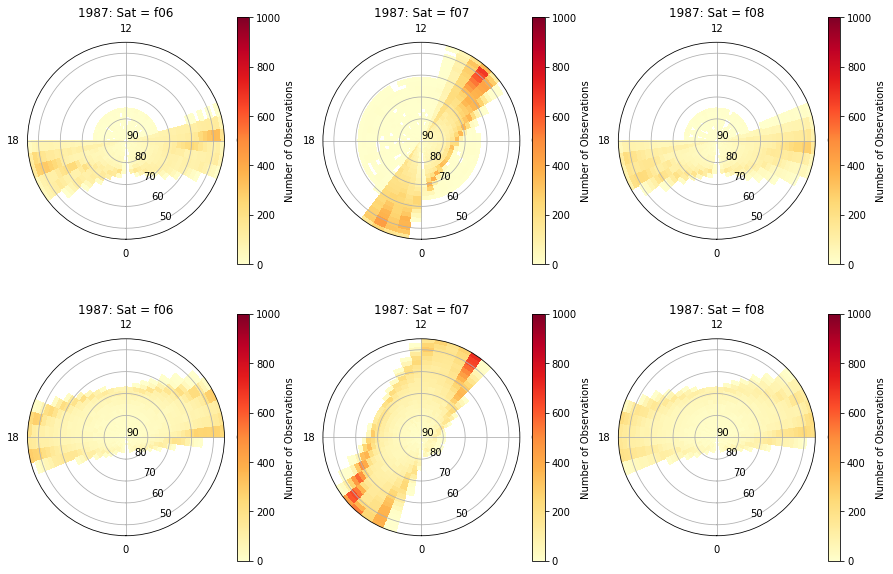

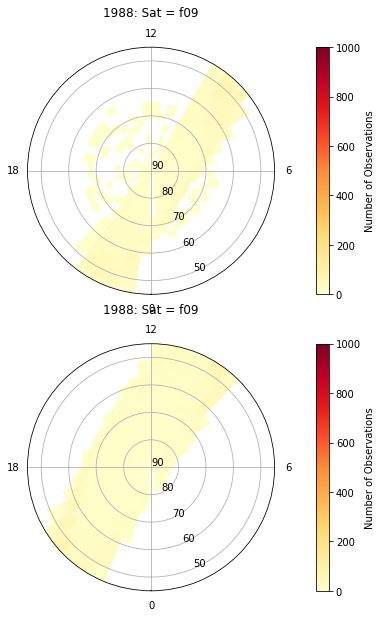

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

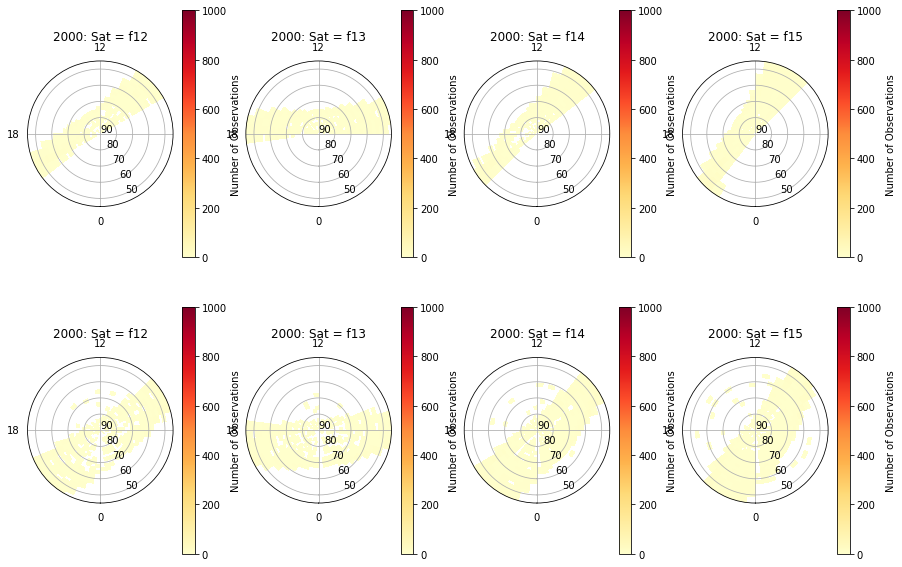

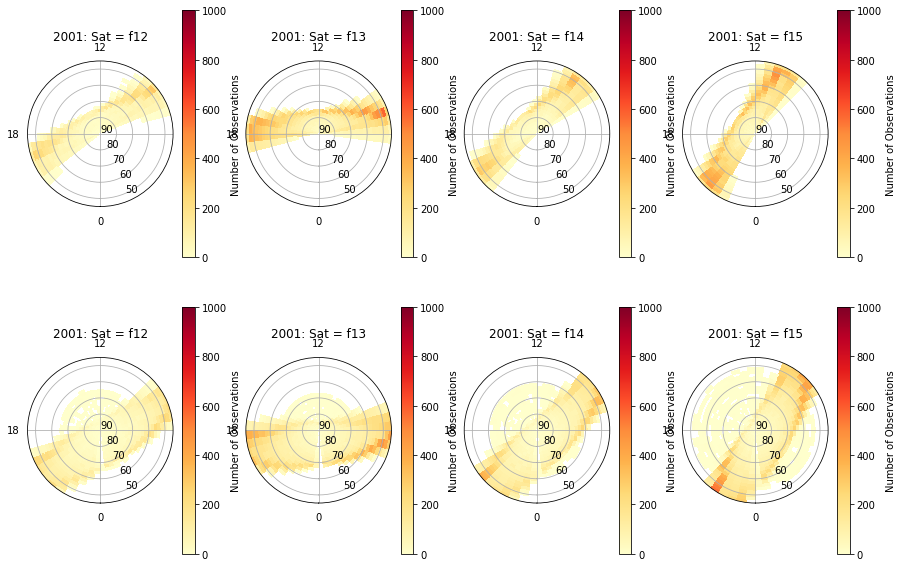

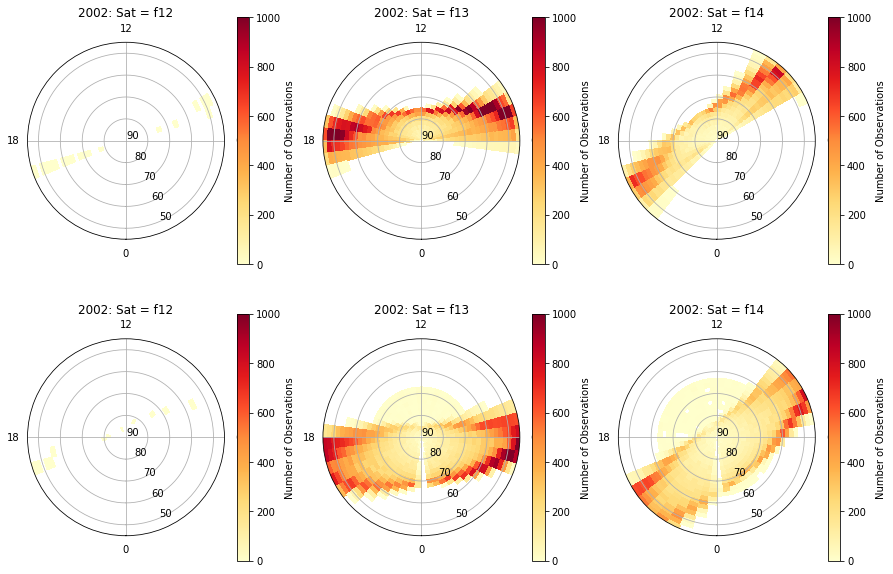

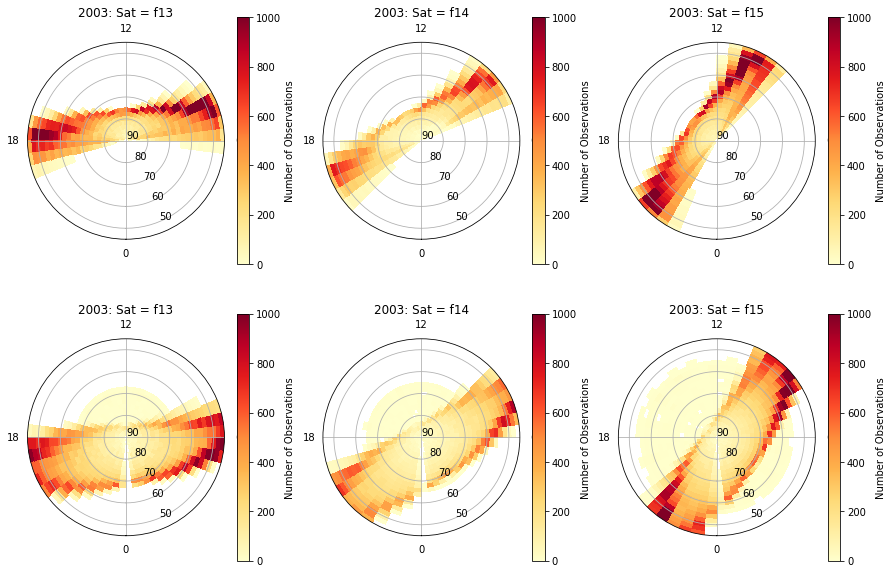

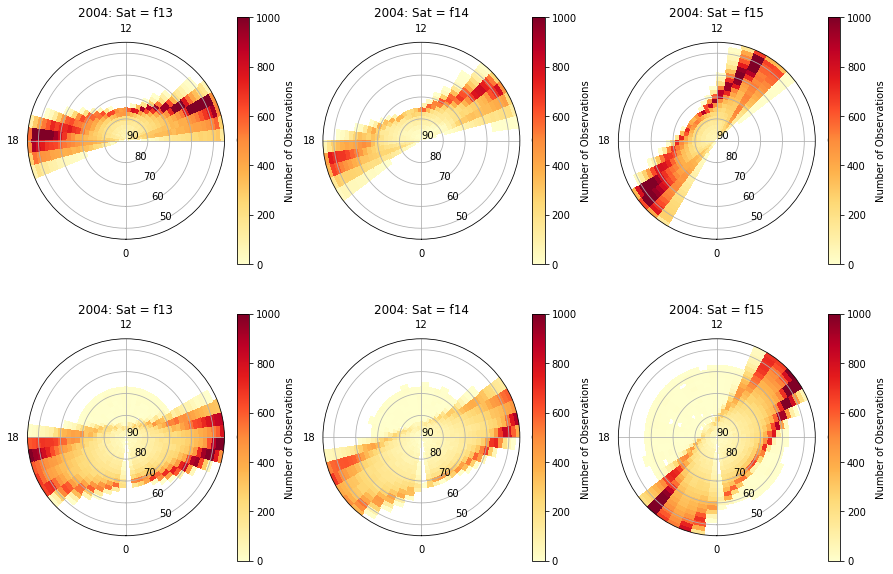

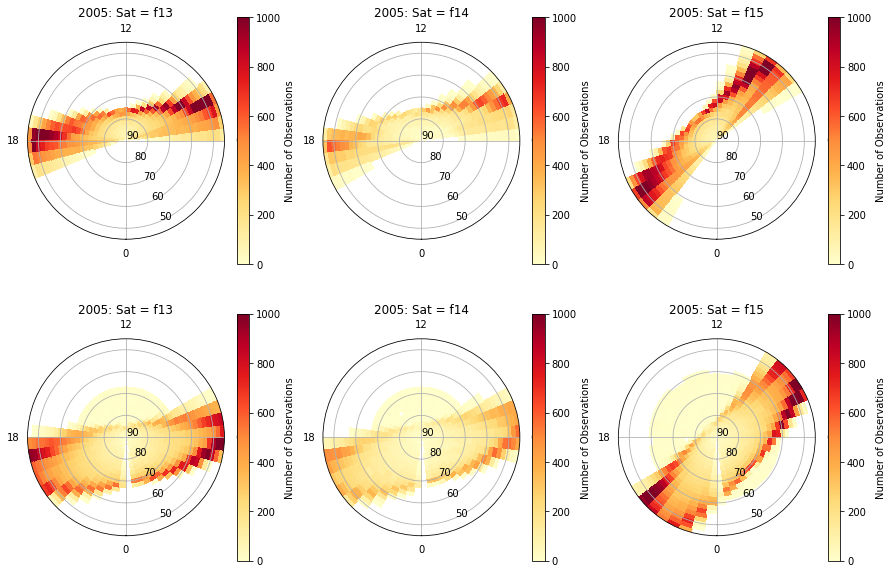

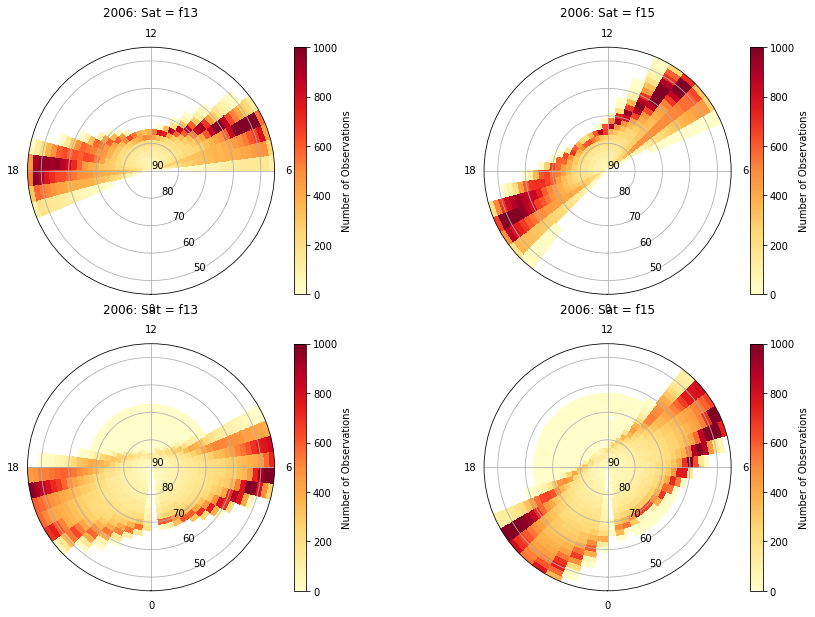

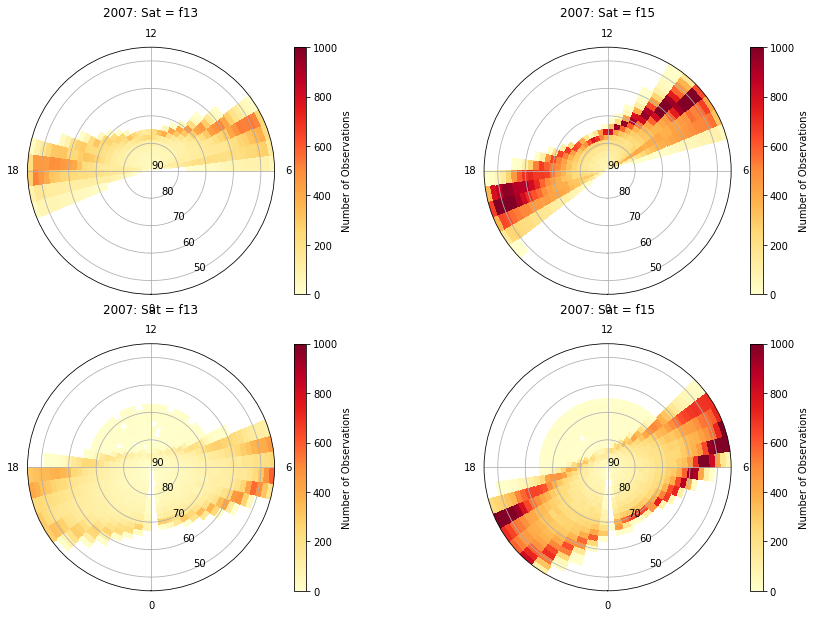

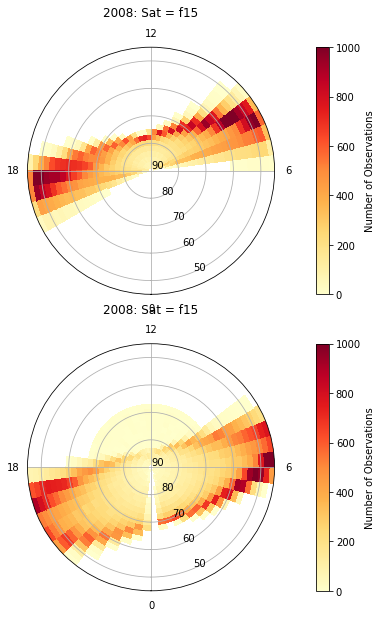

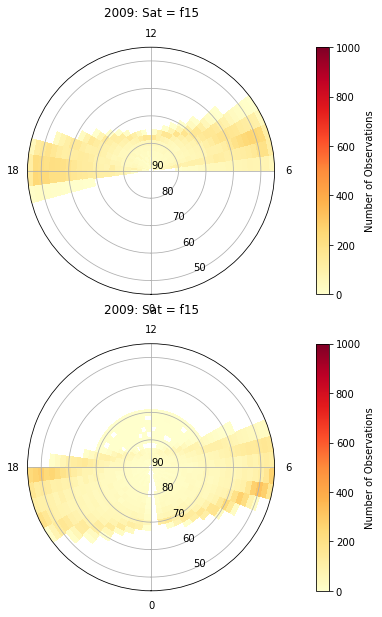

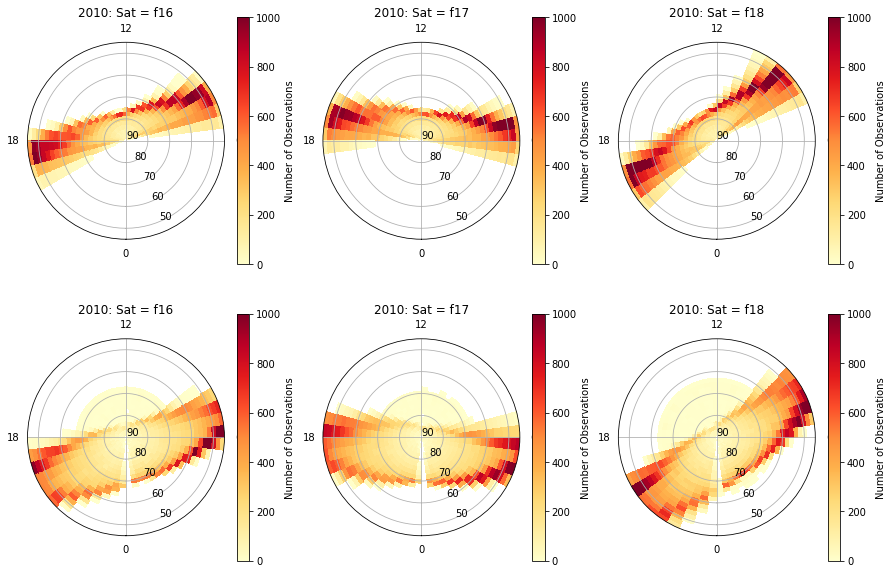

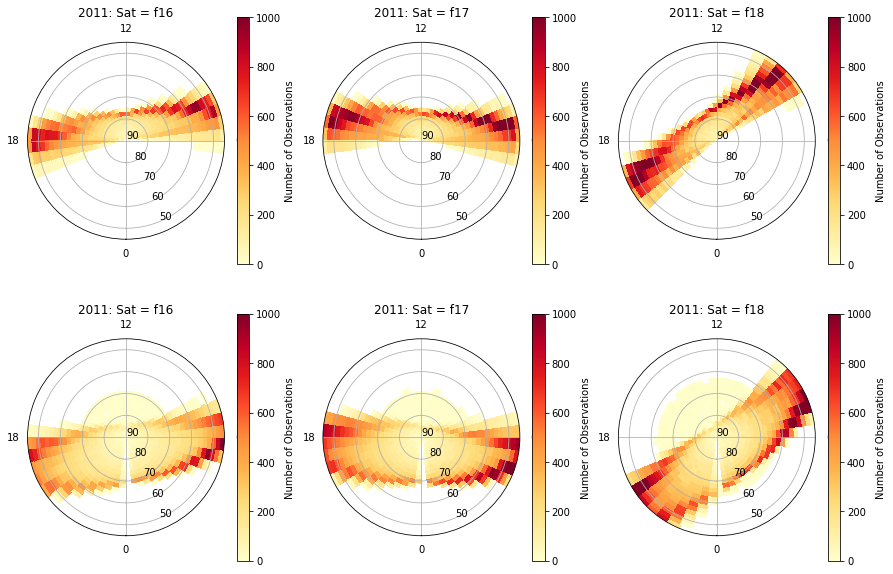

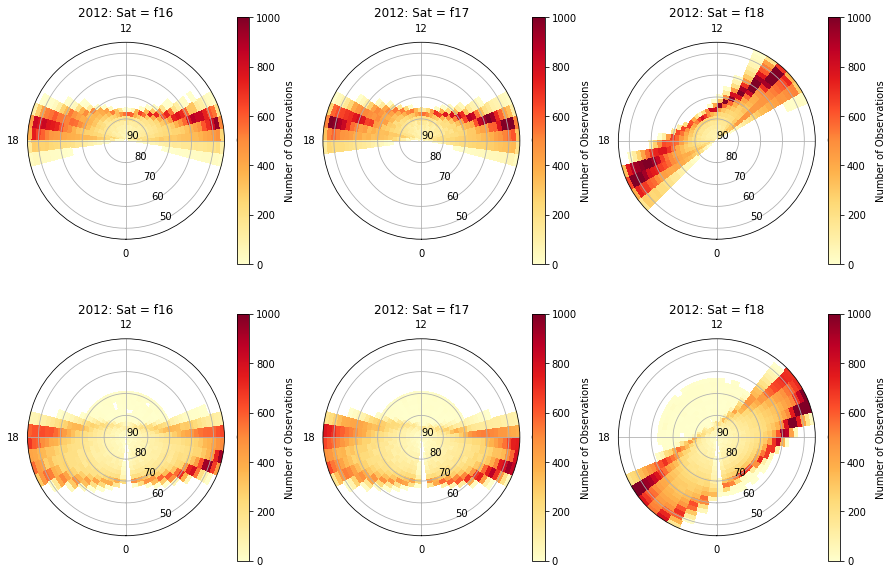

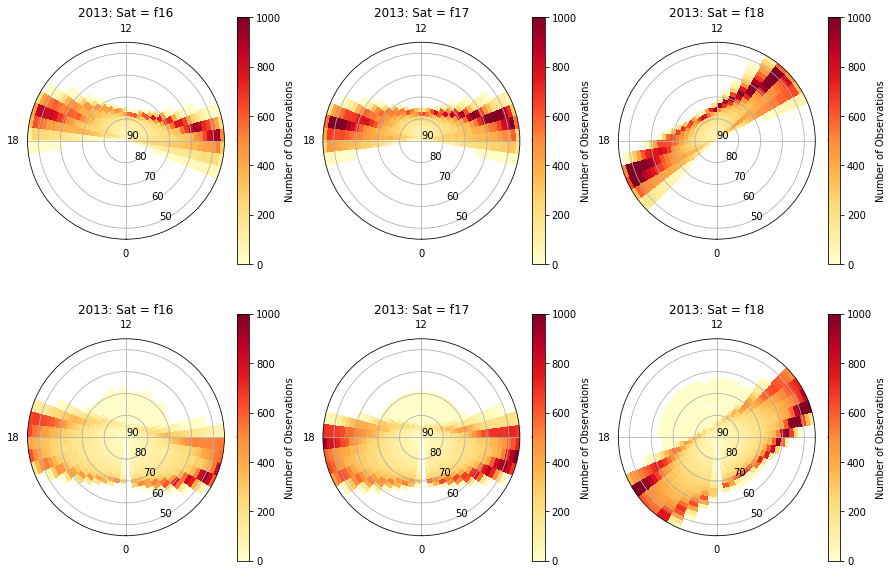

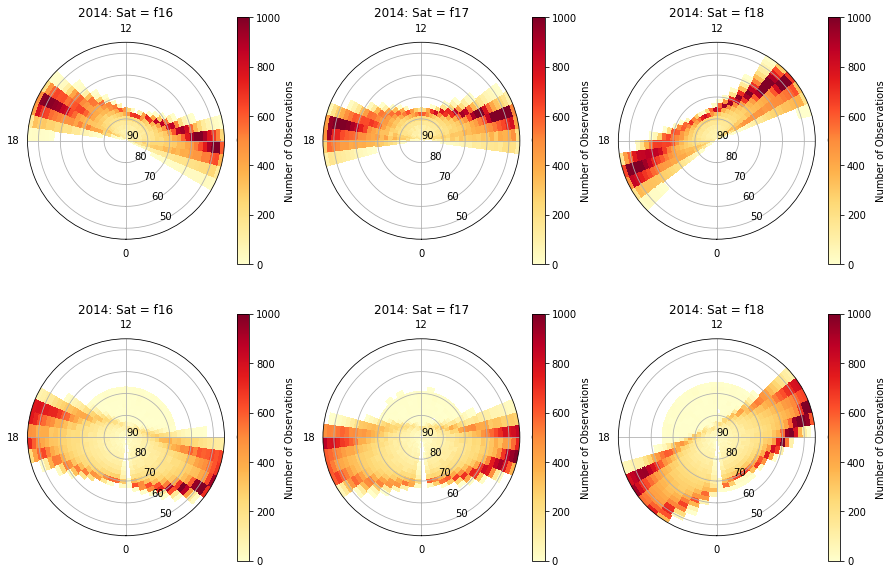

In [32]:
# Take a look at the data coverage by year and satellite
DMSP_DATA_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/'
DMSP_FIGURE_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/figures/'

colorbar_min_density = 0
colorbar_max_density = 1000

colorbar_min_average = 0
colorbar_max_average = 500

colorbar_min_max = 0
colorbar_max_max = 3000

var_for_stats = 'ELE_AVG_ENERGY'

for y in range(1987,2015):
    
    print('year = {}'.format(y))
    
    # Check for existence of files for this year
    files = glob.glob(DMSP_DATA_DIR + '/ML_DB_'+str(y)+'_sat*.csv')
    files.sort()
    num_subplots = len(files)
    
    fig = plt.figure(figsize=(15,10))
    
    for s in range(len(files)):
        sat = files[s][-7:-4]
        
        print('    satellite = {}'.format(sat))

        df = pd.read_csv(files[s])
        
        # Separate NH and SH data
        df_NH = df[df['SC_AACGM_LAT']>=45.].copy(deep=True)
        df_SH = df[df['SC_AACGM_LAT']<=45.].copy(deep=True)
        df_SH['SC_AACGM_LAT'] = df['SC_AACGM_LAT']*-1
        

        print('        size of full data = {:.3F} MB'.format(sys.getsizeof(df) / 10**6))
        print('        size of non-NaN data = {:.3F} MB'.format(sys.getsizeof(df.dropna()) / 10**6))

        print('        size of NH full data = {:.3F} MB'.format(sys.getsizeof(df_NH) / 10**6))
        print('        size of NH non-NaN data = {:.3F} MB'.format(sys.getsizeof(df_NH.dropna()) / 10**6))

        print('        size of SH full data = {:.3F} MB'.format(sys.getsizeof(df_SH) / 10**6))
        print('        size of SH non-NaN data = {:.3F} MB'.format(sys.getsizeof(df_SH.dropna()) / 10**6))
        
        
        grid_density_NH,grid_average_NH,grid_max_NH,mlats_plot,mlts_plot = get_dmsp_coverage(df_NH,latres=2.0,ltres=0.5,verbose=0)
        grid_density_SH,grid_average_SH,grid_max_SH,mlats_plot,mlts_plot = get_dmsp_coverage(df_SH,latres=2.0,ltres=0.5,verbose=0)
    

        ######## Create polar plots ########
        
        # NH
        subplot_index = 200 + num_subplots*10 + s + 1
        ax = plt.subplot(subplot_index, polar=True)
        ctf = ax.pcolormesh(mlts_plot, mlats_plot, grid_density_NH,
                            vmin=colorbar_min_density,
                            vmax=colorbar_max_density, 
                            cmap='YlOrRd')

        cbar = plt.colorbar(ctf,ax=ax)
        cbar.ax.set_ylabel('Number of Observations')
        cbar.set_clim(colorbar_min_density,colorbar_max_density)


        # define your axis limits
        ax.set_ylim([0,45])

        # Set the radius labels
        ax.set_yticks(np.arange(0,50,10))  # less radial ticks
        ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

        # Set the circumference labels
        ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        ax.set_xticklabels(('0','6','12','18'))      
        # Make the labels go clockwise
        # ax.set_theta_direction(-1)

        ax.grid(True)
        ax.set_theta_zero_location("S")

        ax.set_title(str(y) +': Sat = '+sat,y=1.10)
        
        # SH        
        subplot_index = subplot_index+num_subplots
        ax = plt.subplot(subplot_index, polar=True)
        ctf = ax.pcolormesh(mlts_plot, mlats_plot, grid_density_SH,
                            vmin=colorbar_min_density,
                            vmax=colorbar_max_density, 
                            cmap='YlOrRd')

        cbar = plt.colorbar(ctf,ax=ax)
        cbar.ax.set_ylabel('Number of Observations')
        cbar.set_clim(colorbar_min_density,colorbar_max_density)

        # define your axis limits
        ax.set_ylim([0,45])

        # Set the radius labels
        ax.set_yticks(np.arange(0,50,10))  # less radial ticks
        ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

        # Set the circumference labels
        ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        ax.set_xticklabels(('0','6','12','18'))      
        # Make the labels go clockwise
        # ax.set_theta_direction(-1)

        ax.grid(True)
        ax.set_theta_zero_location("S")

        ax.set_title(str(y) +': Sat = '+sat,y=1.10)

    if files:
#         plt.show() 
        fig_filename = DMSP_FIGURE_DIR + 'obs_density_'+str(y)+'.png'
        plt.savefig(fig_filename)

In [5]:
DMSP_DATA_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/'
y = 2010
files = glob.glob(DMSP_DATA_DIR + '/ML_DB_'+str(y)+'_sat*.csv')
files.sort()
print(files)

['/Users/ryanmcgranaghan/Documents/DMSPdata/data/ML_DB_2010_sat_f16.csv', '/Users/ryanmcgranaghan/Documents/DMSPdata/data/ML_DB_2010_sat_f17.csv', '/Users/ryanmcgranaghan/Documents/DMSPdata/data/ML_DB_2010_sat_f18.csv']


In [ ]:
ctr_i = 0
directory = '/Users/ryanmcgranaghan/Documents/DMSPdata/'
for i in range(1987,2010):
    print('working on year = {}'.format(i))
    file = directory+'dmsp_'+str(i)+'.csv'
    print('file = {}'.format(file))
    if not os.path.isfile(file):
        print('file {}\n      does not exist\n\n\n'.format(file))
        continue
    
    df = pd.read_csv(file)

    # Remove southern hemisphere data
    print(len(df))
    df = df[df['SC_AACGM_LAT']>=45.]
    print(len(df))

    grid_density = get_dmsp_coverage(df,latres=2.0,ltres=1.0)
    
    print(grid_density[0])
    
    # Create polar plot
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111, polar=True)
    ctf = ax.contourf(mlts_plot, mlats_plot, grid_density, cmap='YlOrRd')
    
    cbar = plt.colorbar(ctf)
    ax = plt.gca()
    cbar.ax.set_ylabel('Number of Observations')

    # define your axis limits
    ax.set_ylim([0,45])

    # Set the radius labels
    ax.set_yticks(np.arange(0,50,10))  # less radial ticks
    ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

    # Set the circumference labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
    ax.set_xticklabels(('0','6','12','18'))      
    # Make the labels go clockwise
    # ax.set_theta_direction(-1)

    ax.grid(True)
    ax.set_theta_zero_location("S")
    
    ax.set_title(i,y=1.10)
    
    ctr_i += 1
